In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.dates as mdates

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

from termcolor import colored

import warnings

import os

#from mystuff import bdh
#from funciones_optim import port_ret,sumauno,var,r_gen,min_vol, normi, prat,_data


# Datos Diarios

In [2]:
data = pd.read_csv('data_diaria_activos.csv', index_col = 'date')

In [3]:
duracion_por_columna = {
    'USTTEN': 8.2
}
columns = ['USTTEN']

for col in columns:
    duracion = duracion_por_columna.get(col, 0)
    data[col] = ((data[col] / 100) - data[col].shift(1) / 100) * (-duracion) + ((data[col] / 100 + data[col].shift(1) / 100) / 2) / 365
    data[col] = data[col].add(1).cumprod() * 100
    
for col in columns:
    data.at[data.index[0], col] = 100
    
data = data.sort_values('date')
data.index = (pd.to_datetime(data.index, format='%Y-%m-%d'))

In [4]:
data.head()

SPX     EEM      XAU      USTTEN  USCASH   USDCOP     COCASH
date                                                                        
2011-01-03  1271.87  48.100  1414.80  100.000000    0.19  1893.05  -8.339551
2011-01-04  1270.20  48.320  1380.50  100.039465    0.18  1894.50 -11.155551
2011-01-05  1276.56  48.200  1378.25   98.927393    0.18  1881.00 -10.797201
2011-01-06  1273.85  47.685  1371.56   99.522377    0.17  1866.50  -4.987200
2011-01-07  1271.50  47.250  1369.54  100.098713    0.17  1872.00  -4.853751

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3344 entries, 2011-01-03 to 2023-10-26
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPX     3344 non-null   float64
 1   EEM     3344 non-null   float64
 2   XAU     3344 non-null   float64
 3   USTTEN  3344 non-null   float64
 4   USCASH  3344 non-null   float64
 5   USDCOP  3344 non-null   float64
 6   COCASH  3344 non-null   float64
dtypes: float64(7)
memory usage: 209.0 KB


## Cálculo de los retornos diarios de los activos

Se calcula el retorno logarítmico diario de todos los activos. En el caso de los activos de renta fija, se calcula un índice para facilitar este proceso.

In [6]:
data_r = pd.DataFrame()

for col in data.columns:
    data_r[f'R{col}'] = (np.log(data[col] / data[col].shift(1)))

data_r.RUSCASH = data.USCASH.mul(1/360).div(100)
data_r.RCOCASH = data.COCASH.mul(1/360).div(100)

data_r.RUSDCOP = (np.log(data.USDCOP / data.USDCOP.shift(1))) + data_r.RUSCASH - data_r.RCOCASH

data_r.head()

c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


RSPX      REEM      RXAU   RUSTTEN   RUSCASH   RUSDCOP  \
date                                                                     
2011-01-03       NaN       NaN       NaN       NaN  0.000005       NaN   
2011-01-04 -0.001314  0.004563 -0.024542  0.000395  0.000005  0.001081   
2011-01-05  0.004995 -0.002487 -0.001631 -0.011179  0.000005 -0.006846   
2011-01-06 -0.002125 -0.010742 -0.004866  0.005996  0.000005 -0.007595   
2011-01-07 -0.001847 -0.009164 -0.001474  0.005774  0.000005  0.003082   

             RCOCASH  
date                  
2011-01-03 -0.000232  
2011-01-04 -0.000310  
2011-01-05 -0.000300  
2011-01-06 -0.000139  
2011-01-07 -0.000135

En todos los casos faltará un valor, correspondiente al primero de la serie. Esta fila es eliminada.

In [7]:
(data_r.isna().sum(axis=0)/len(data)).sort_values(ascending = False)

RSPX       0.000299
REEM       0.000299
RXAU       0.000299
RUSTTEN    0.000299
RUSDCOP    0.000299
RUSCASH    0.000000
RCOCASH    0.000000
dtype: float64

In [8]:
data_r = data_r.dropna()
(data_r.isna().sum(axis=0)/len(data)).sort_values(ascending = False)

RSPX       0.0
REEM       0.0
RXAU       0.0
RUSTTEN    0.0
RUSCASH    0.0
RUSDCOP    0.0
RCOCASH    0.0
dtype: float64

In [9]:
data_r.to_csv('Activos_r.csv')

In [10]:
data_r.index = (pd.to_datetime(data_r.index, format='%d/%m/%Y'))

## Visualización de las Series de Tiempo Precio

In [11]:
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Precio', dpi=100, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(x, y, color='tab:red')
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%Y"))
    ax.set_xlim(x.min(), x.max())
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)

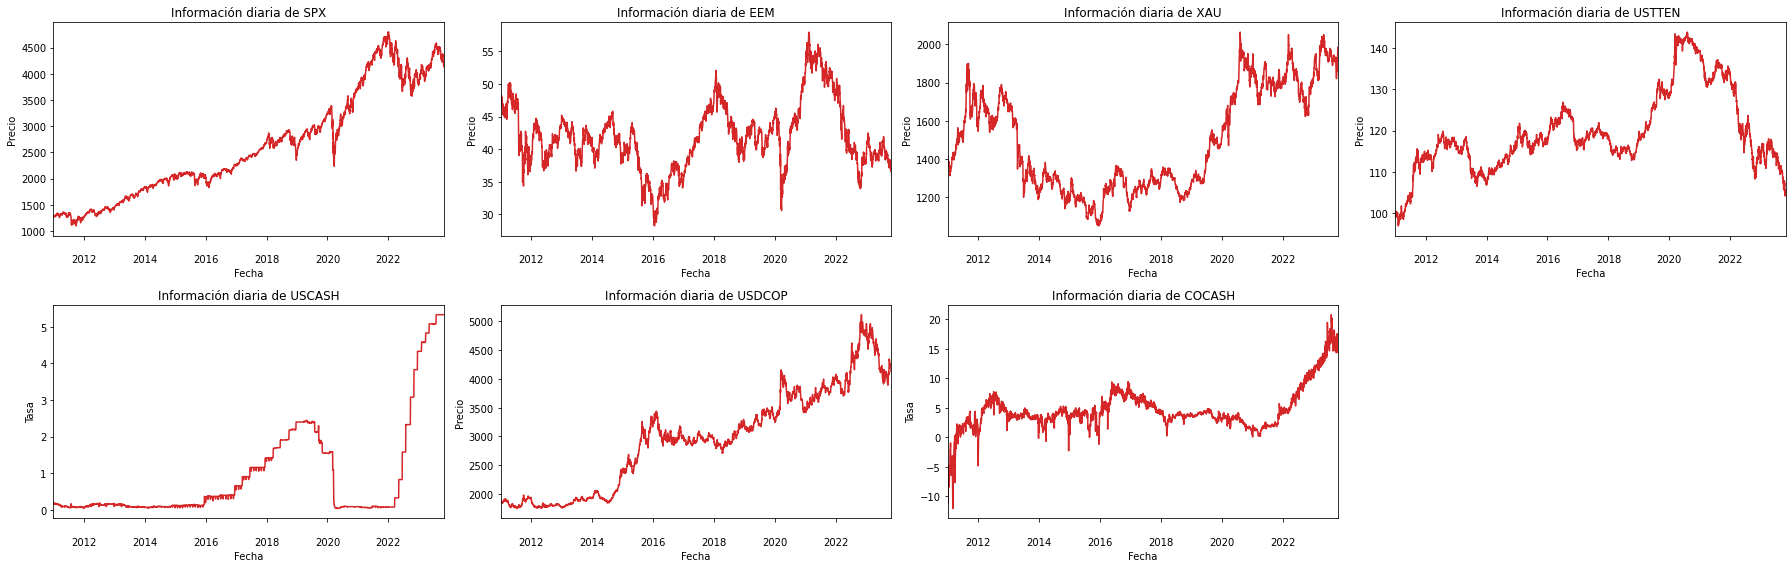

In [12]:
num_columns = min(4, len(data.columns)) 
num_rows = math.ceil(len(data.columns) / num_columns)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8))

for i, column in enumerate(data.columns):
    row = i // num_columns
    col = i % num_columns
    plot_df(data, x=data.index.values, y=data[column], title=f'Información diaria de {column}', ax=axes[row, col])

rate_positions =[(1,0), (1,2)]

for row, col in rate_positions:
    axes[row, col].set_ylabel('Tasa')
    
specific_positions = [(1, 3)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

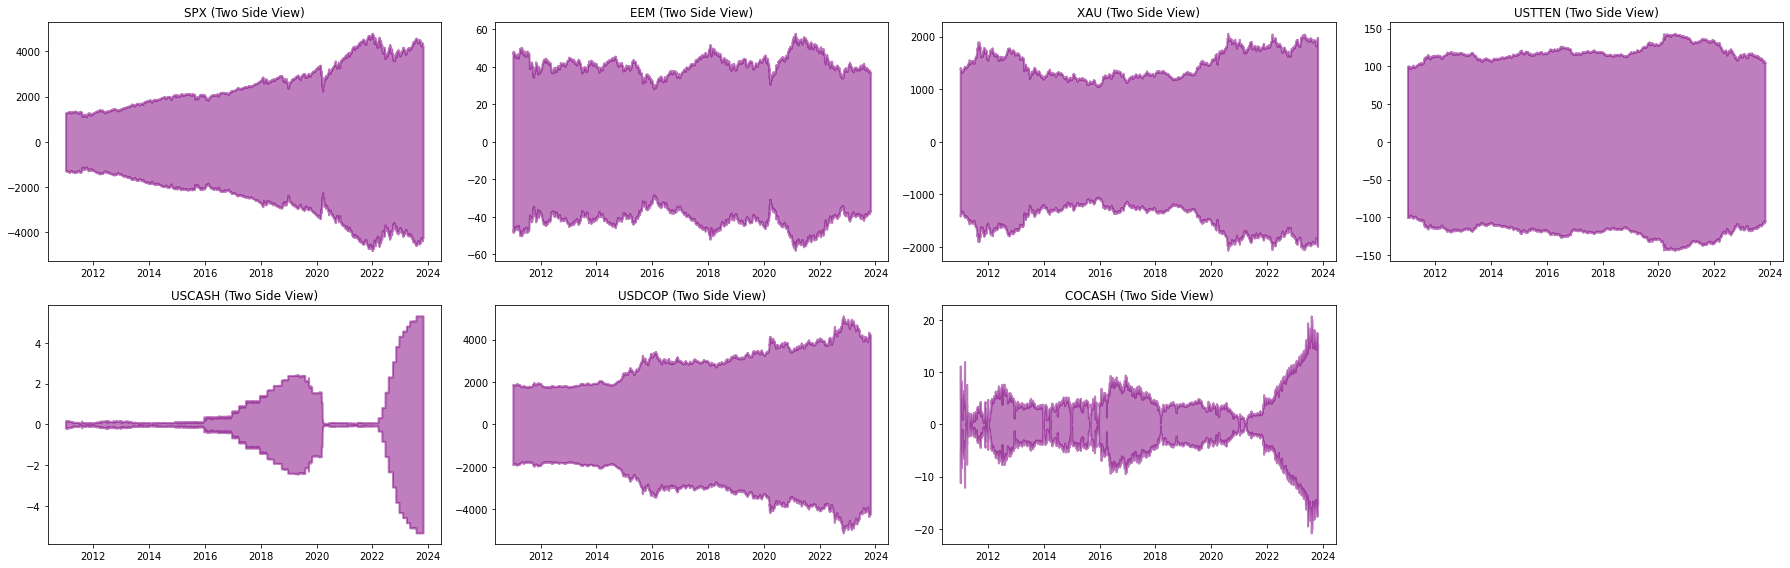

In [13]:
x = data.index.values

fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8))

for i, column in enumerate(data.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    y1 = data[column]
    ax.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color= 'purple')
    ax.set_title(f'{column} (Two Side View)', fontsize=12)

specific_positions = [(1, 3)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

## Visualización de las Series de Tiempo Retornos

A diferencia de las series anteriores, los retornos logarítmicos de los activos parecen ser estacionarios. 

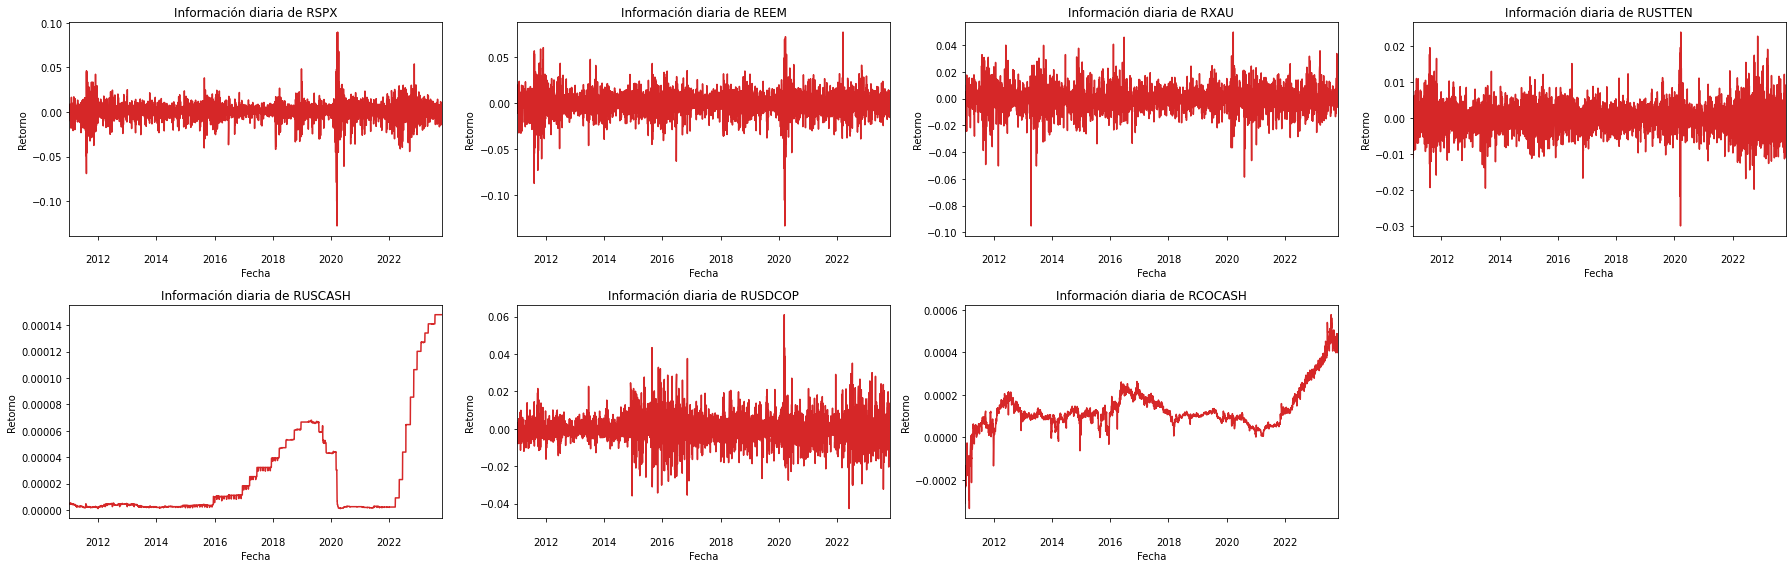

In [14]:

fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8))

for i, column in enumerate(data_r.columns):
    row = i // num_columns
    col = i % num_columns
    plot_df(data_r, x=data_r.index.values, y=data_r[column], title=f'Información diaria de {column}', ax=axes[row, col])
    axes[row, col].set_ylabel('Retorno')

specific_positions = [(1, 3)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

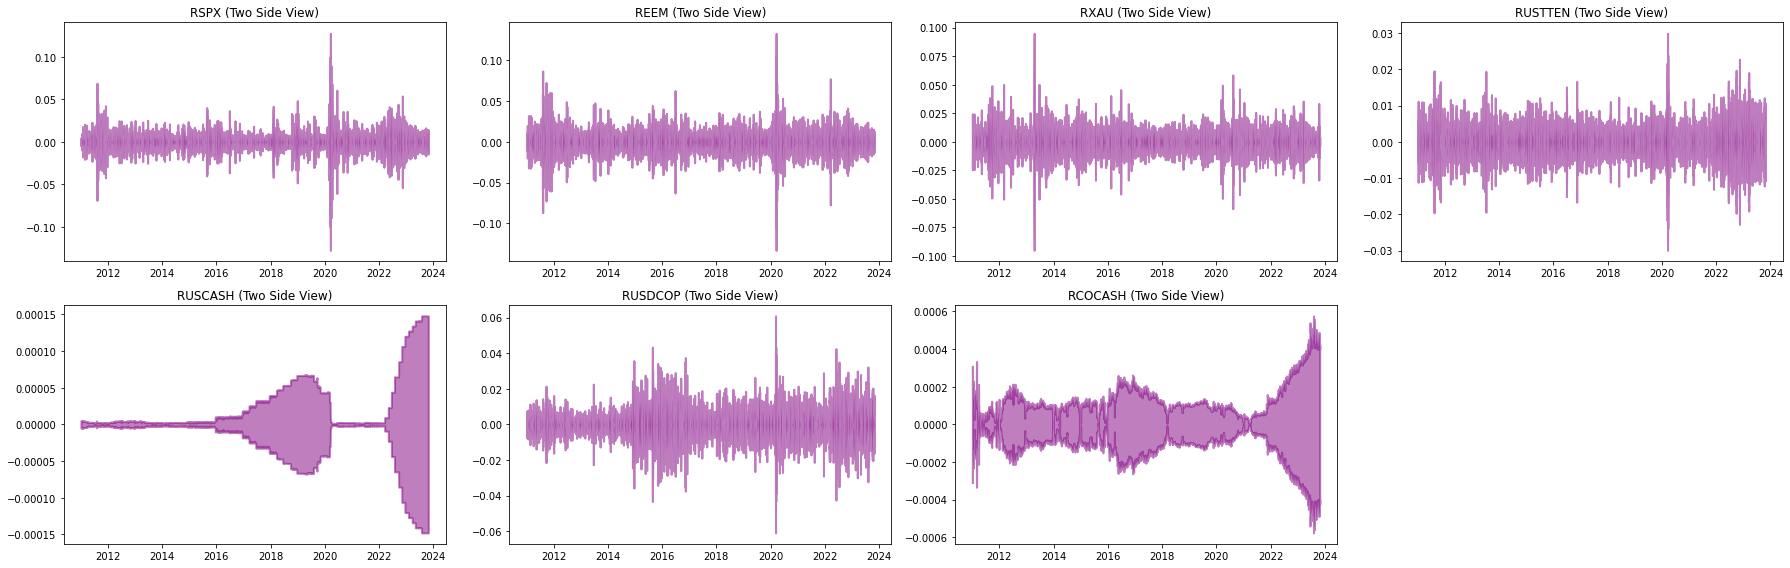

In [15]:
x = data_r.index.values

fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8))

for i, column in enumerate(data_r.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    y1 = data_r[column]
    ax.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color= 'purple')
    ax.set_title(f'{column} (Two Side View)', fontsize=12)

specific_positions = [(1, 3)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

## Análisis Exploratorio de Precios

In [16]:
# Estadística descriptiva
stats = data.describe().round(2)
stats

SPX      EEM      XAU   USTTEN   USCASH   USDCOP   COCASH
count  3344.00  3344.00  3344.00  3344.00  3344.00  3344.00  3344.00
mean   2616.22    42.00  1497.93   119.46     0.95  2950.03     4.64
std    1018.27     5.13   266.41     9.56     1.36   877.04     3.60
min    1099.23    28.25  1051.10    96.93     0.04  1747.65   -12.04
25%    1852.47    38.97  1266.41   113.87     0.09  1933.72     2.95
50%    2401.50    41.54  1425.12   117.37     0.16  2979.50     3.94
75%    3342.17    44.56  1746.78   123.30     1.55  3641.32     5.71
max    4796.56    57.96  2063.54   143.88     5.33  5117.00    20.77

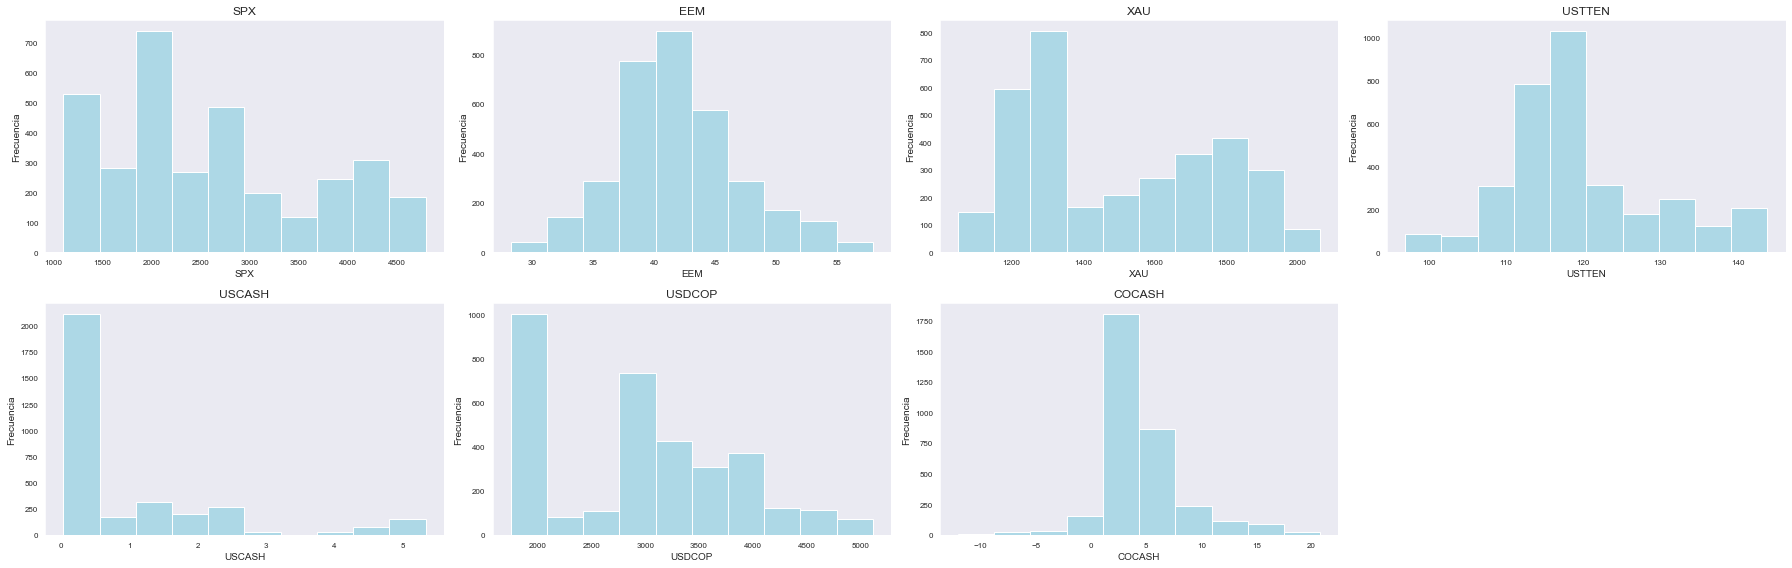

In [17]:
# Histogramas
sns.set_style("dark")
num_columns = min(4, len(data.columns)) 
num_rows = math.ceil(len(data.columns) / num_columns)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8))

for i, column in enumerate(data.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    ax.hist(data[column], color = "lightblue", ec="white")
    ax.set_title(column, fontsize=12)
    ax.set_xlabel(column, fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='both', labelsize=8)

specific_positions = [(1, 3)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

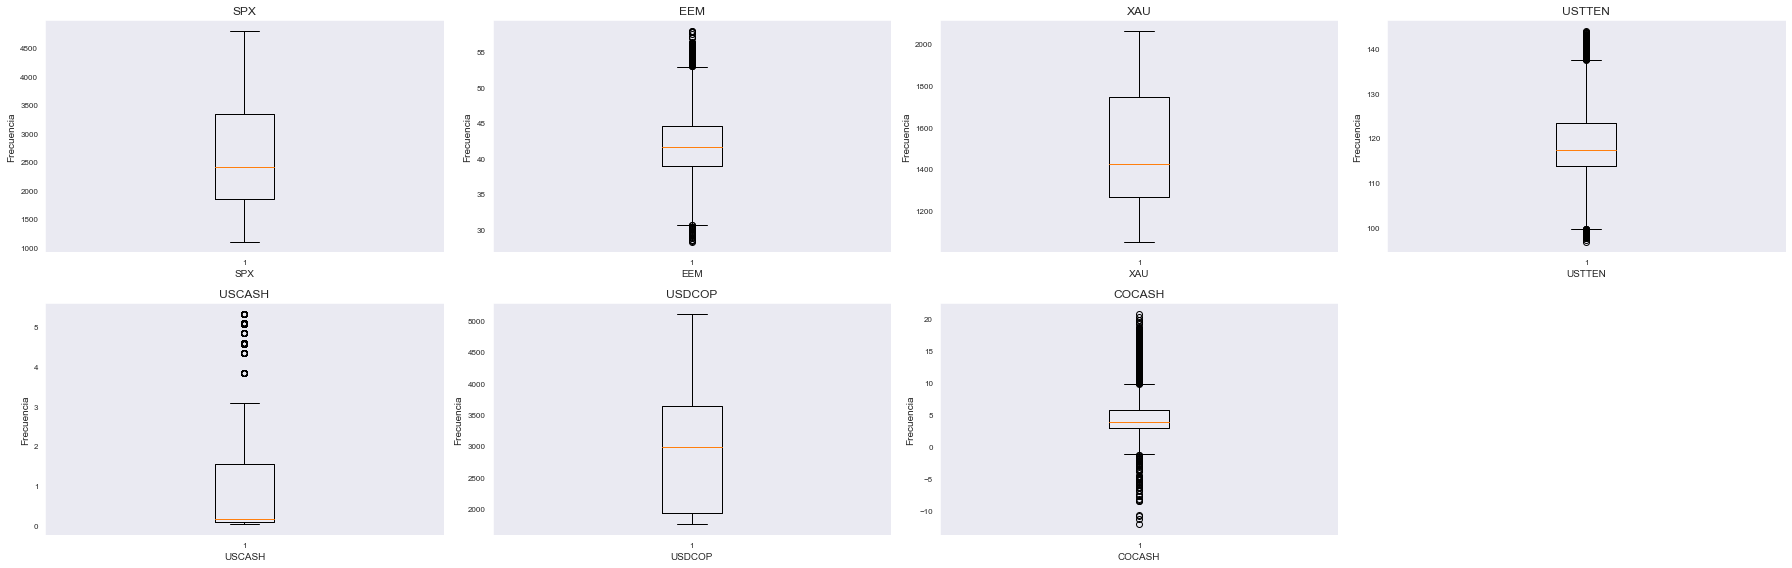

In [18]:
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8))

for i, column in enumerate(data.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    ax.boxplot(data[column])
    ax.set_title(column, fontsize=12)
    ax.set_xlabel(column, fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='both', labelsize=8)

specific_positions = [(1, 3)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

### Correlación entre activos

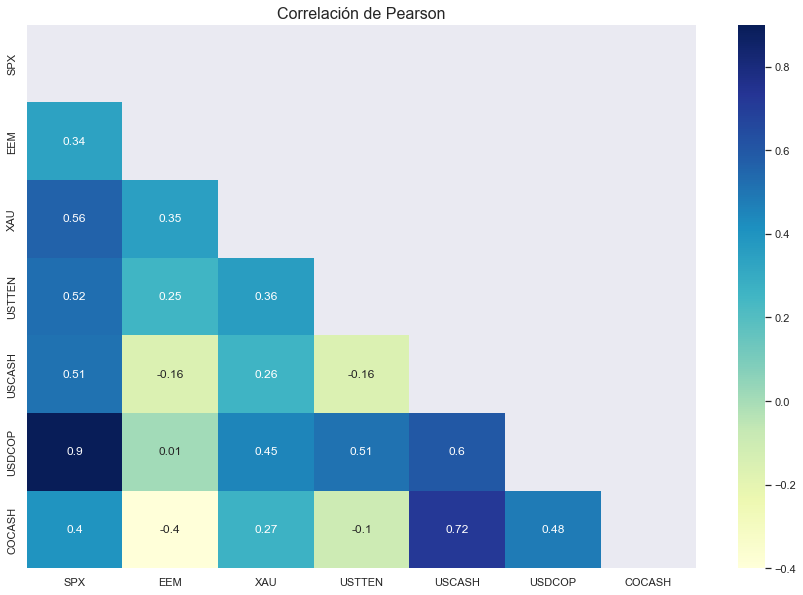

In [19]:
#Correlación de Pearson
plt.figure(figsize = (15,10))
sns.set(font_scale=1)
corr_df = data.corr(method='pearson').round(2)
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_df,annot=True,cmap='YlGnBu',annot_kws={"size":12}, square = False, mask = mask, alpha = 1)
plt.title('Correlación de Pearson', fontsize=16)
plt.show()

### Detección de Outliers

In [20]:
def zscore(s, window, thresh=2, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)   
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    return m 

In [21]:
df_outliers = data.apply(lambda col: zscore(col, window=100), axis=0)
for col in df_outliers.columns:
    false_p = ((1-((df_outliers[col] == True).sum() / len(df_outliers))) * 100).round(2)
    print(f'{col} tiene {false_p}% de outliers')           

SPX tiene 1.2% de outliers
EEM tiene 0.75% de outliers
XAU tiene 1.64% de outliers
USTTEN tiene 1.26% de outliers
USCASH tiene 1.79% de outliers
USDCOP tiene 1.7% de outliers
COCASH tiene 2.78% de outliers


### Estacionariedad

In [22]:
def plot_acf_pacf(series, title):
    plt.rcParams["figure.figsize"] = 25, 8

    fig, axes = plt.subplots(1, 2)

    plt.suptitle(title) 
    
    
    sgt.plot_acf(series, zero = False, lags = 40, ax = axes[0], auto_ylims=True)
    sgt.plot_pacf(series, zero = False, lags = 40, ax = axes[1], auto_ylims=True)
    
    plt.show()

c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


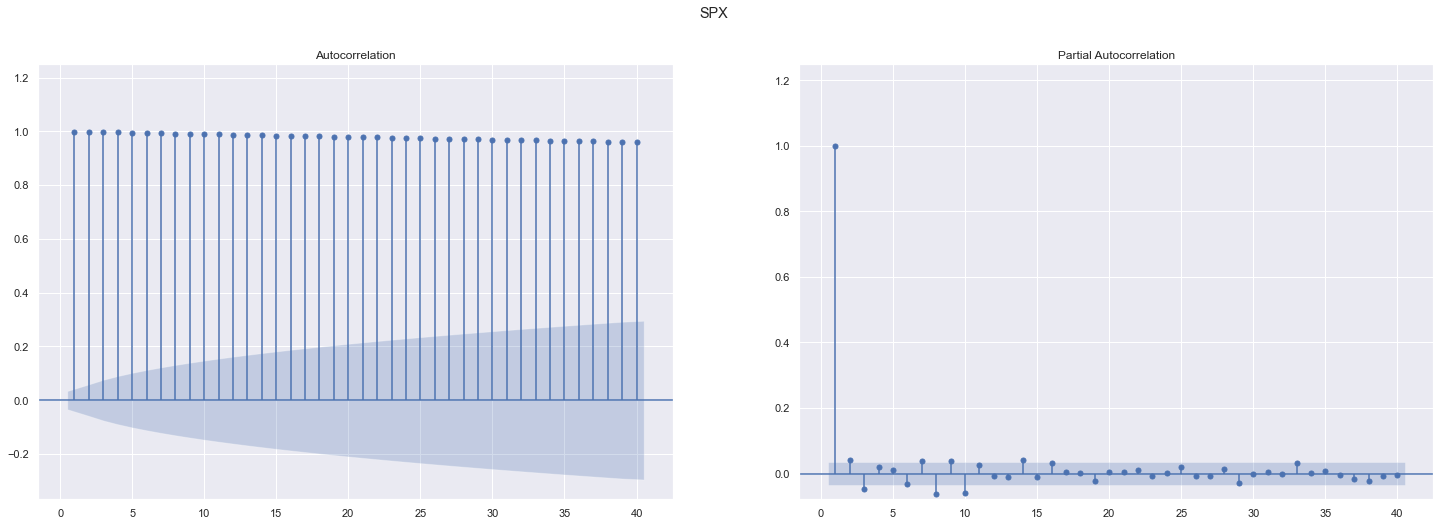

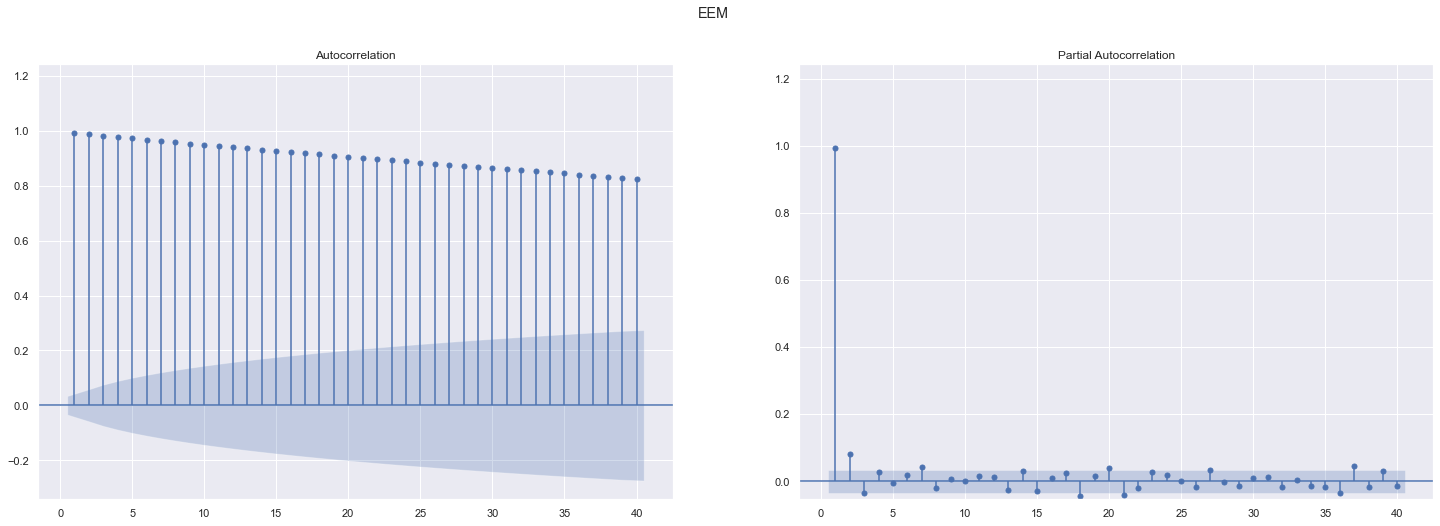

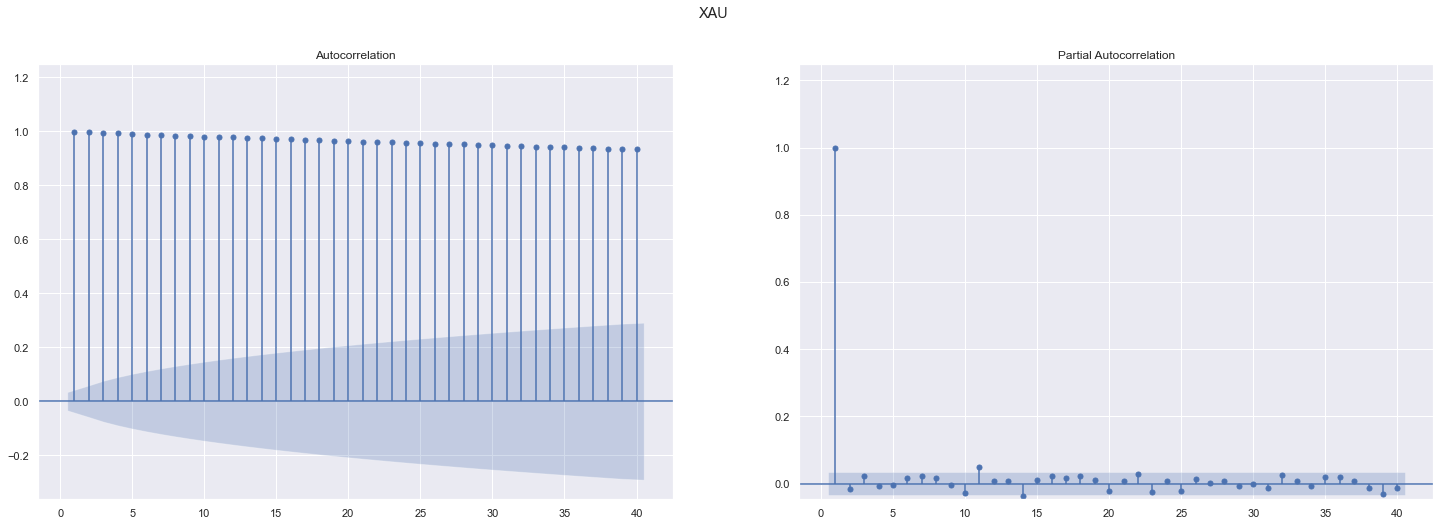

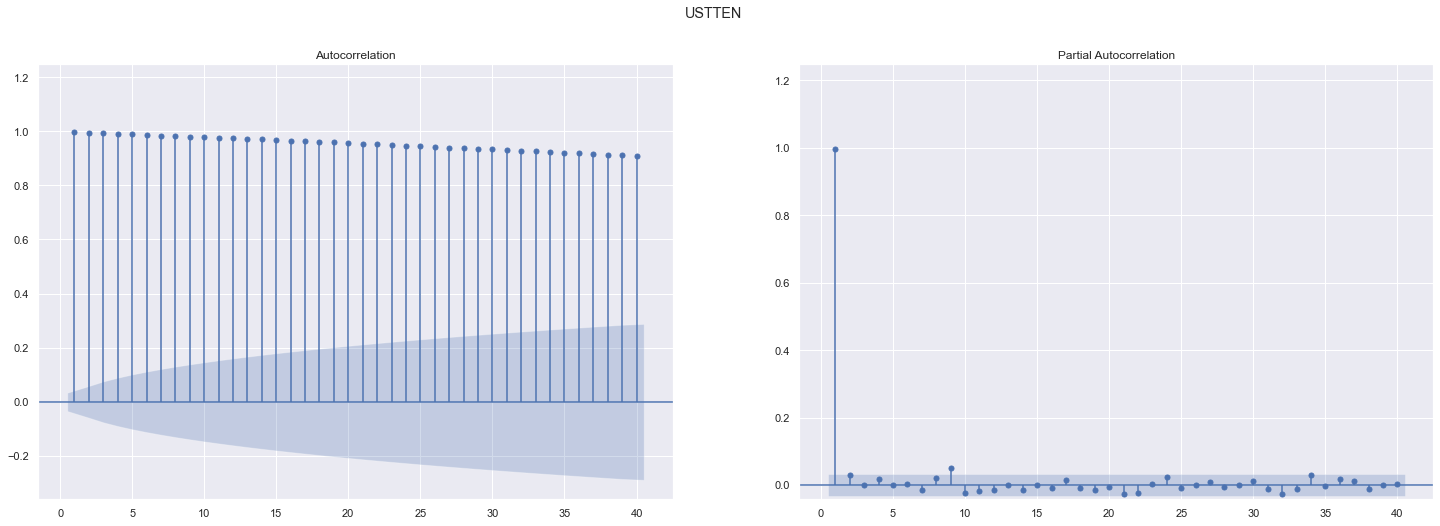

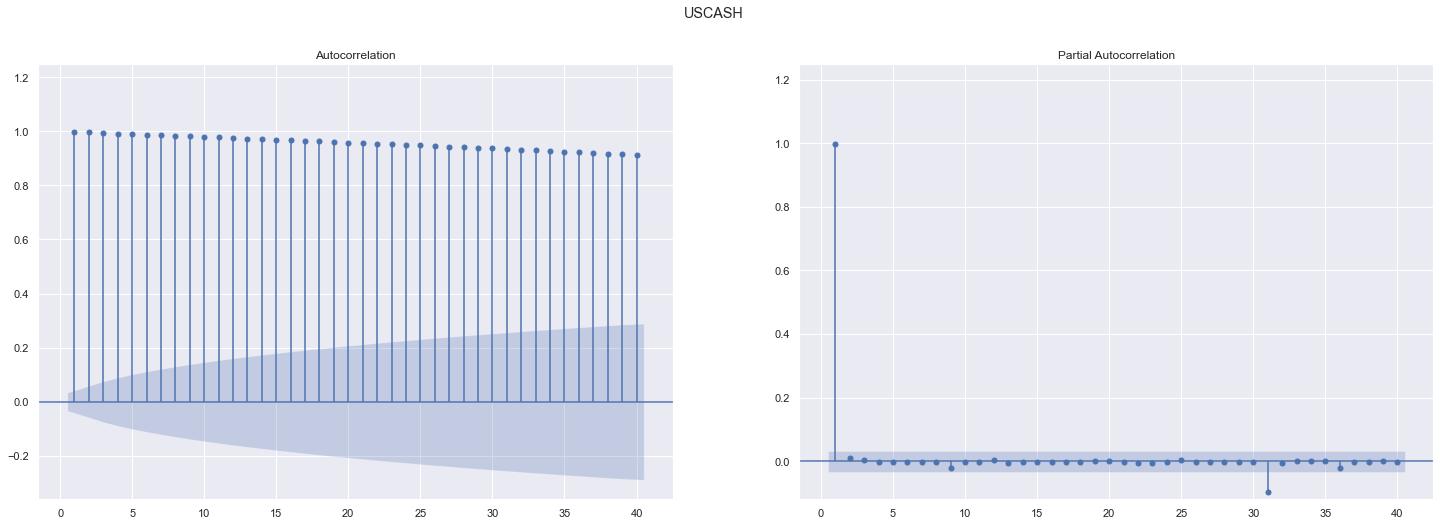

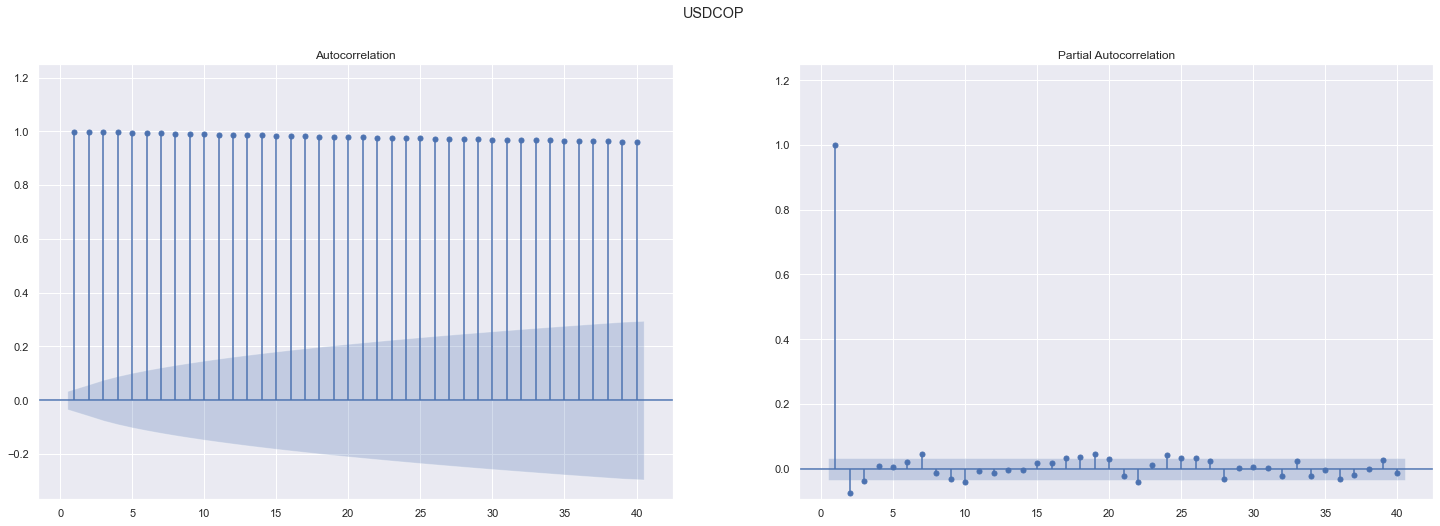

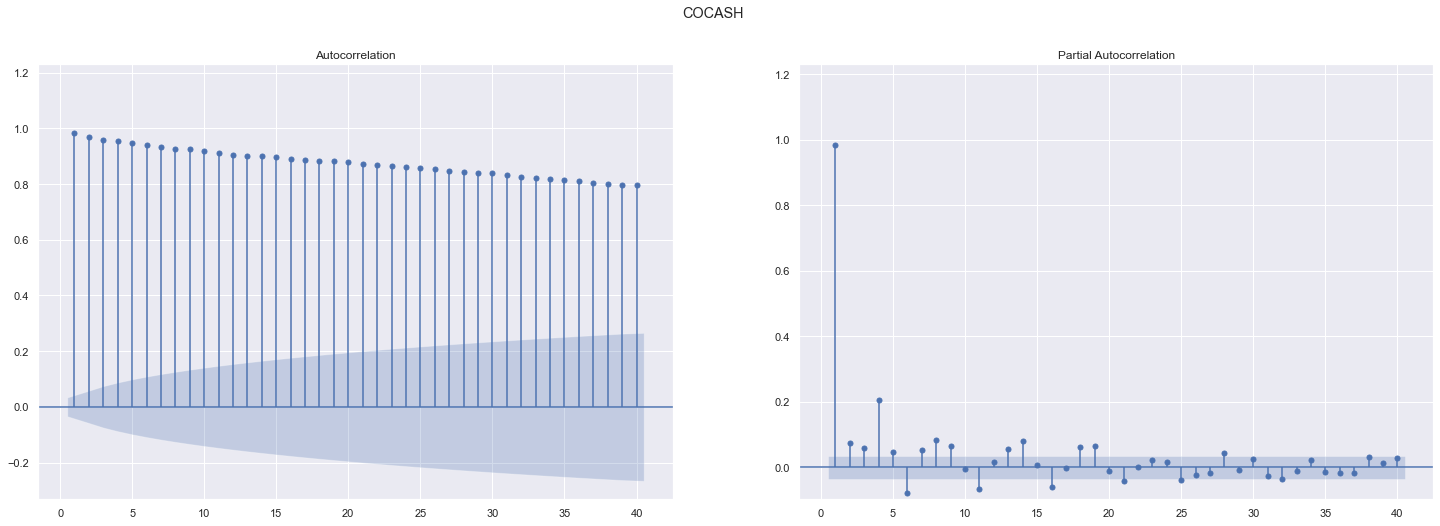

In [23]:
for col in data.columns:
    plot_acf_pacf(data[col], col)

In [24]:
def print_colored(message, color):
    colors = {
        'red': '\033[91m',
        'green': '\033[92m',
        'yellow': '\033[93m',
        'blue': '\033[94m',
        'purple': '\033[95m',
        'cyan': '\033[96m',
        'reset': '\033[0m'}
    color_code = colors.get(color, '')
    reset_code = colors['reset']

    print(f"{color_code}{message}{reset_code}")

In [25]:
for col in data.columns:
    result = sm.tsa.adfuller(data[col])
    # # Print the ADF test results in a user-friendly format
    # print("Augmented Dickey-Fuller Test Results:")
    # print(f"ADF Statistic: {result[0]}")
    # print(f"P-value: {result[1]}")
    # print("Critical Values:")
    # for key, value in result[4].items():
    #     print(f"  {key}: {value}")
    # Interpret the results
    if result[1] <= 0.05:
        print_colored(f"{col} series is likely stationary.", 'green')
    else:
        print_colored(f"{col} series is likely non-stationary.", 'red')

SPX series is likely non-stationary.
EEM series is likely non-stationary.
XAU series is likely non-stationary.
USTTEN series is likely non-stationary.
USCASH series is likely non-stationary.
USDCOP series is likely non-stationary.
COCASH series is likely non-stationary.


In [26]:
data2 = data

# Prepare data
data2['year'] = [d.year for d in data2.index]
data2['month'] = [d.strftime('%b') for d in data2.index]
data2['day'] = [d.strftime('%d') for d in data2.index]
years = data2['year'].unique()

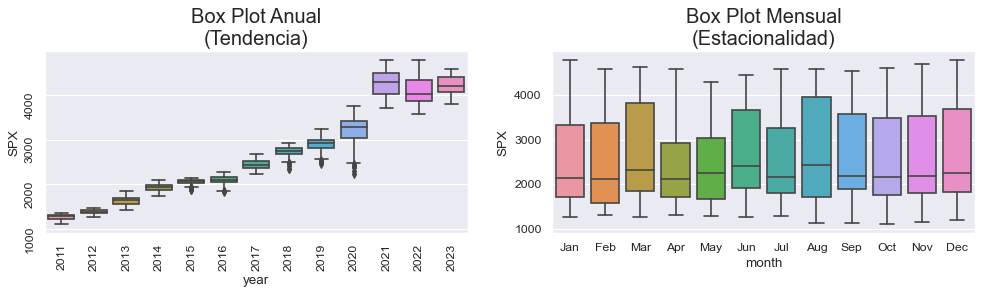

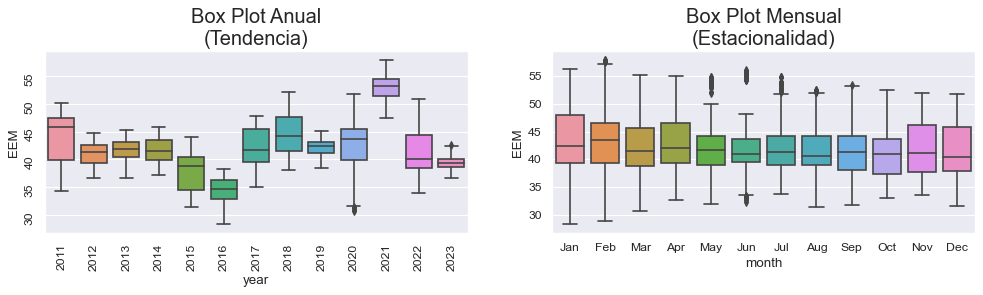

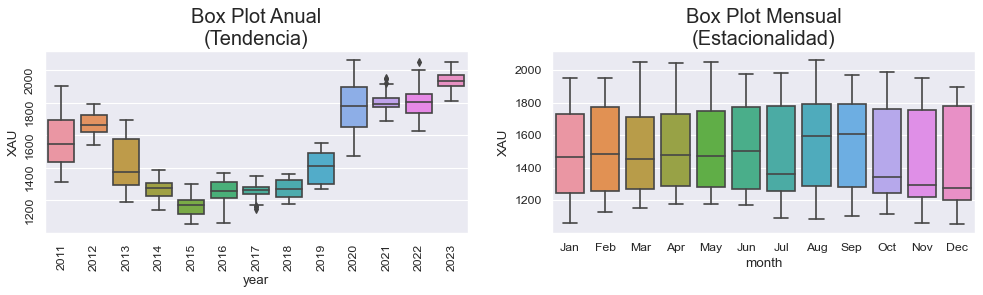

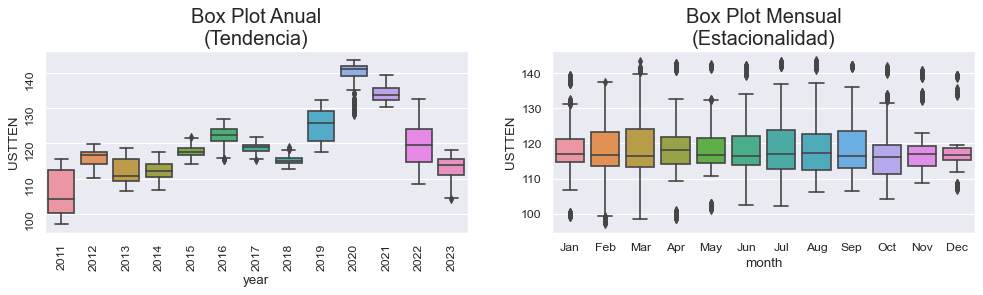

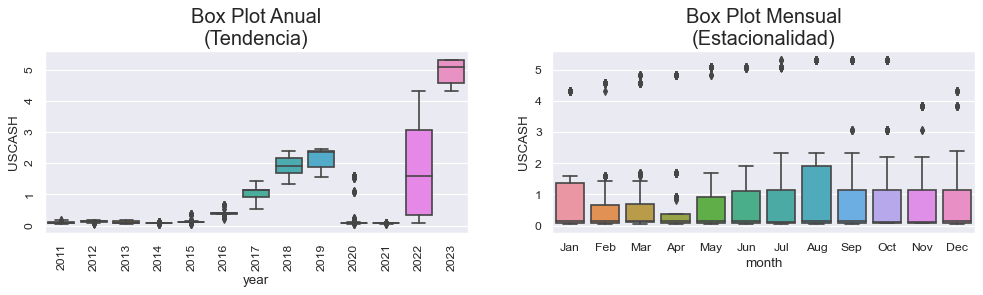

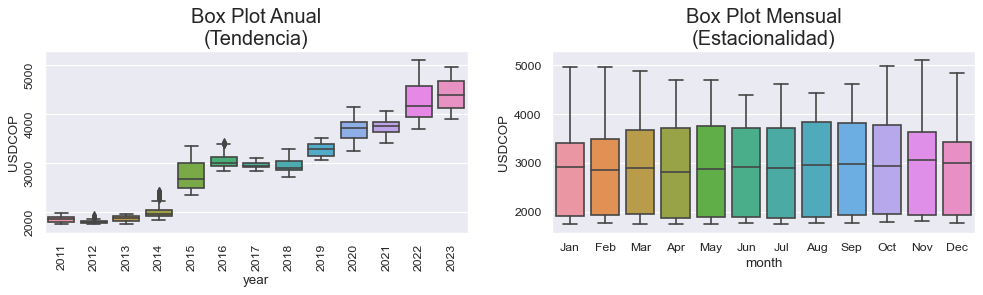

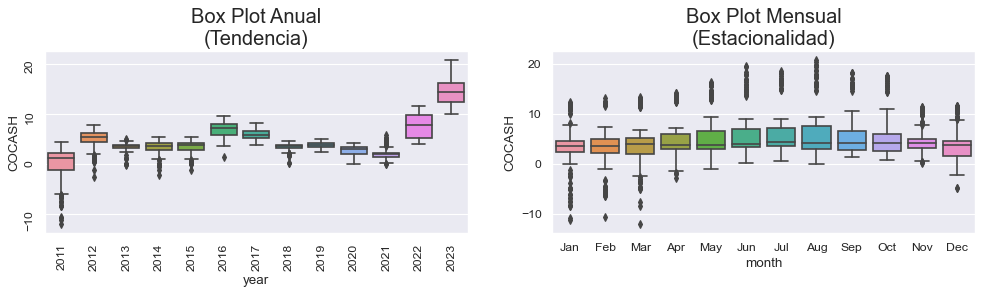

In [27]:
for col in data.columns:
    if (col != 'day' and col != 'month' and col != 'year'):
        fig, axes = plt.subplots(1, 2, figsize=(15,3), dpi= 80)
        sns.boxplot(x='year', y= data[col], data=data, ax=axes[0])
        sns.boxplot(x='month', y= data[col], data=data.loc[~data.year.isin([1986, 2019]), :])
        axes[0].set_title('Box Plot Anual\n(Tendencia)', fontsize=18); 
        axes[1].set_title('Box Plot Mensual\n(Estacionalidad)', fontsize=18)
        axes[0].tick_params(labelrotation=90)
        plt.show()

Con las pruebas y gráficos anteriores es posible identificar que las series de los precios no son estacionarias.

## Análisis Exploratorio de Retornos

En este análisis descriptivo se observa que la media de los retornos de todos los activos se encuentra alrededor del 0%. En este caso, el S&P 500 es el activo con el mayor retorno (0.0004%), mientras que el índice ILF es el activo con el menor (-0.0002%). 

In [28]:
# Estadística descriptiva
stats_r = data_r.describe().round(4)
stats_r

RSPX       REEM       RXAU    RUSTTEN    RUSCASH    RUSDCOP  \
count  3343.0000  3343.0000  3343.0000  3343.0000  3343.0000  3343.0000   
mean      0.0004    -0.0001     0.0001     0.0000     0.0000     0.0001   
std       0.0109     0.0135     0.0095     0.0043     0.0000     0.0080   
min      -0.1277    -0.1333    -0.0951    -0.0300     0.0000    -0.0426   
25%      -0.0037    -0.0071    -0.0047    -0.0026     0.0000    -0.0038   
50%       0.0003     0.0000     0.0003     0.0001     0.0000    -0.0001   
75%       0.0053     0.0074     0.0051     0.0025     0.0000     0.0041   
max       0.0897     0.0775     0.0497     0.0239     0.0001     0.0610   

         RCOCASH  
count  3343.0000  
mean      0.0001  
std       0.0001  
min      -0.0003  
25%       0.0001  
50%       0.0001  
75%       0.0002  
max       0.0006

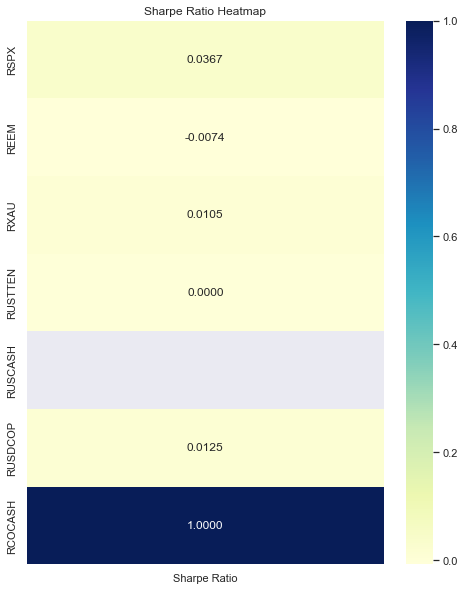

In [29]:
# Cálculo del sharpe ratio para todos los activos

stats_rt = stats_r.transpose()
stats_rt['Sharpe Ratio'] = (stats_rt['mean']/ stats_rt['std'])
sharpe_ratio_df = pd.DataFrame(stats_rt['Sharpe Ratio'])
plt.figure(figsize=(8, 10))
sns.heatmap(sharpe_ratio_df, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title('Sharpe Ratio Heatmap')
plt.show()

Como se puede ver en el mapa de calor anterior, el activo que mejor retorno ajustado por riesgo ofrece es el S&P 500, seguido por el USDCOP, el Topix y el DXY. Por su lado, los bonos del tesoro de Estados Unidos tienen un sharpe ratio de 0, al tener un retorno  promedio del 0%.

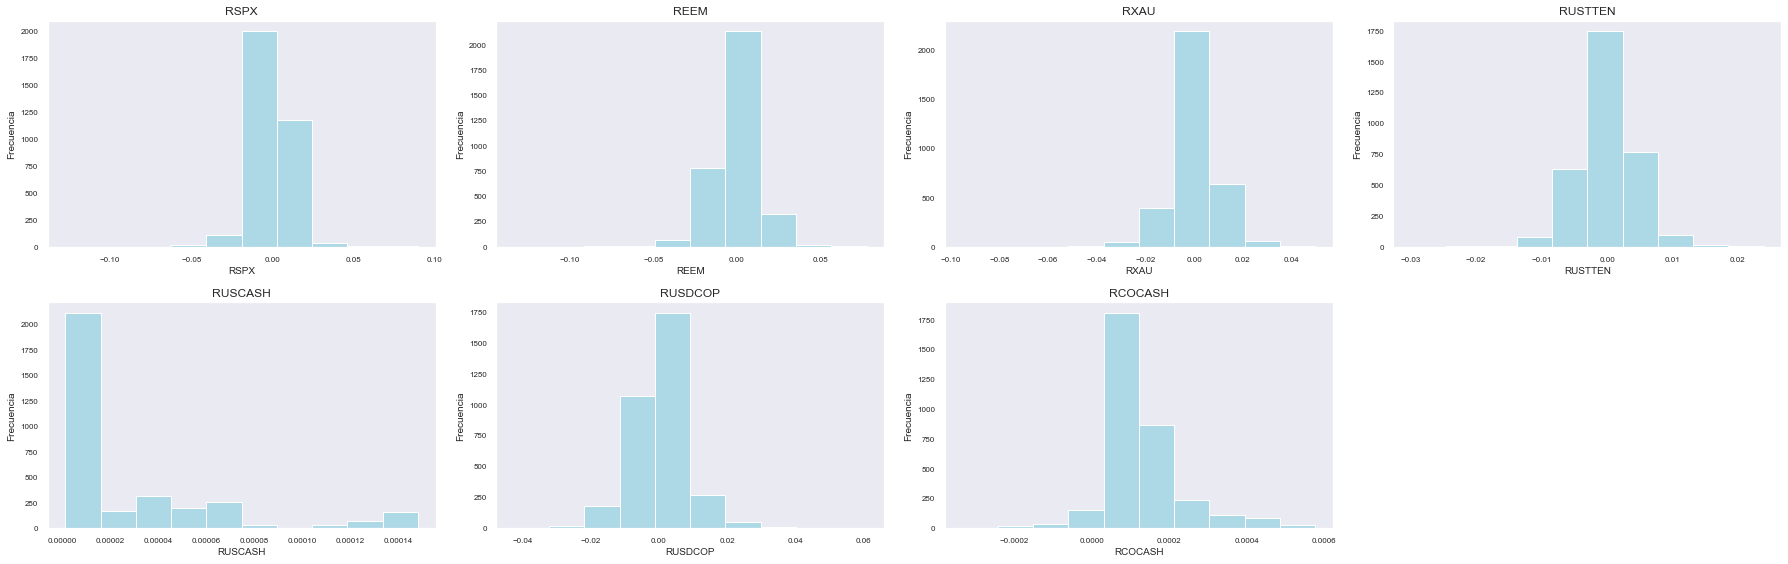

In [30]:
# Histogramas
sns.set_style("dark")

fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8))

for i, column in enumerate(data_r.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    ax.hist(data_r[column], color = "lightblue", ec="white")
    ax.set_title(column, fontsize=12)
    ax.set_xlabel(column, fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='both', labelsize=8)

specific_positions = [(1, 3)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

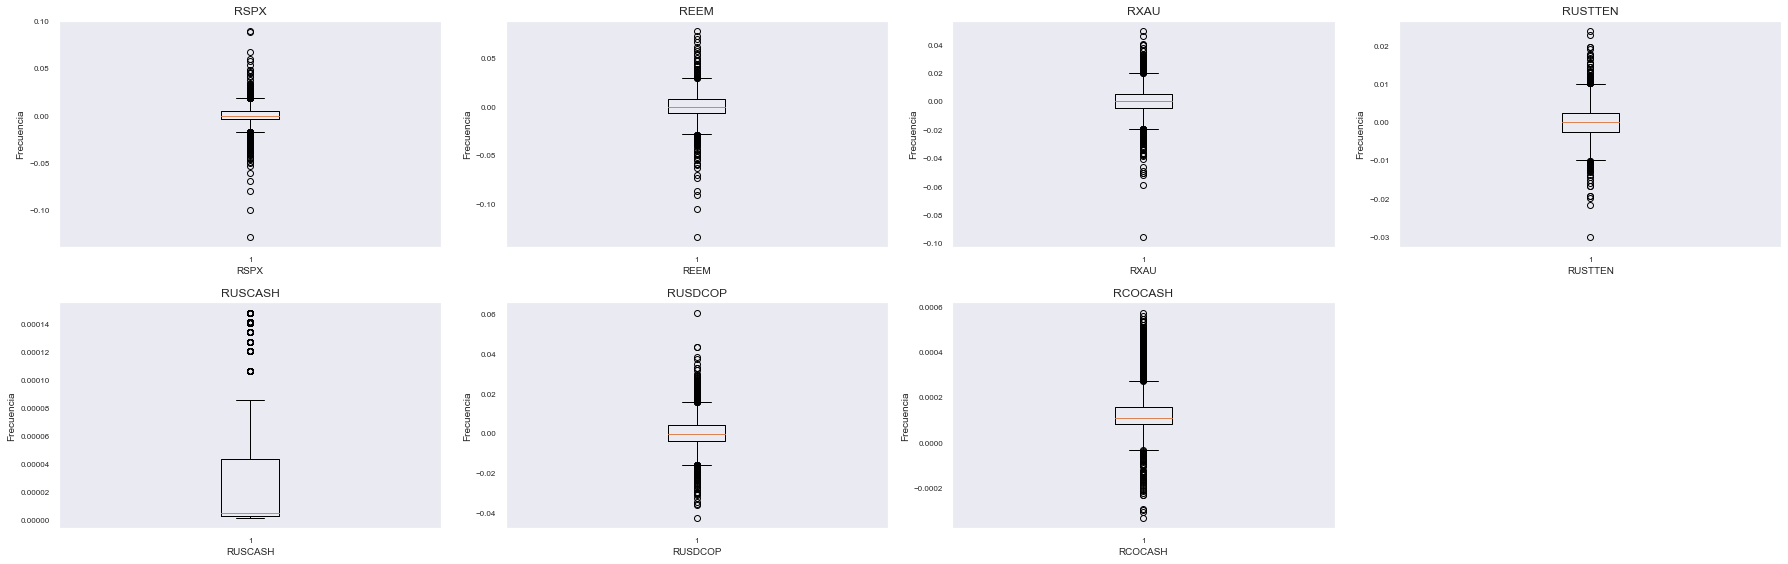

In [31]:
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8))

for i, column in enumerate(data_r.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    ax.boxplot(data_r[column])
    ax.set_title(column, fontsize=12)
    ax.set_xlabel(column, fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='both', labelsize=8)

specific_positions = [(1, 3)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

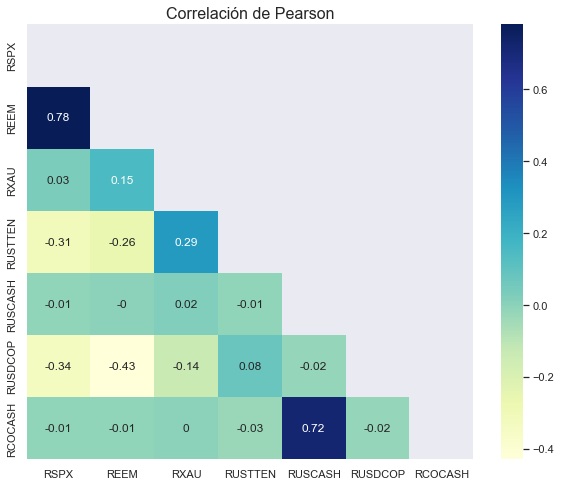

In [32]:
#Correlación de Pearson
plt.figure(figsize = (10,8))
sns.set(font_scale=1)
corr_df = data_r.corr(method='pearson').round(2)
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_df,annot=True,cmap='YlGnBu',annot_kws={"size":12}, square = False, mask = mask, alpha = 1)
plt.title('Correlación de Pearson', fontsize=16)
plt.show()

### Detección de Outliers

In [33]:
df_outliers_r = data_r.apply(lambda col: zscore(col, window=100), axis=0)
for col in df_outliers_r.columns:
    false_p_r = ((1-((df_outliers_r[col] == True).sum() / len(df_outliers_r))) * 100).round(2)
    print(f'{col} tiene {false_p_r}% de outliers')  

RSPX tiene 4.79% de outliers
REEM tiene 4.67% de outliers
RXAU tiene 5.44% de outliers
RUSTTEN tiene 4.37% de outliers
RUSCASH tiene 1.76% de outliers
RUSDCOP tiene 5.41% de outliers
RCOCASH tiene 2.78% de outliers


### Estacioneriedad

c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


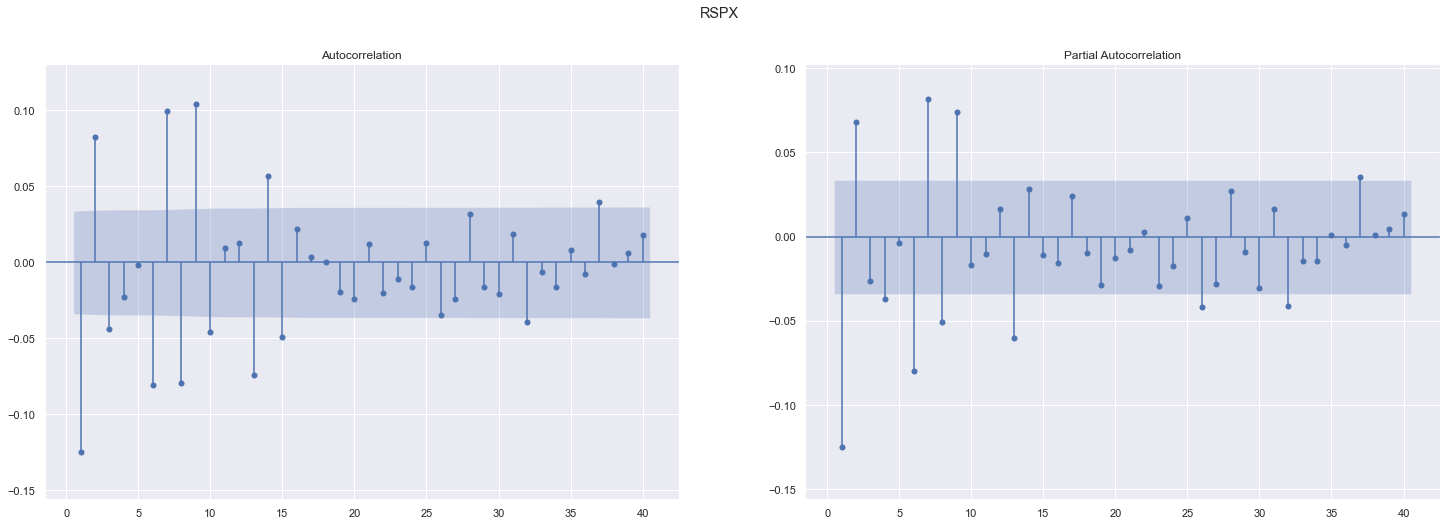

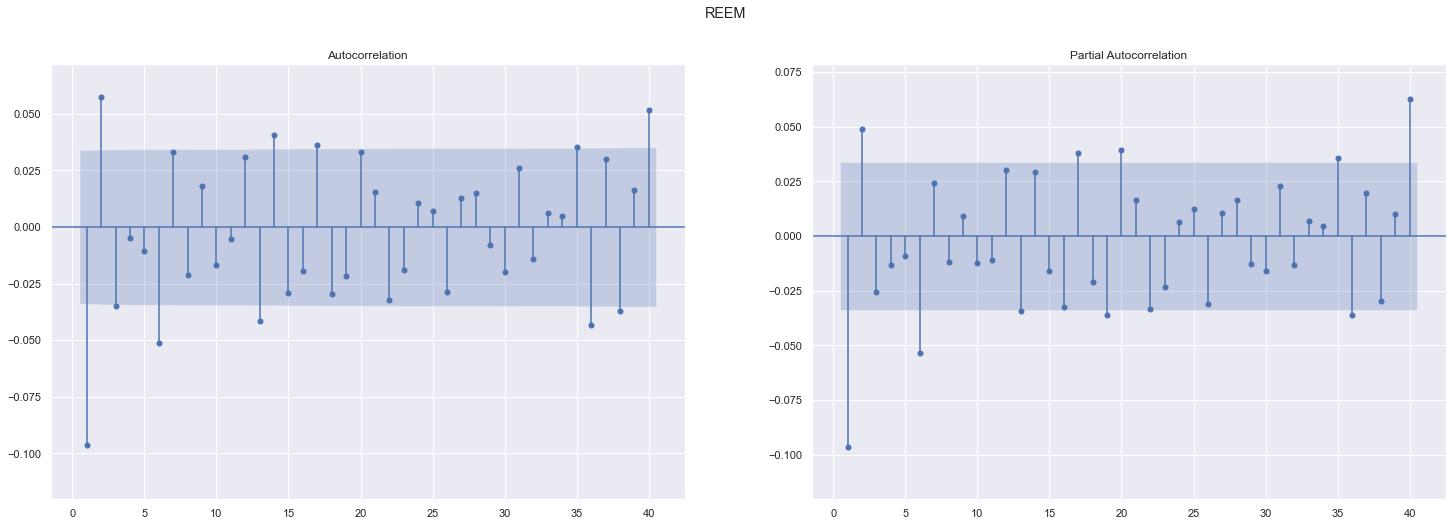

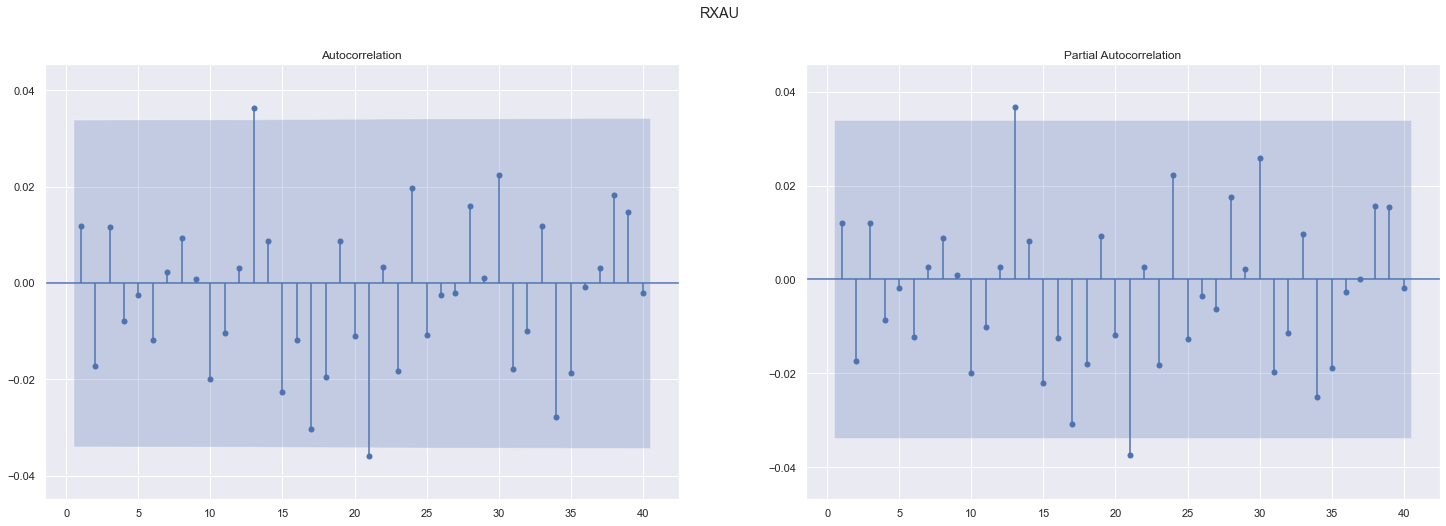

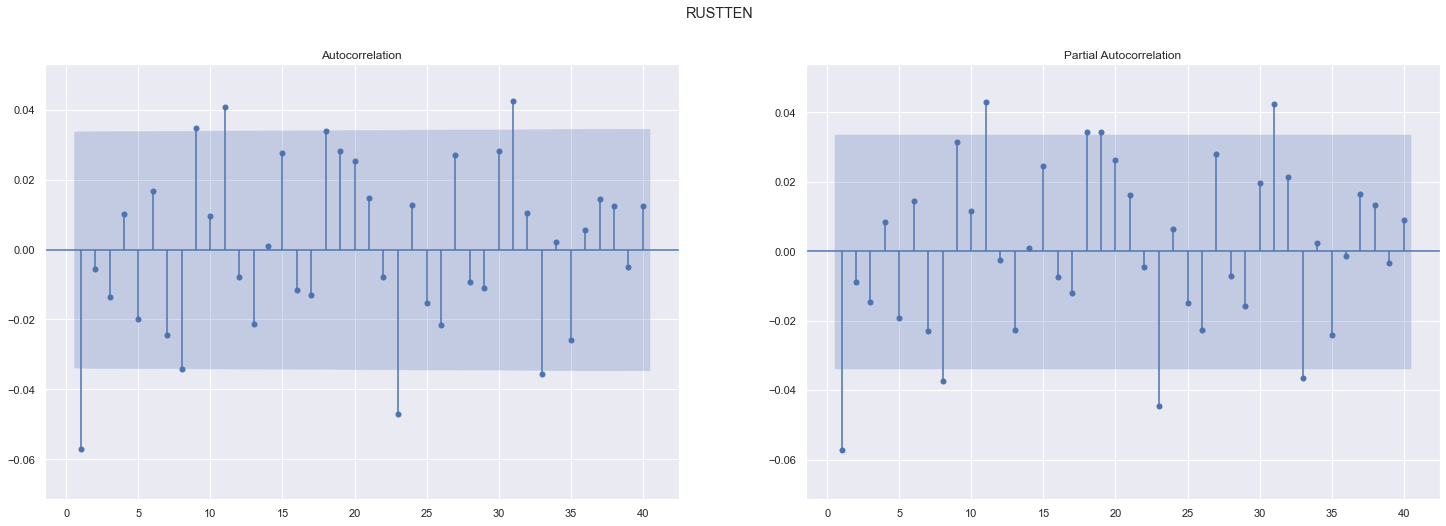

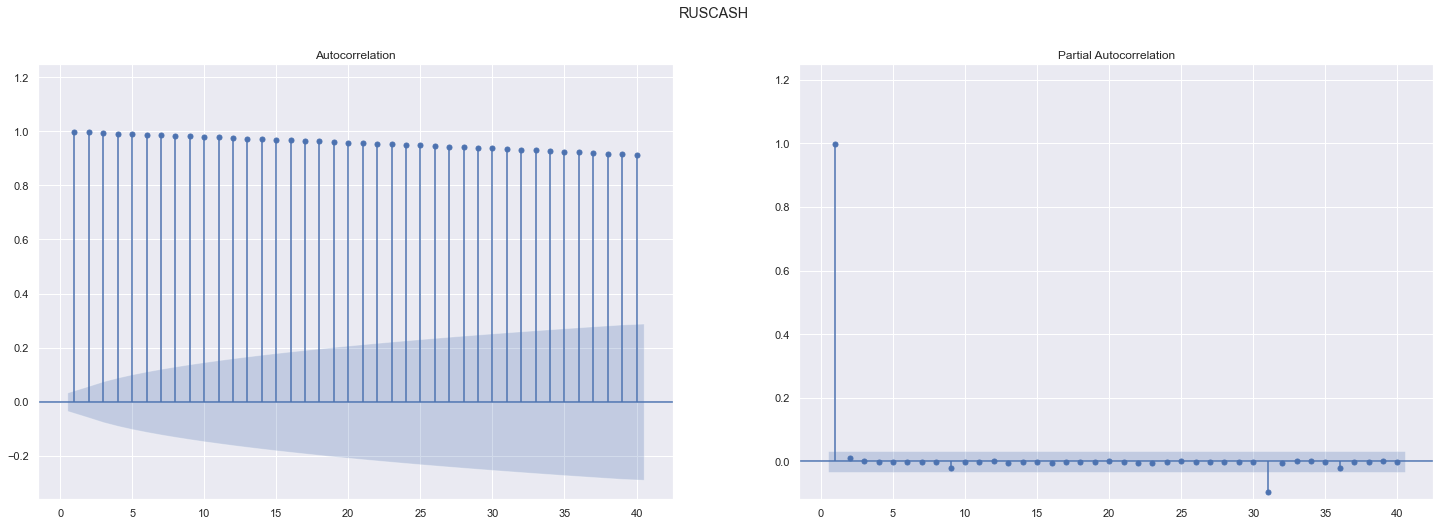

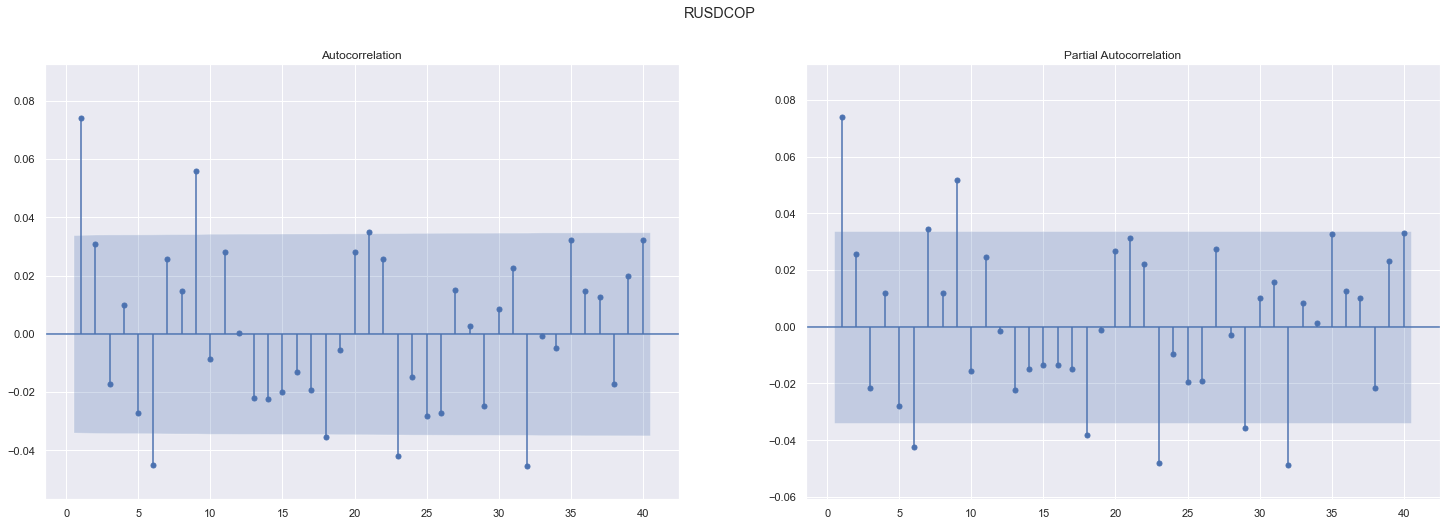

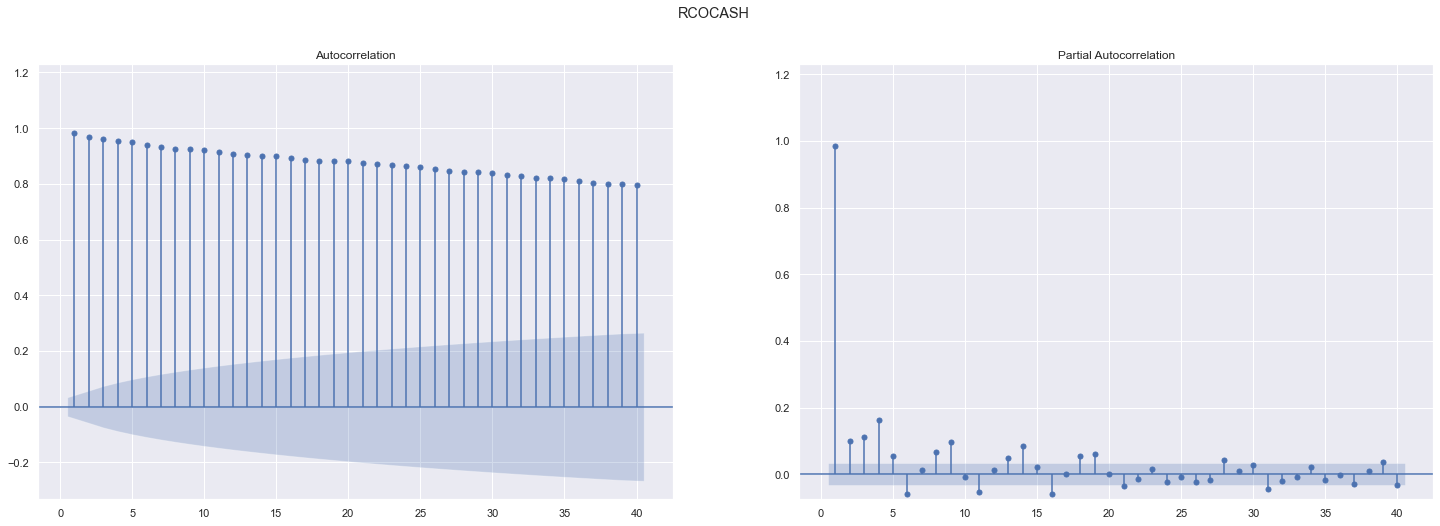

In [34]:
for col in data_r.columns:
    plot_acf_pacf(data_r[col], col)

In [35]:
for col in data_r.columns:
    result = sm.tsa.adfuller(data_r[col])
    # # Print the ADF test results in a user-friendly format
    # print("Augmented Dickey-Fuller Test Results:")
    # print(f"ADF Statistic: {result[0]}")
    # print(f"P-value: {result[1]}")
    # print("Critical Values:")
    # for key, value in result[4].items():
    #     print(f"  {key}: {value}")
    # Interpret the results
    if result[1] <= 0.05:
        print_colored(f"{col} series is likely stationary.", 'green')
    else:
        print_colored(f"{col} series is likely non-stationary.", 'red')

RSPX series is likely stationary.
REEM series is likely stationary.
RXAU series is likely stationary.
RUSTTEN series is likely stationary.
RUSCASH series is likely non-stationary.
RUSDCOP series is likely stationary.
RCOCASH series is likely non-stationary.


In [36]:
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

for col in data_r.columns:
    if (col != 'day' and col != 'month' and col != 'year'):
        # # Perform the KPSS test
        result_kpss = kpss(data_r[col], regression='c')
        
        # # Print the KPSS test results in a user-friendly format
        # print("\nKPSS Test Results for", col, "series:")
        # print('KPSS Statistic:', result_kpss[0])
        #print('p-value:', result_kpss[1])
        # print('Critical Values:')
        
        # for key, value in result_kpss[3].items():
        #     print(f'  {key}: {value}')
        
        # # Interpret the results
        if result_kpss[1] > 0.05:
            print_colored(f"{col} series is likely stationary.", 'green')
        else:
            print_colored(f"{col} series is likely non-stationary.", 'red')

RSPX series is likely stationary.
REEM series is likely stationary.
RXAU series is likely stationary.
RUSTTEN series is likely non-stationary.
RUSCASH series is likely non-stationary.
RUSDCOP series is likely stationary.
RCOCASH series is likely non-stationary.


In [37]:
data2 = data_r

# Prepare data
data2['year'] = [d.year for d in data2.index]
data2['month'] = [d.strftime('%b') for d in data2.index]
data2['day'] = [d.strftime('%d') for d in data2.index]
years = data2['year'].unique()

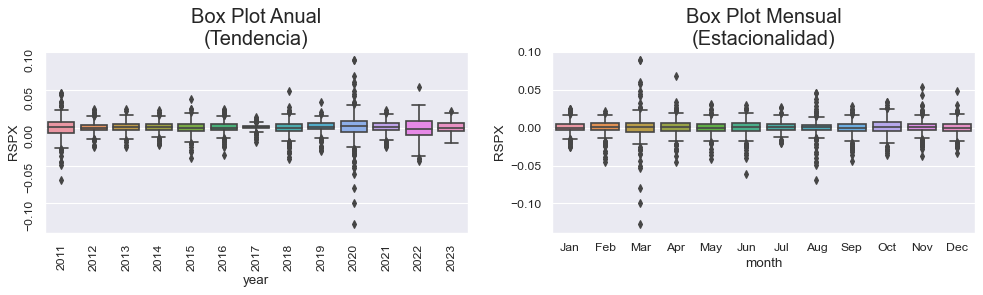

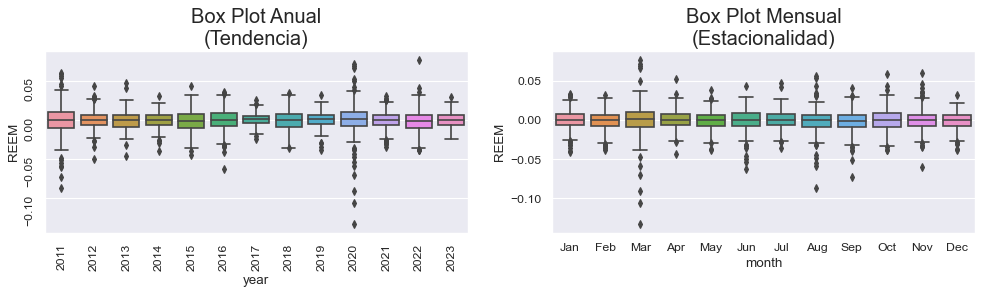

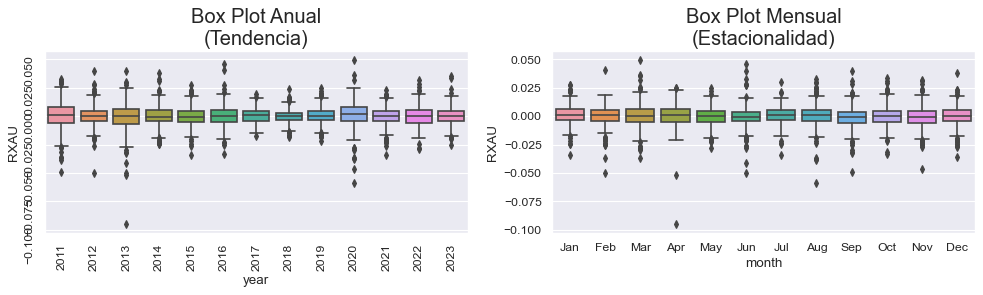

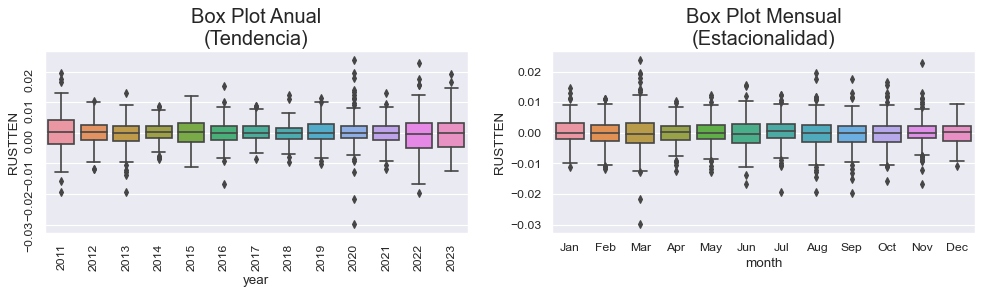

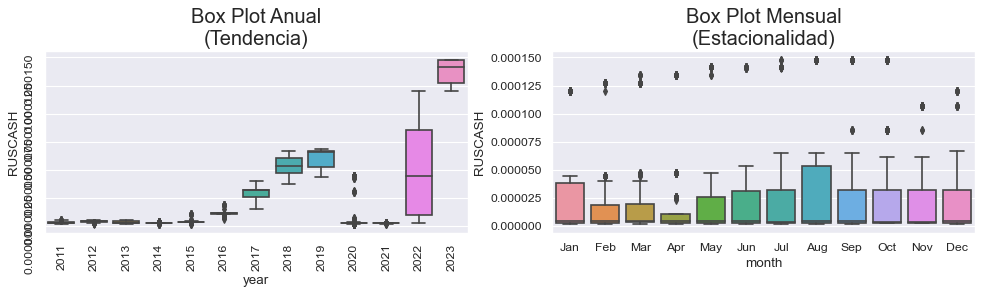

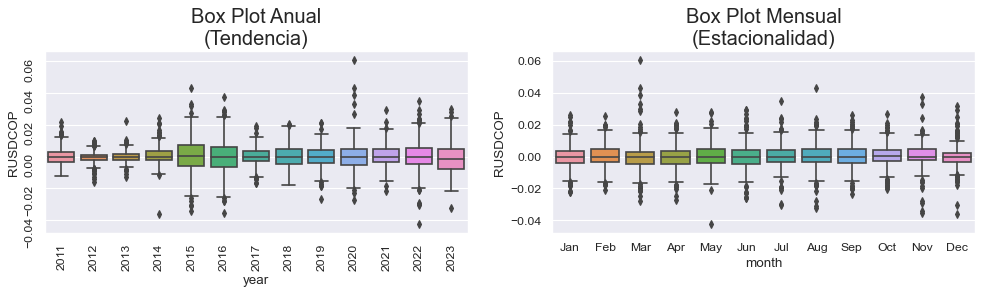

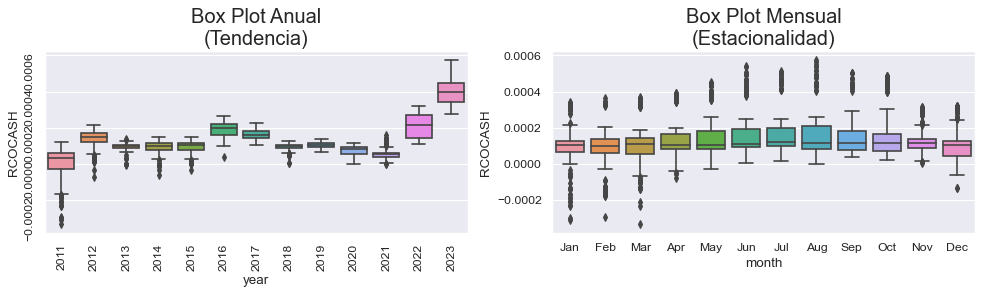

In [38]:
for col in data_r.columns:
    if (col != 'day' and col != 'month' and col != 'year'):
        fig, axes = plt.subplots(1, 2, figsize=(15,3), dpi= 80)
        sns.boxplot(x='year', y= data_r[col], data=data_r, ax=axes[0])
        sns.boxplot(x='month', y= data_r[col], data=data_r.loc[~data_r.year.isin([1986, 2019]), :])
        axes[0].set_title('Box Plot Anual\n(Tendencia)', fontsize=18); 
        axes[1].set_title('Box Plot Mensual\n(Estacionalidad)', fontsize=18)
        axes[0].tick_params(labelrotation=90)
        plt.show()

# Datos Semanales

In [39]:
dataw = data.resample('W-Wed').last().ffill().dropna(axis=0).drop(['year', 'month', 'day'], axis = 1)
dataw.head()

SPX    EEM      XAU      USTTEN  USCASH   USDCOP     COCASH
date                                                                       
2011-01-05  1276.56  48.20  1378.25   98.927393    0.18  1881.00 -10.797201
2011-01-12  1285.96  48.21  1387.90   99.785731    0.16  1868.00  -6.852351
2011-01-19  1281.92  47.49  1369.86  100.041860    0.18  1841.40  -6.766071
2011-01-26  1296.63  46.97  1346.00   99.460731    0.17  1863.85  -3.767550
2011-02-02  1304.03  46.57  1335.25   98.993793    0.18  1858.00  -0.981350

In [40]:
(dataw.isna().sum(axis=0)/len(dataw)).sort_values(ascending = False)

SPX       0.0
EEM       0.0
XAU       0.0
USTTEN    0.0
USCASH    0.0
USDCOP    0.0
COCASH    0.0
dtype: float64

In [41]:
dataw.index = (pd.to_datetime(dataw.index, format='%d/%m/%Y'))

In [42]:
dataw.to_csv('data_semanal_activos.csv')

## Visualización de Datos Semanales Precios

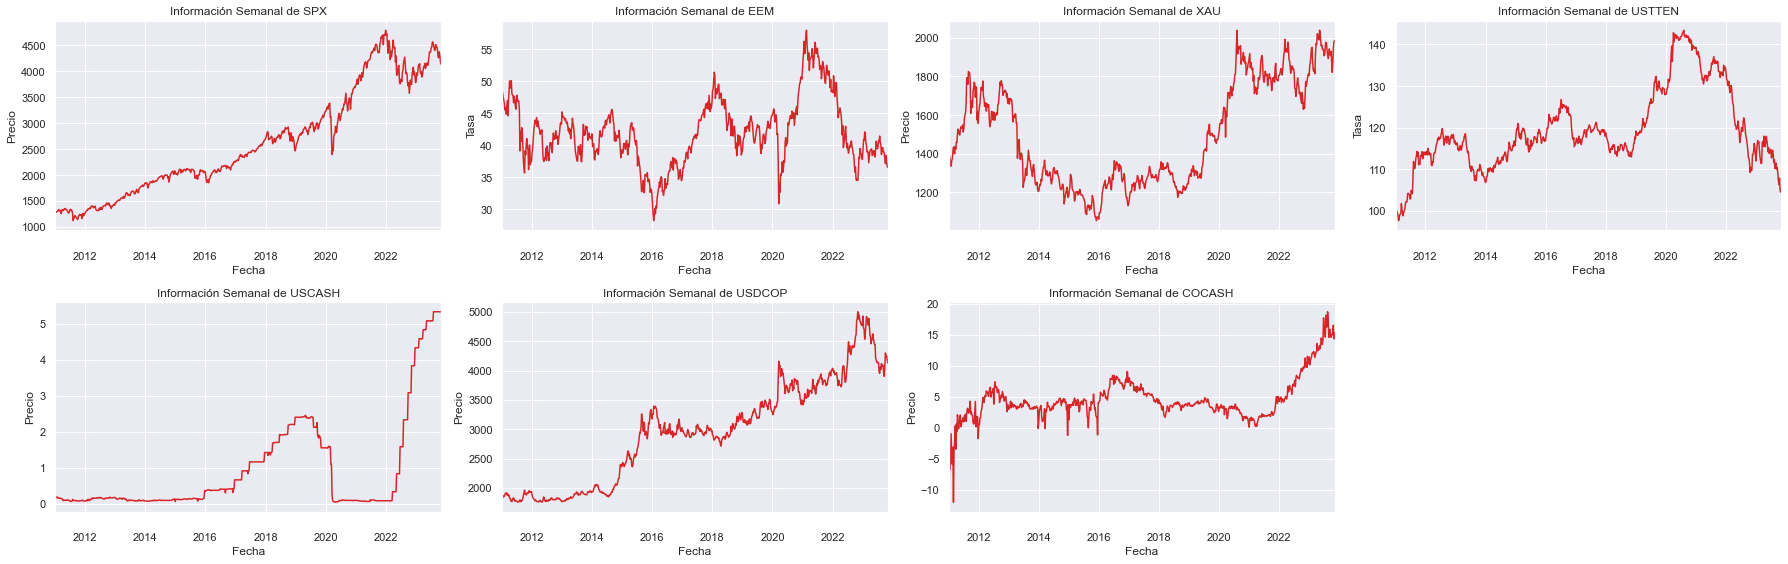

In [43]:
num_columns = min(4, len(dataw.columns)) 
num_rows = math.ceil(len(dataw.columns) / num_columns)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8))

for i, column in enumerate(dataw.columns):
    row = i // num_columns
    col = i % num_columns
    plot_df(dataw, x=dataw.index.values, y=dataw[column], title=f'Información Semanal de {column}', ax=axes[row, col])

rate_positions =[(0,1), (0,3)]

for row, col in rate_positions:
    axes[row, col].set_ylabel('Tasa')
    
specific_positions = [(1, 3)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

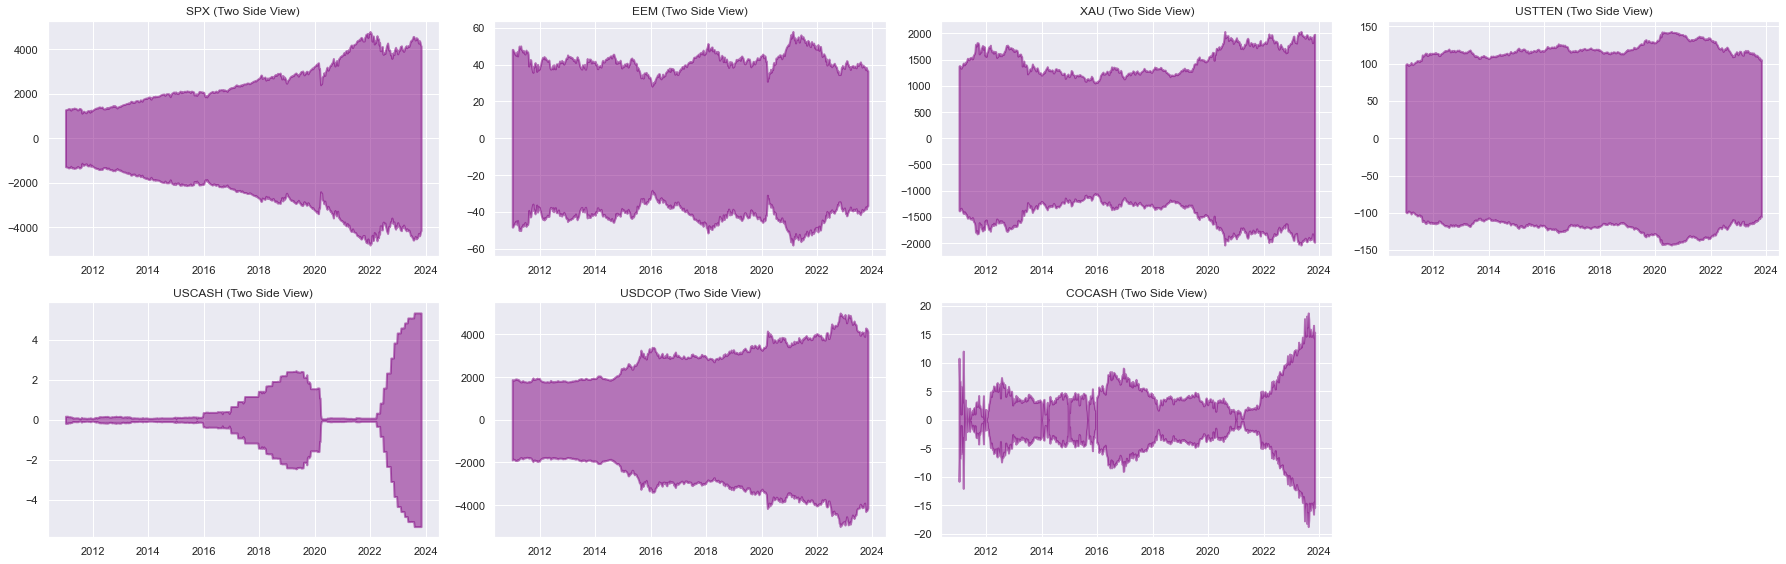

In [44]:
x = dataw.index.values

fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8))

for i, column in enumerate(dataw.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    y1 = dataw[column]
    ax.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color= 'purple')
    ax.set_title(f'{column} (Two Side View)', fontsize=12)

specific_positions = [(1, 3)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

## Análisis Exploratorio Precios Semanales

In [45]:
# Estadística descriptiva
stats = dataw.describe().round(2)
stats

SPX     EEM      XAU  USTTEN  USCASH   USDCOP  COCASH
count   670.00  670.00   670.00  670.00  670.00   670.00  670.00
mean   2619.25   42.02  1498.35  119.43    0.95  2951.82    4.55
std    1020.06    5.13   266.88    9.56    1.36   877.37    3.52
min    1120.76   28.25  1053.70   97.67    0.04  1756.60  -12.04
25%    1859.69   38.90  1266.70  113.95    0.09  1933.98    2.95
50%    2408.10   41.55  1426.22  117.37    0.16  2971.75    3.87
75%    3371.89   44.58  1749.30  123.25    1.55  3643.28    5.53
max    4793.06   57.96  2038.97  143.40    5.33  5003.00   18.74

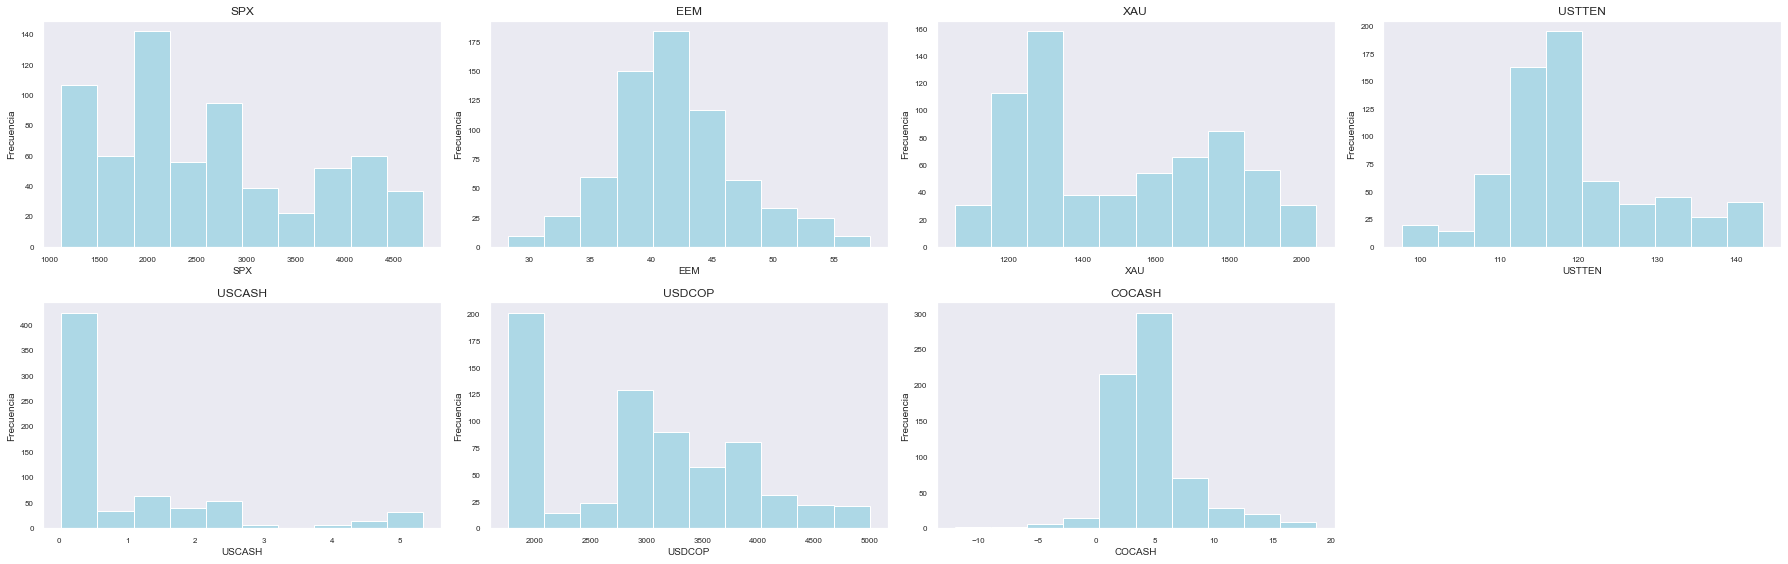

In [46]:
# Histogramas
sns.set_style("dark")
num_columns = min(4, len(dataw.columns)) 
num_rows = math.ceil(len(dataw.columns) / num_columns)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8))

for i, column in enumerate(dataw.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    ax.hist(dataw[column], color = "lightblue", ec="white")
    ax.set_title(column, fontsize=12)
    ax.set_xlabel(column, fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='both', labelsize=8)

specific_positions = [(1, 3)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

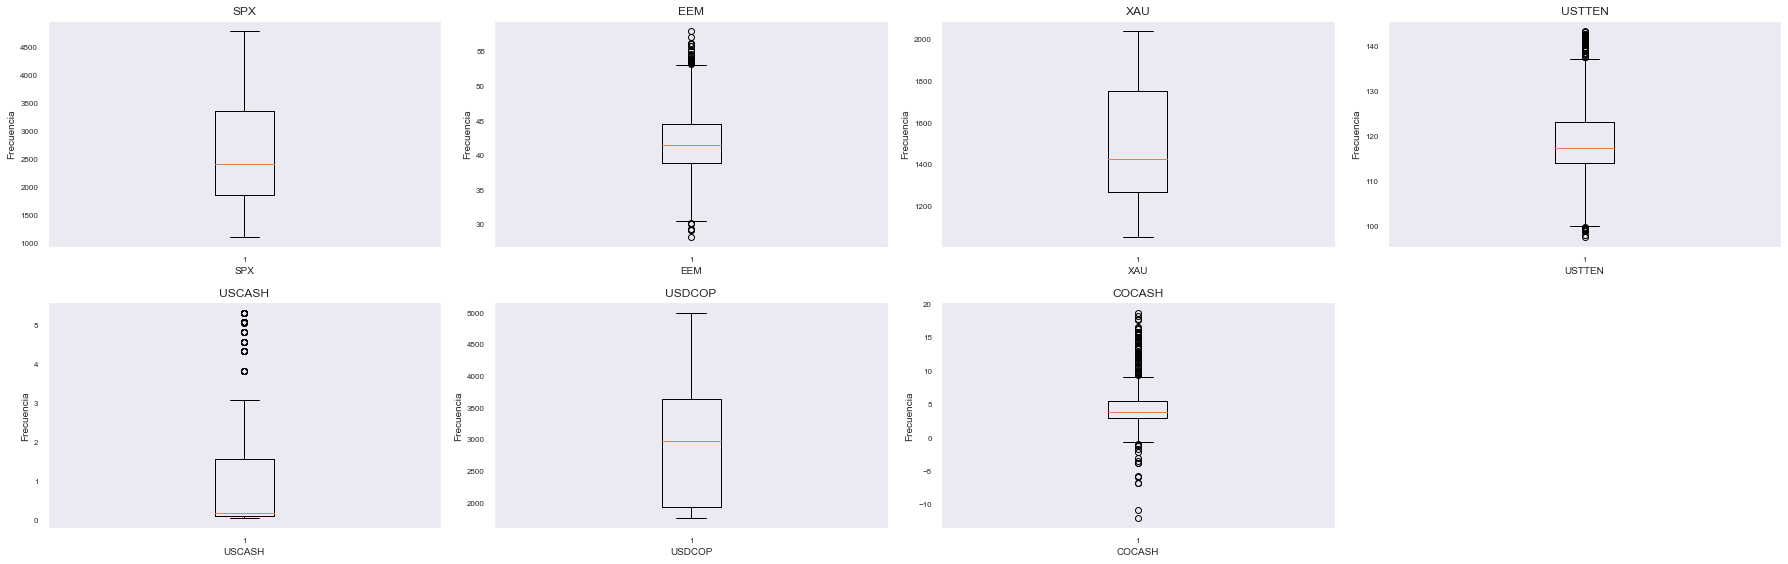

In [47]:
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 8))

for i, column in enumerate(dataw.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    ax.boxplot(dataw[column])
    ax.set_title(column, fontsize=12)
    ax.set_xlabel(column, fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='both', labelsize=8)

specific_positions = [(1, 3)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

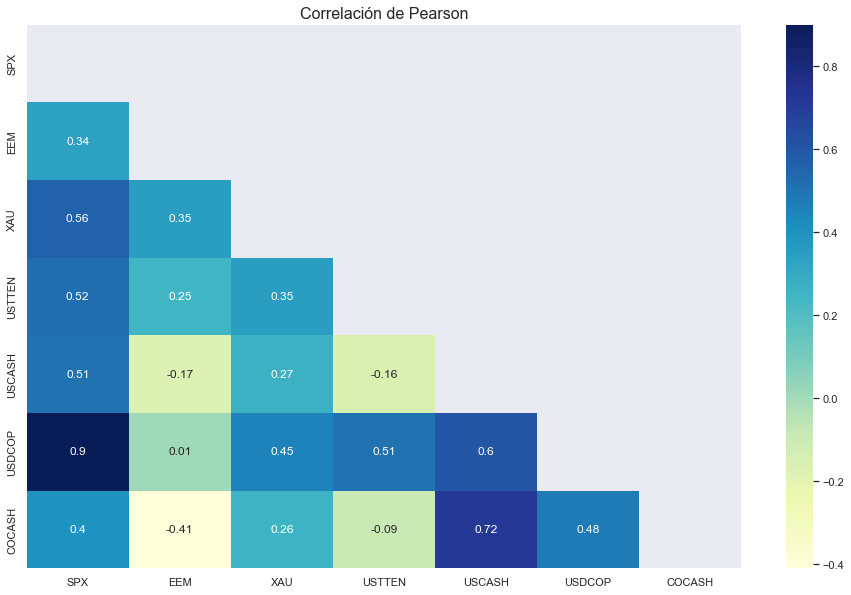

In [48]:
#Correlación de Pearson
plt.figure(figsize = (16,10))
sns.set(font_scale=1)
corr_df = dataw.corr(method='pearson').round(2)
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_df,annot=True,cmap='YlGnBu',annot_kws={"size":12}, square = False, mask = mask, alpha = 1)
plt.title('Correlación de Pearson', fontsize=16)
plt.show()

### Detección de Outliers Semanales

In [49]:
df_outliers = dataw.apply(lambda col: zscore(col, window=100), axis=0)
for col in df_outliers.columns:
    false_p = ((1-((df_outliers[col] == True).sum() / len(df_outliers))) * 100).round(2)
    print(f'{col} tiene {false_p}% de outliers')  

SPX tiene 2.39% de outliers
EEM tiene 1.49% de outliers
XAU tiene 1.19% de outliers
USTTEN tiene 0.75% de outliers
USCASH tiene 0.75% de outliers
USDCOP tiene 1.49% de outliers
COCASH tiene 2.99% de outliers


### Estacionariedad

c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


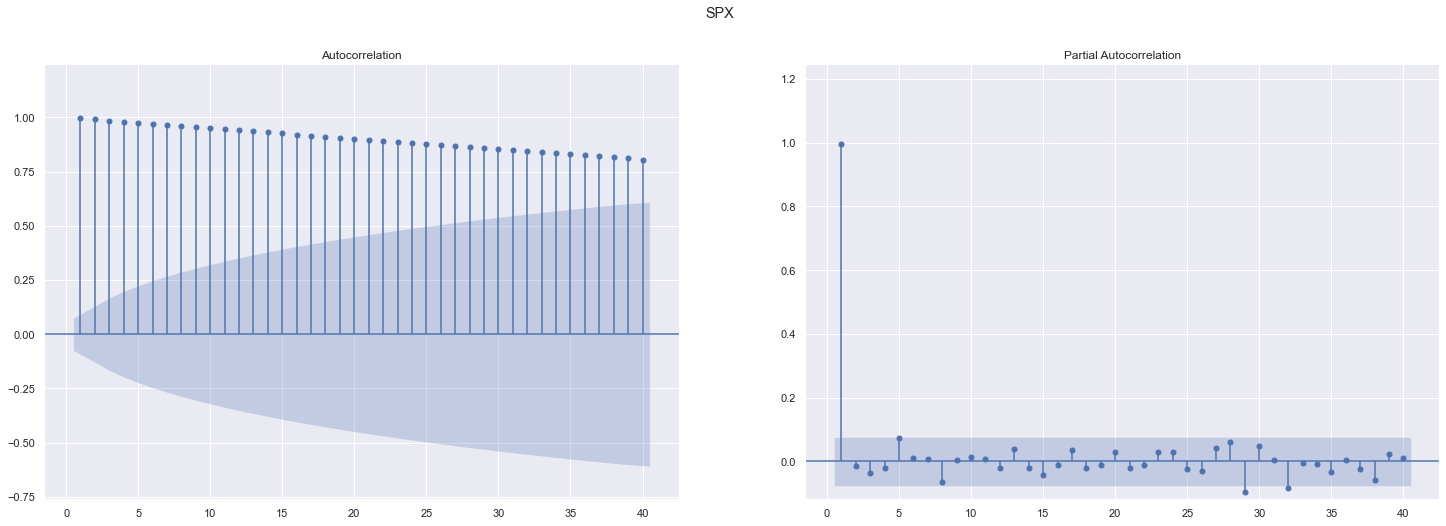

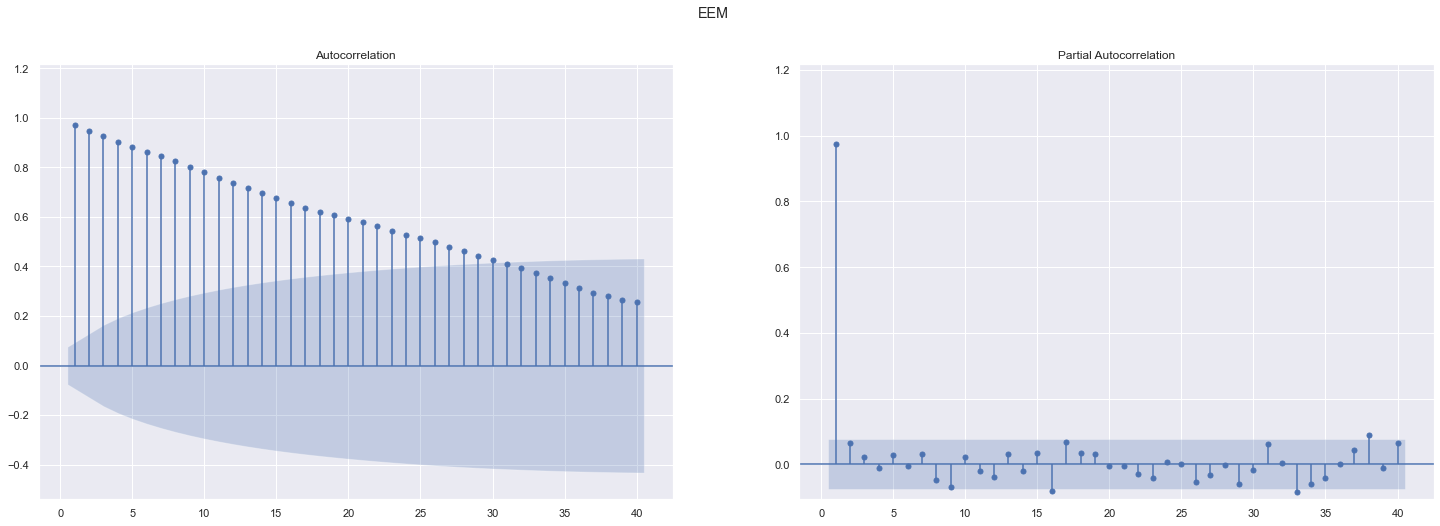

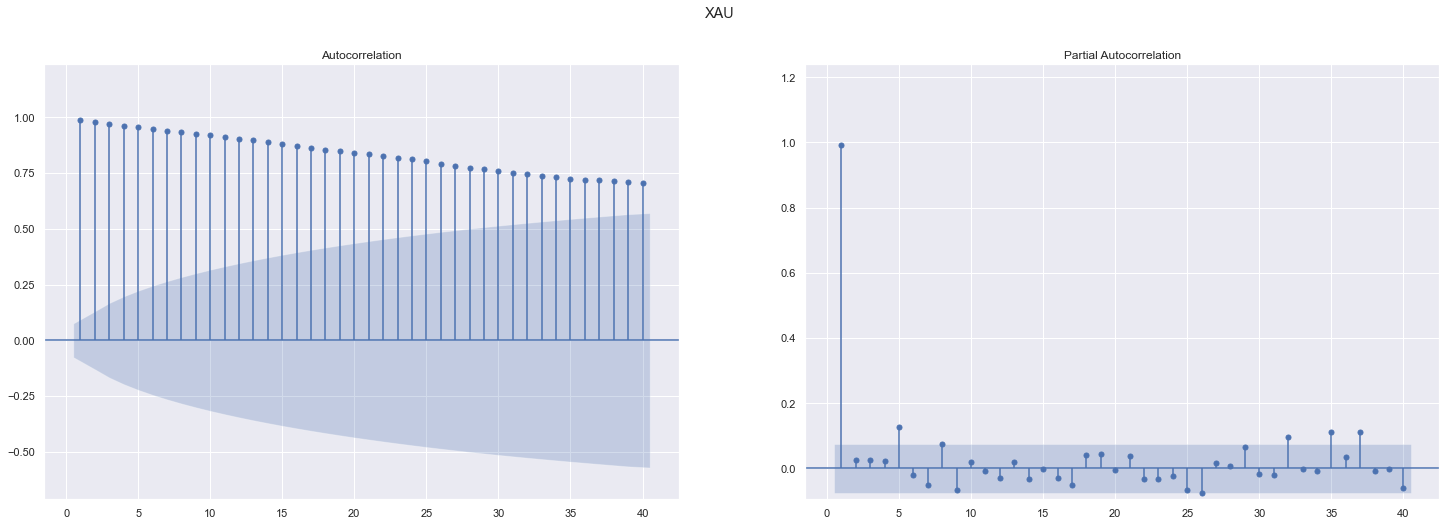

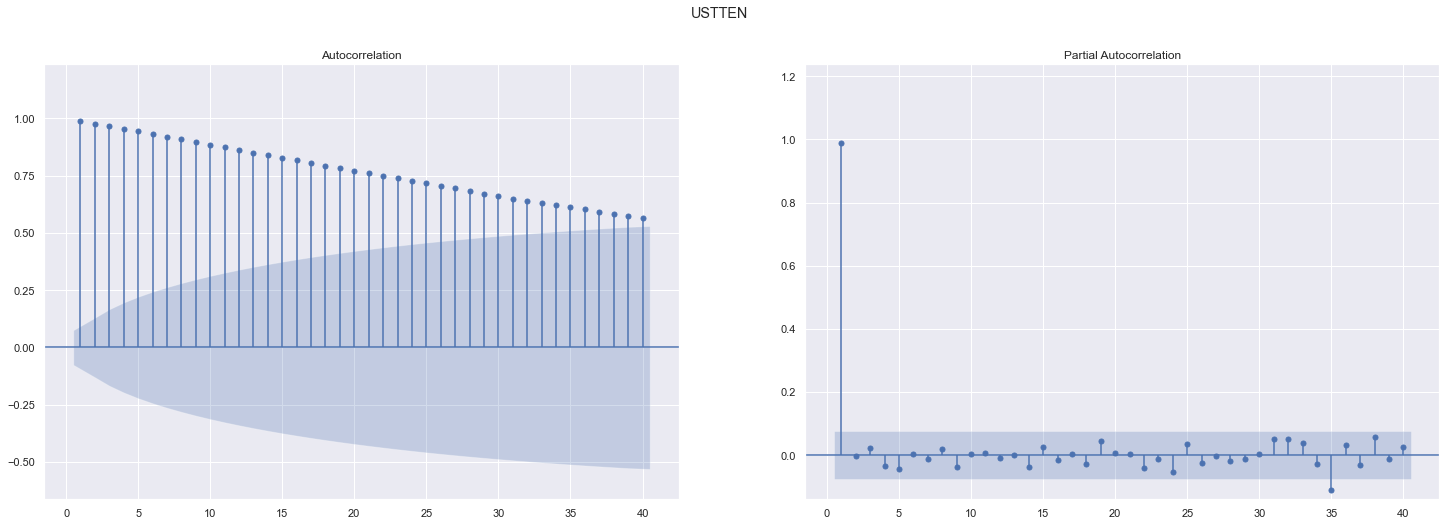

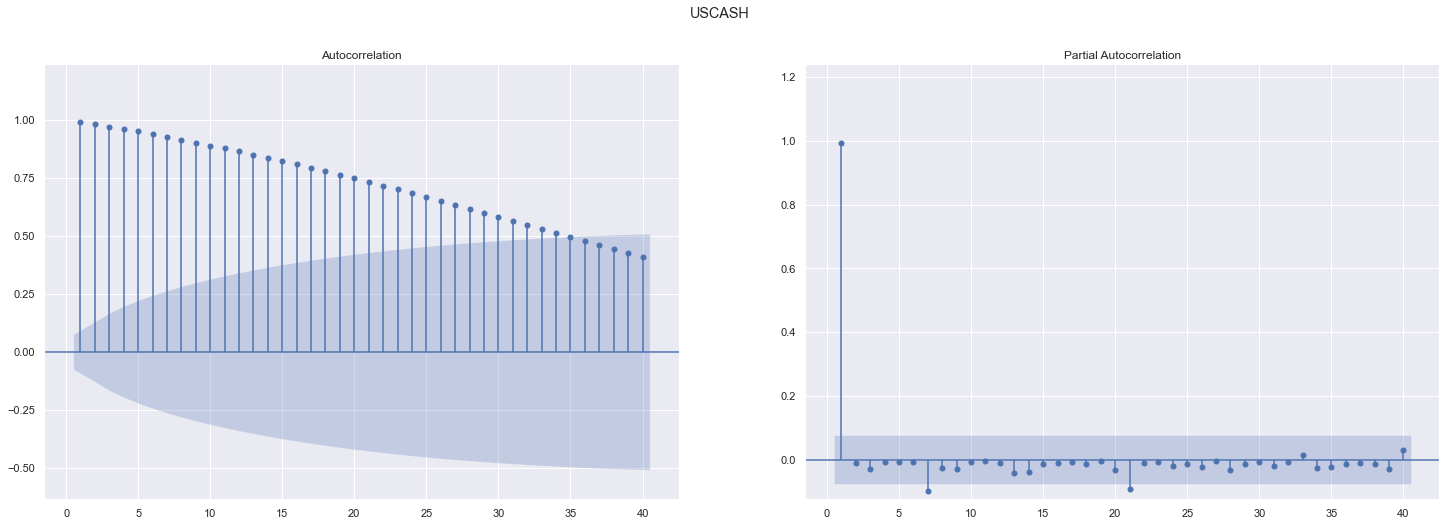

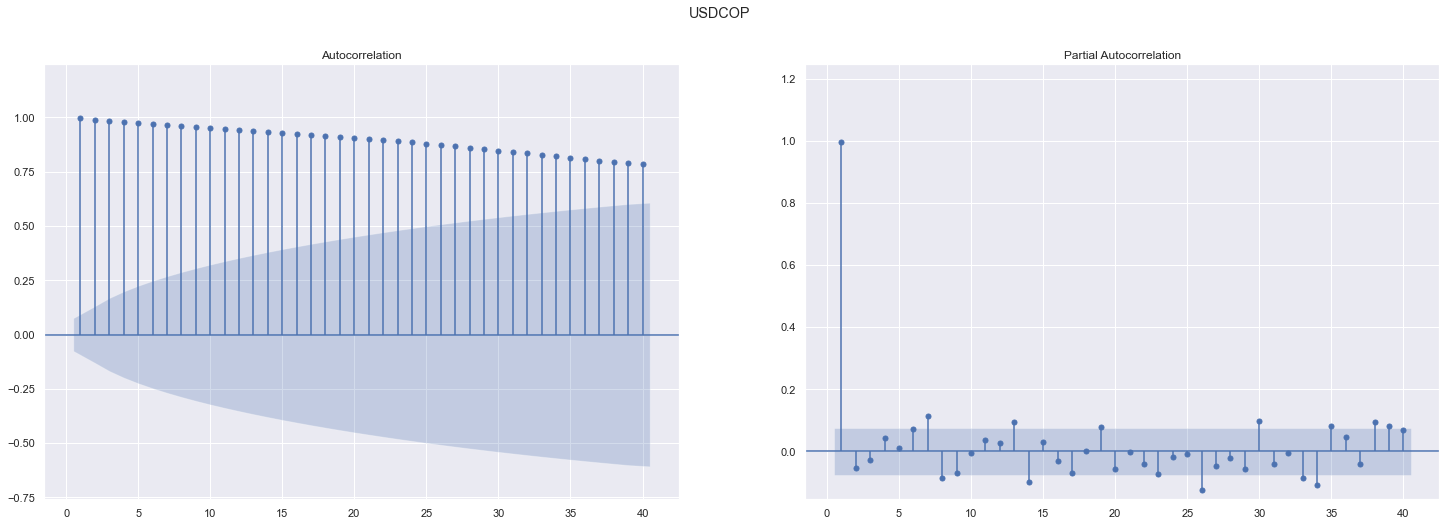

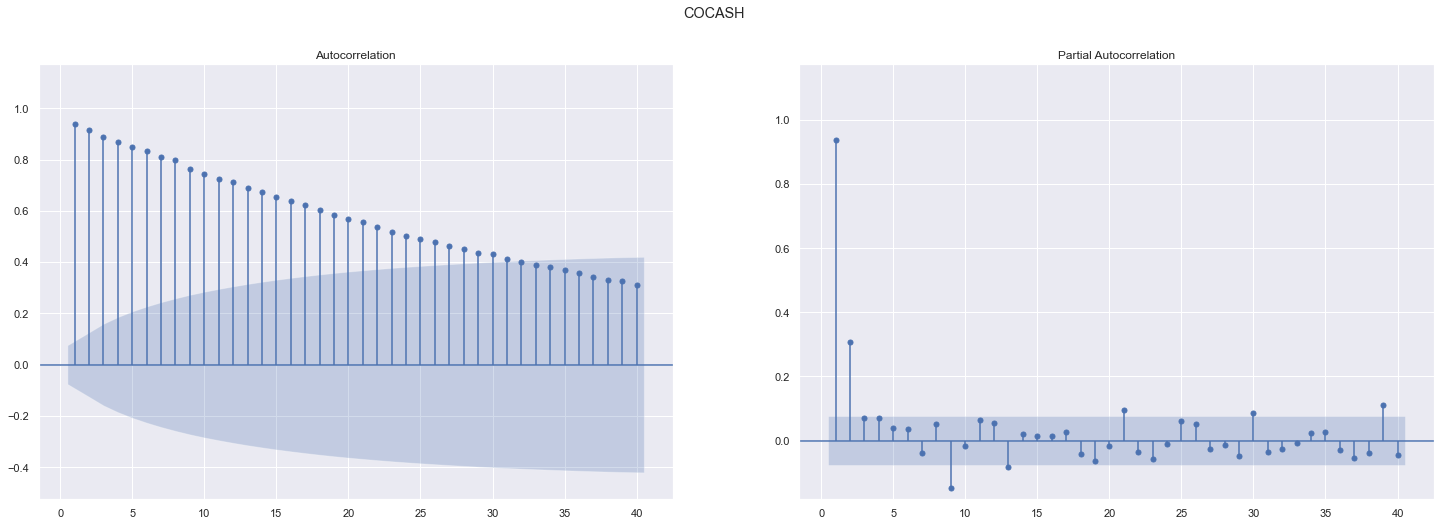

In [50]:
for col in dataw.columns:
    plot_acf_pacf(dataw[col], col)

In [51]:
for col in dataw.columns:
    result = sm.tsa.adfuller(dataw[col])
    # # Print the ADF test results in a user-friendly format
    # print("Augmented Dickey-Fuller Test Results:")
    # print(f"ADF Statistic: {result[0]}")
    # print(f"P-value: {result[1]}")
    # print("Critical Values:")
    # for key, value in result[4].items():
    #     print(f"  {key}: {value}")
    # Interpret the results
    if result[1] <= 0.05:
        print_colored(f"{col} series is likely stationary.", 'green')
    else:
        print_colored(f"{col} series is likely non-stationary.", 'red')

SPX series is likely non-stationary.
EEM series is likely non-stationary.
XAU series is likely non-stationary.
USTTEN series is likely non-stationary.
USCASH series is likely non-stationary.
USDCOP series is likely non-stationary.
COCASH series is likely non-stationary.


In [52]:
data2 = dataw

# Prepare data
data2['year'] = [d.year for d in data2.index]
data2['month'] = [d.strftime('%b') for d in data2.index]
data2['day'] = [d.strftime('%d') for d in data2.index]
years = data2['year'].unique()

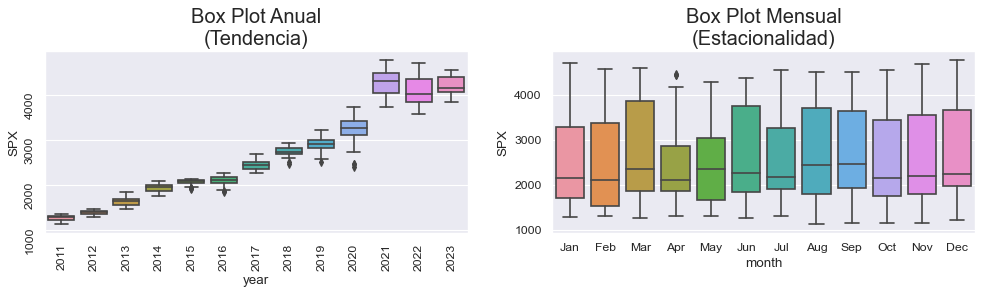

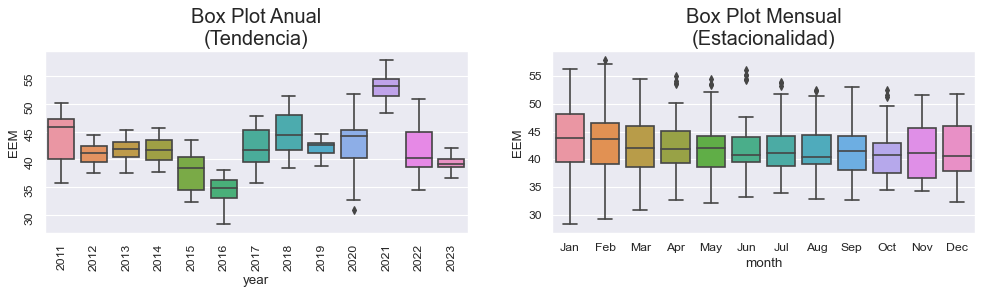

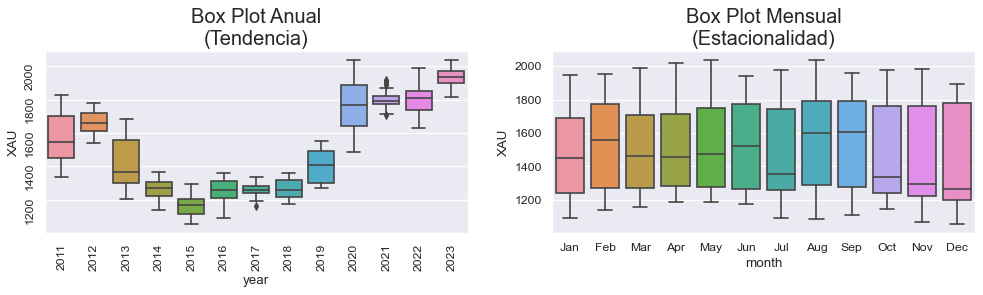

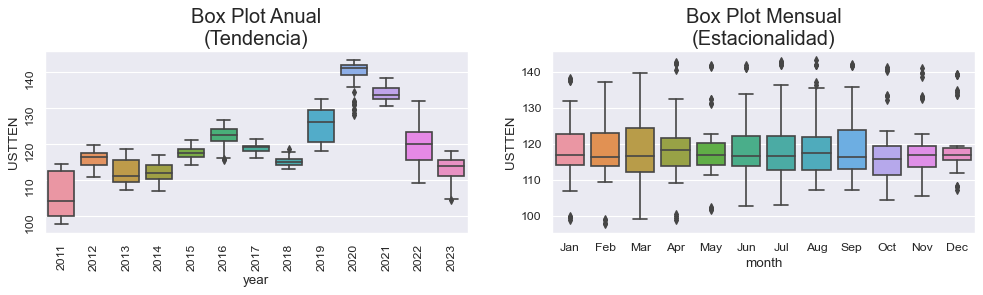

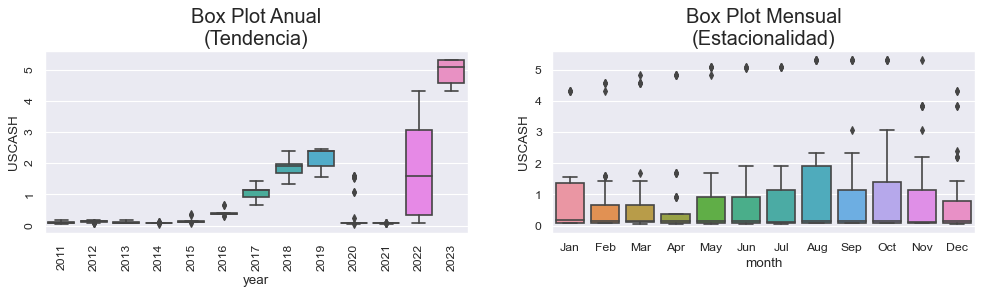

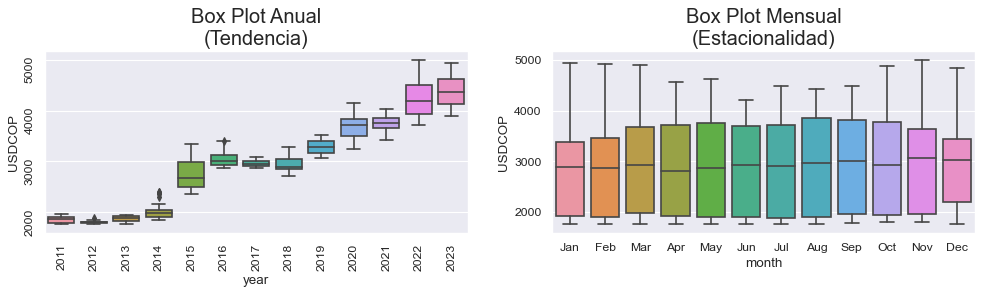

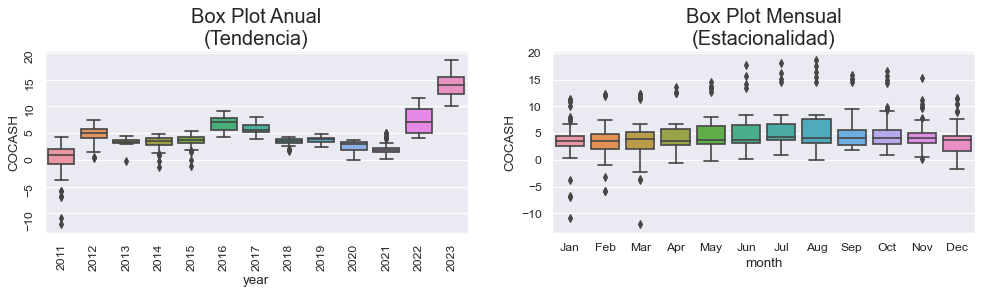

In [53]:
for col in dataw.columns:
    if (col != 'day' and col != 'month' and col != 'year'):
        fig, axes = plt.subplots(1, 2, figsize=(15,3), dpi= 80)
        sns.boxplot(x='year', y= dataw[col], data=dataw, ax=axes[0])
        sns.boxplot(x='month', y= dataw[col], data=dataw.loc[~dataw.year.isin([1986, 2019]), :])
        axes[0].set_title('Box Plot Anual\n(Tendencia)', fontsize=18); 
        axes[1].set_title('Box Plot Mensual\n(Estacionalidad)', fontsize=18)
        axes[0].tick_params(labelrotation=90)
        plt.show()

## Cálculo Retornos Datos Semanales

In [54]:
carry_s = data_r[['RUSCASH','RCOCASH']].rolling(7).sum()
dataw_ri = dataw.drop(['day', 'month', 'year', 'COCASH', 'USCASH'], axis = 1).apply(lambda col: np.log(col / col.shift(1)))
dataw_ri.columns = [f'R{col}' for col in dataw_ri.columns]
dataw_r= pd.merge(dataw_ri, carry_s, how='left', left_index=True, right_index=True)
dataw_r['RUSDCOP'] = dataw_r['RUSDCOP'] + (dataw_r['RUSCASH'] - dataw_r['RCOCASH'])
dataw_r.drop(['RUSCASH', 'RCOCASH'], axis=1, inplace=True)
dataw_r.head()

RSPX      REEM      RXAU   RUSTTEN   RUSDCOP
date                                                        
2011-01-05       NaN       NaN       NaN       NaN       NaN
2011-01-12  0.007337  0.000207  0.006977  0.008639 -0.005556
2011-01-19 -0.003147 -0.015047 -0.013083  0.002563 -0.012922
2011-01-26  0.011410 -0.011010 -0.017571 -0.005826  0.013263
2011-02-02  0.005691 -0.008553 -0.008019 -0.004706 -0.002637

In [55]:
(dataw_r.isna().sum(axis=0)/len(dataw_r)).sort_values(ascending = False)

RUSDCOP    0.002985
RSPX       0.001493
REEM       0.001493
RXAU       0.001493
RUSTTEN    0.001493
dtype: float64

In [56]:
dataw_r = dataw_r.dropna()
(dataw_r.isna().sum(axis=0)/len(dataw_r)).sort_values(ascending = False)

RSPX       0.0
REEM       0.0
RXAU       0.0
RUSTTEN    0.0
RUSDCOP    0.0
dtype: float64

In [57]:
dataw_r.index = (pd.to_datetime(dataw_r.index, format='%d/%m/%Y'))

In [58]:
dataw_r.to_csv('Activosw_r.csv')

## Visualización de Retornos Semanales

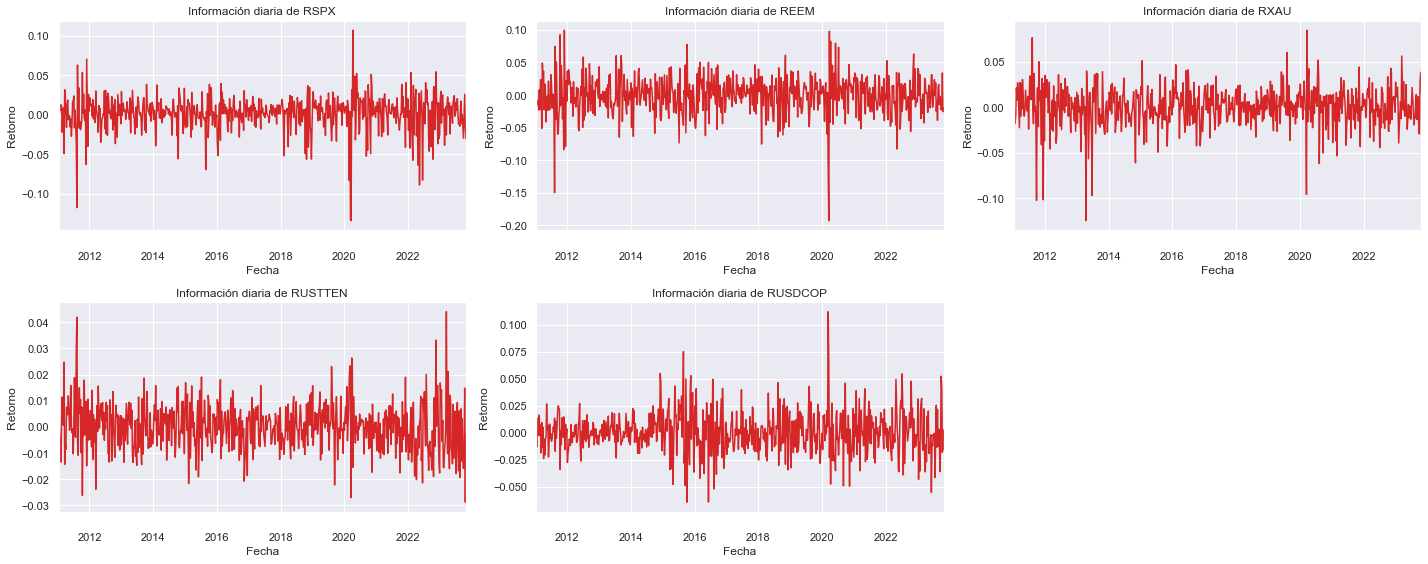

In [59]:

num_columns = min(3, len(dataw_r.columns)) 
num_rows = math.ceil(len(dataw_r.columns) / num_columns)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 8))

for i, column in enumerate(dataw_r.columns):
    row = i // num_columns
    col = i % num_columns
    plot_df(dataw_r, x=dataw_r.index.values, y=dataw_r[column], title=f'Información diaria de {column}', ax=axes[row, col])
    axes[row, col].set_ylabel('Retorno')

specific_positions = [(1, 2)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

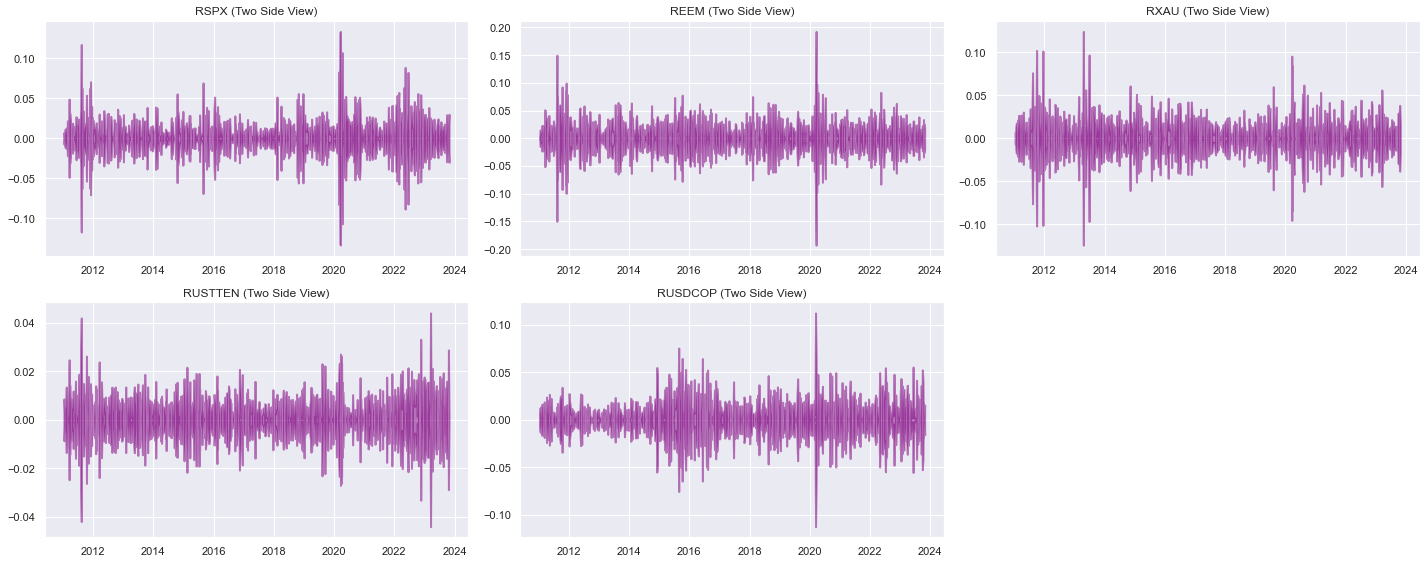

In [60]:
x = dataw_r.index.values

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 8))

for i, column in enumerate(dataw_r.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    y1 = dataw_r[column]
    ax.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color= 'purple')
    ax.set_title(f'{column} (Two Side View)', fontsize=12)

specific_positions = [(1, 2)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

## Análisis Exploratorio de Retornos Semanales

In [61]:
# Estadística descriptiva
statsw_r = dataw_r.describe().round(4)
statsw_r

RSPX      REEM      RXAU   RUSTTEN   RUSDCOP
count  668.0000  668.0000  668.0000  668.0000  668.0000
mean     0.0018   -0.0004    0.0005    0.0001    0.0005
std      0.0220    0.0289    0.0213    0.0090    0.0190
min     -0.1338   -0.1928   -0.1243   -0.0288   -0.0644
25%     -0.0063   -0.0172   -0.0105   -0.0060   -0.0103
50%      0.0041    0.0013    0.0011    0.0003   -0.0004
75%      0.0137    0.0167    0.0134    0.0053    0.0108
max      0.1072    0.0995    0.0844    0.0441    0.1122

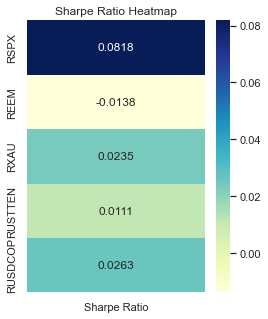

In [62]:
# Cálculo del sharpe ratio para todos los activos

statsw_rt = statsw_r.transpose()
statsw_rt['Sharpe Ratio'] = (statsw_rt['mean']/ statsw_rt['std'])
sharpe_ratio_df = pd.DataFrame(statsw_rt['Sharpe Ratio'])
plt.figure(figsize=(4, 5))
sns.heatmap(sharpe_ratio_df, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title('Sharpe Ratio Heatmap')
plt.show()

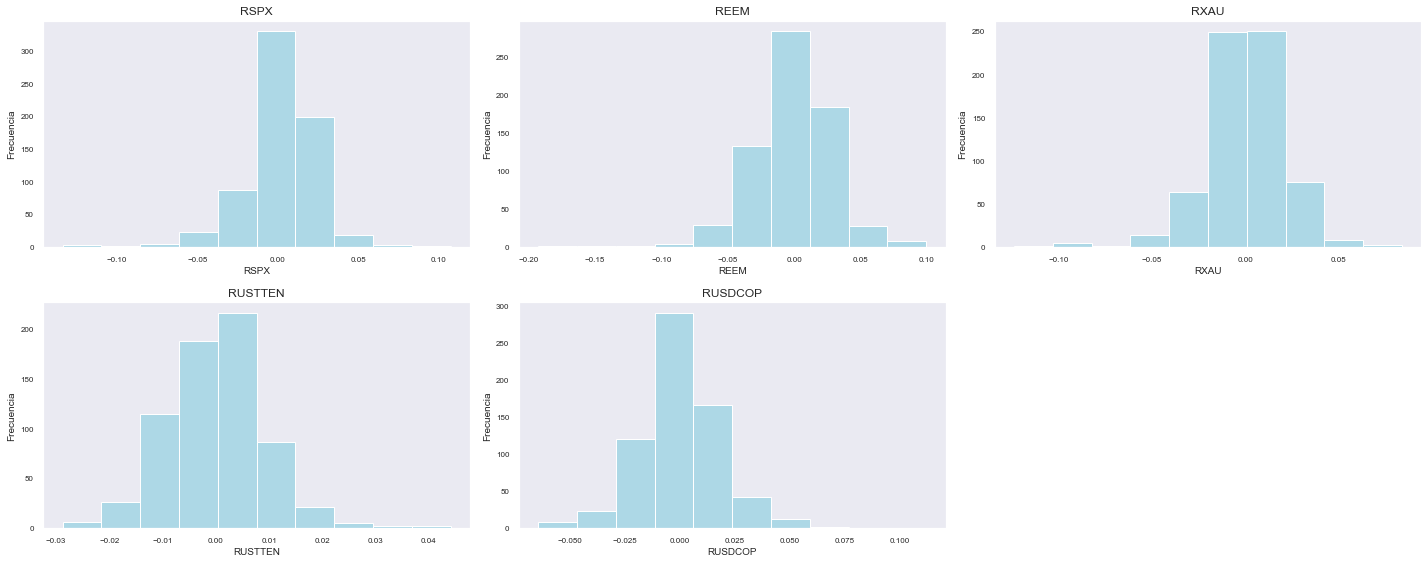

In [63]:
# Histogramas
sns.set_style("dark")

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 8))

for i, column in enumerate(dataw_r.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    ax.hist(dataw_r[column], color = "lightblue", ec="white")
    ax.set_title(column, fontsize=12)
    ax.set_xlabel(column, fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='both', labelsize=8)

specific_positions = [(1, 2)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

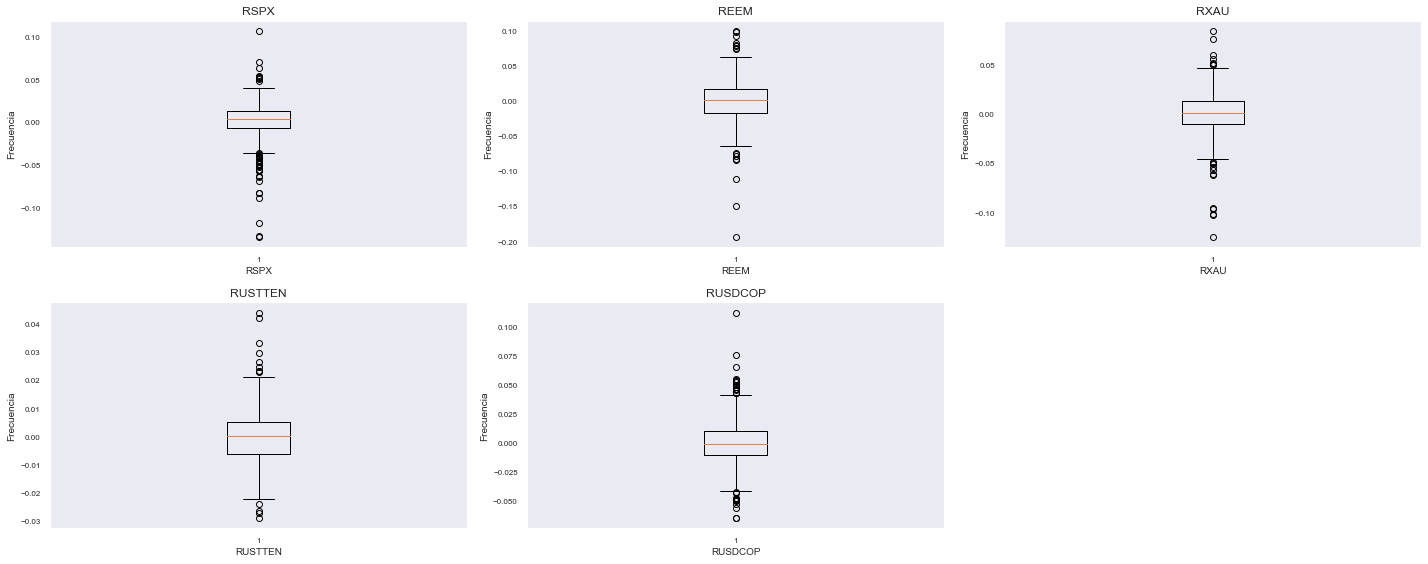

In [64]:
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 8))

for i, column in enumerate(dataw_r.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    ax.boxplot(dataw_r[column])
    ax.set_title(column, fontsize=12)
    ax.set_xlabel(column, fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='both', labelsize=8)

specific_positions = [(1, 2)]
[fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

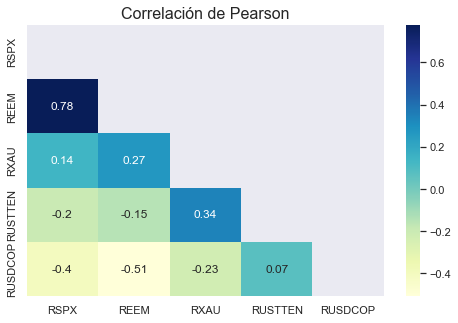

In [65]:
#Correlación de Pearson
plt.figure(figsize = (8,5))
sns.set(font_scale=1)
corr_df = dataw_r.corr(method='pearson').round(2)
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_df,annot=True,cmap='YlGnBu',annot_kws={"size":12}, square = False, mask = mask, alpha = 1)
plt.title('Correlación de Pearson', fontsize=16)
plt.show()

### Detección de Outliers

In [66]:
df_outliers_r = dataw_r.apply(lambda col: zscore(col, window=100), axis=0)
for col in df_outliers_r.columns:
    false_p_r = ((1-((df_outliers_r[col] == True).sum() / len(df_outliers_r))) * 100).round(2)
    print(f'{col} tiene {false_p_r}% de outliers')  

RSPX tiene 5.39% de outliers
REEM tiene 4.64% de outliers
RXAU tiene 4.64% de outliers
RUSTTEN tiene 4.19% de outliers
RUSDCOP tiene 4.94% de outliers


### Estacionariedad

c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


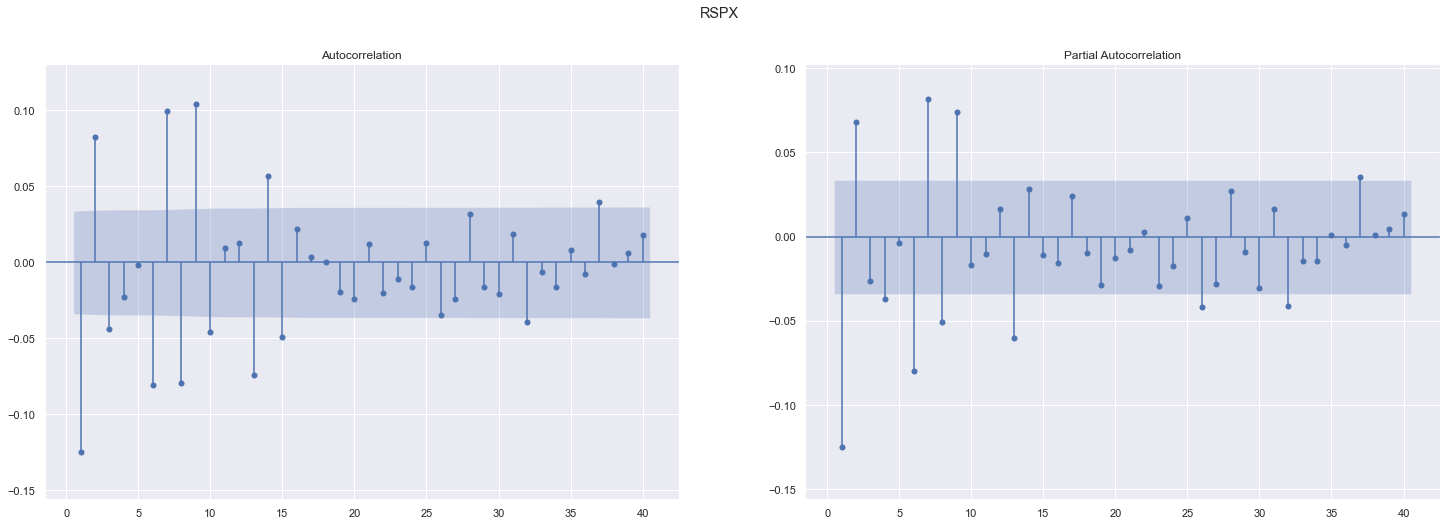

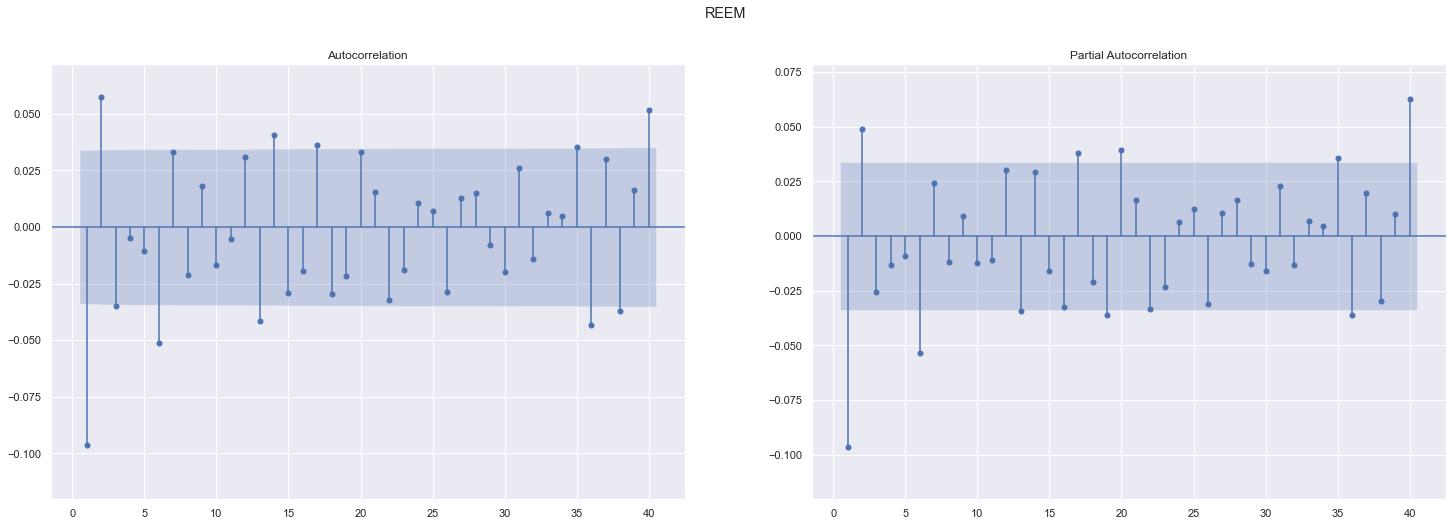

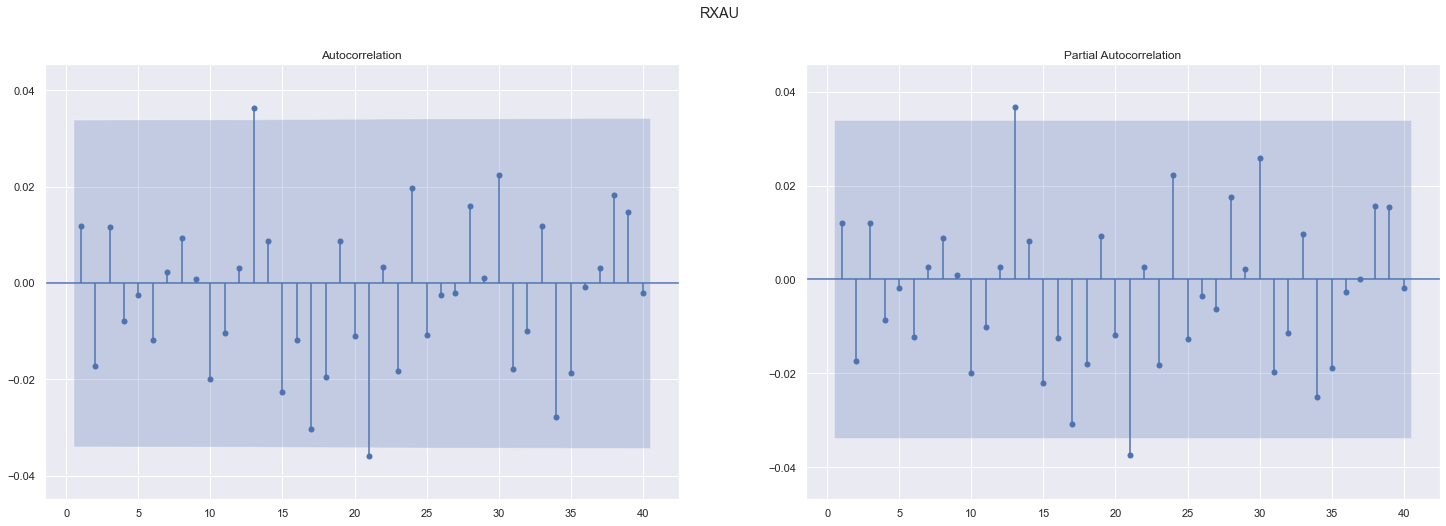

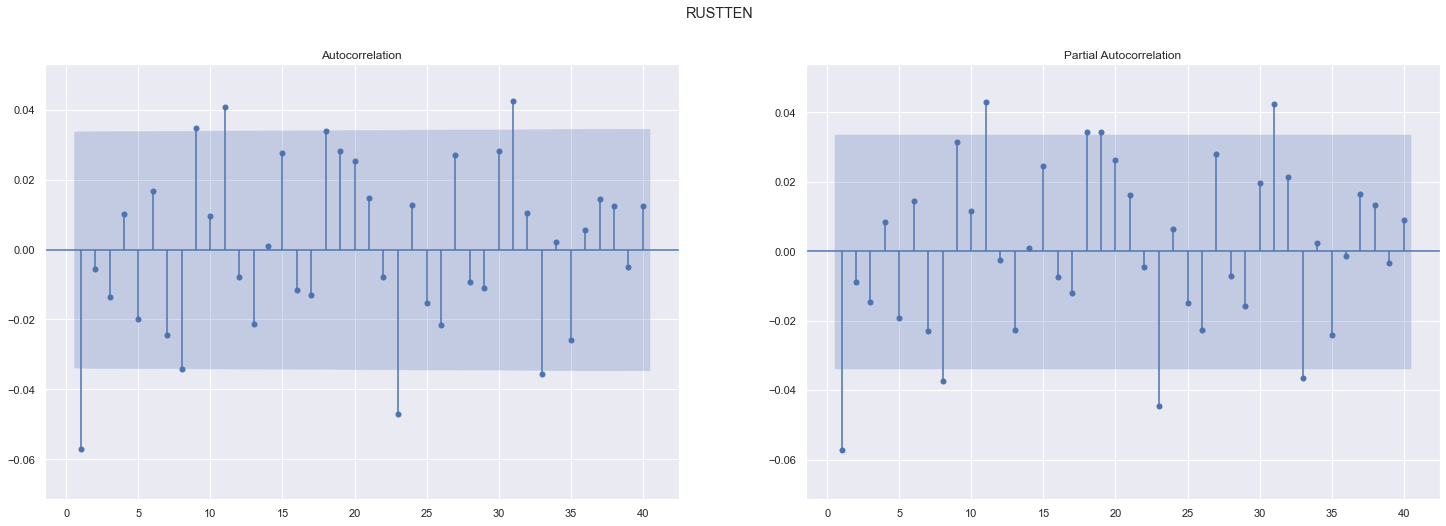

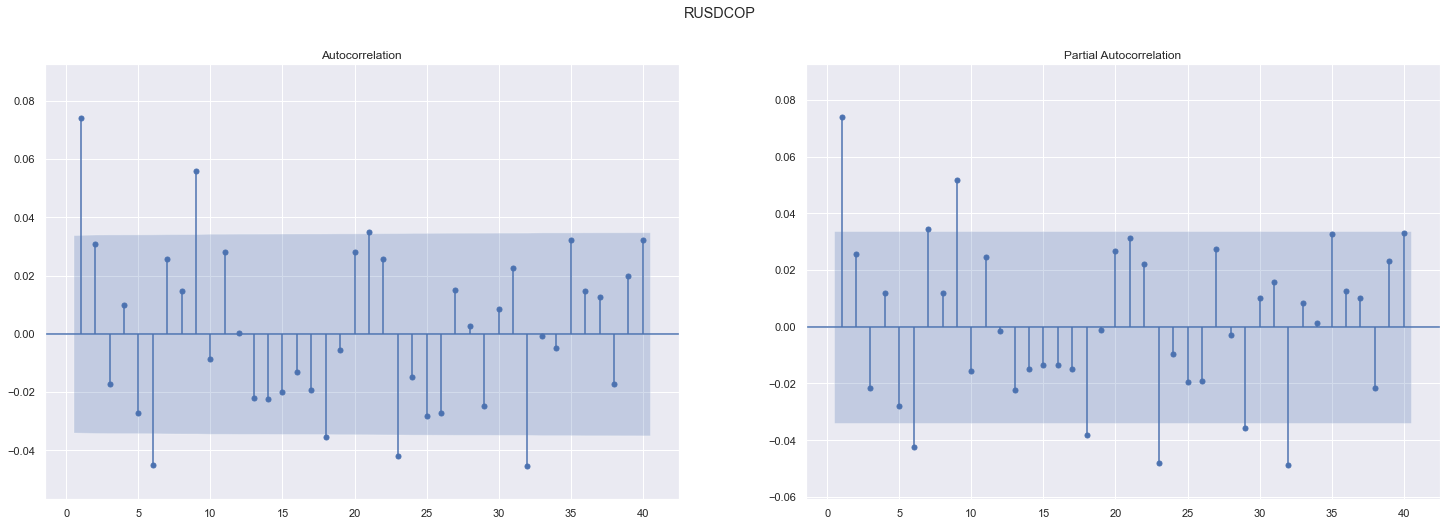

In [67]:
for col in dataw_r.columns:
    plot_acf_pacf(data_r[col], col)

In [68]:
for col in dataw_r.columns:
    result = sm.tsa.adfuller(dataw_r[col])
    # # Print the ADF test results in a user-friendly format
    # print("Augmented Dickey-Fuller Test Results:")
    # print(f"ADF Statistic: {result[0]}")
    # print(f"P-value: {result[1]}")
    # print("Critical Values:")
    # for key, value in result[4].items():
    #     print(f"  {key}: {value}")
    # Interpret the results
    if result[1] <= 0.05:
        print_colored(f"{col} series is likely stationary.", 'green')
    else:
        print_colored(f"{col} series is likely non-stationary.", 'red')

RSPX series is likely stationary.
REEM series is likely stationary.
RXAU series is likely stationary.
RUSTTEN series is likely stationary.
RUSDCOP series is likely stationary.


In [69]:
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

for col in dataw_r.columns:
    if (col != 'day' and col != 'month' and col != 'year'):
        # # Perform the KPSS test
        result_kpss = kpss(data_r[col], regression='c')
        
        # # Print the KPSS test results in a user-friendly format
        # print("\nKPSS Test Results for", col, "series:")
        # print('KPSS Statistic:', result_kpss[0])
        #print('p-value:', result_kpss[1])
        # print('Critical Values:')
        
        # for key, value in result_kpss[3].items():
        #     print(f'  {key}: {value}')
        
        # # Interpret the results
        if result_kpss[1] > 0.05:
            print_colored(f"{col} series is likely stationary.", 'green')
        else:
            print_colored(f"{col} series is likely non-stationary.", 'red')

RSPX series is likely stationary.
REEM series is likely stationary.
RXAU series is likely stationary.
RUSTTEN series is likely non-stationary.
RUSDCOP series is likely stationary.


In [70]:
data2 = dataw_r

# Prepare data
data2['year'] = [d.year for d in data2.index]
data2['month'] = [d.strftime('%b') for d in data2.index]
data2['day'] = [d.strftime('%d') for d in data2.index]
years = data2['year'].unique()

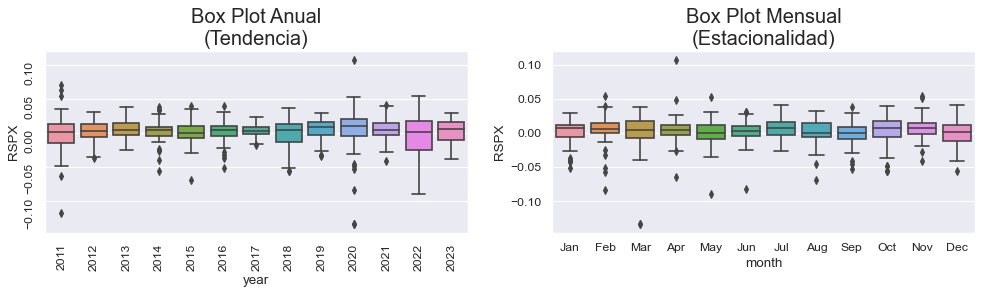

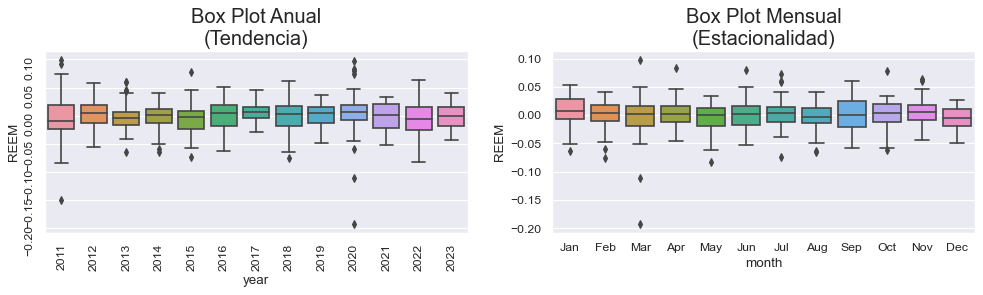

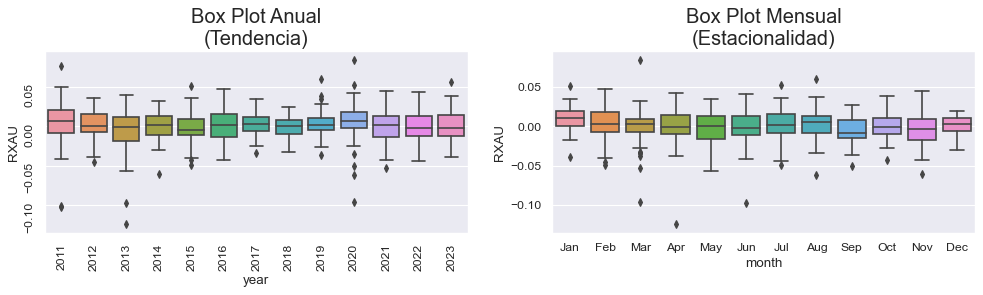

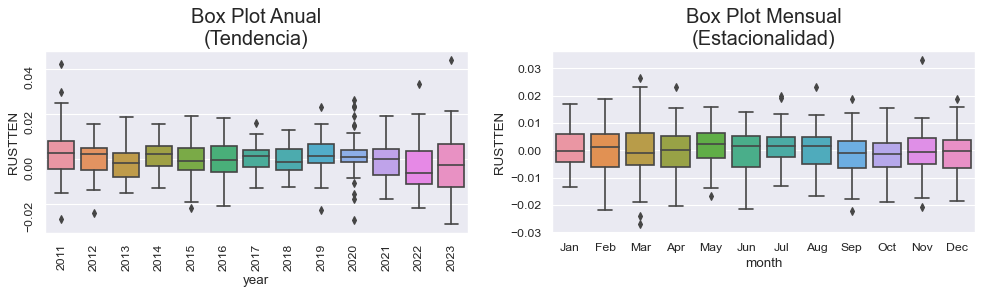

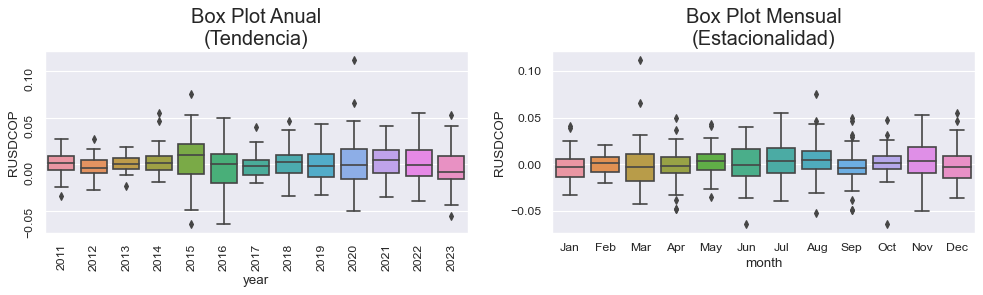

In [71]:
for col in dataw_r.columns:
    if (col != 'day' and col != 'month' and col != 'year'):
        fig, axes = plt.subplots(1, 2, figsize=(15,3), dpi= 80)
        sns.boxplot(x='year', y= dataw_r[col], data=dataw_r, ax=axes[0])
        sns.boxplot(x='month', y= dataw_r[col], data=dataw_r.loc[~dataw_r.year.isin([2011, 2023]), :])
        axes[0].set_title('Box Plot Anual\n(Tendencia)', fontsize=18); 
        axes[1].set_title('Box Plot Mensual\n(Estacionalidad)', fontsize=18)
        axes[0].tick_params(labelrotation=90)
        plt.show()

# Variables Exógenas

In [72]:
macro = pd.read_csv('datos_macro.csv', index_col = 'date')

In [73]:
macro

USTVOL       BEI     JPYRR    GDPNOW    FINCON       OIL  \
date                                                                     
2011-09-07  0.707107 -0.707107  0.707107 -0.707107  0.707107  0.707107   
2011-09-14 -0.865833 -0.762664  0.056009  1.091089  0.952217 -0.390621   
2011-09-21 -1.253277 -1.223897  0.220516  1.095445  1.008319 -1.483764   
2011-09-28  1.278523 -0.655151  0.478148  1.032796  0.990217 -1.642572   
2011-10-05  1.612667 -0.986611  0.645106  1.298972  0.843133 -1.408654   
...              ...       ...       ...       ...       ...       ...   
2023-10-04  1.421542  1.607690 -0.316407  0.182338  0.372872  0.877790   
2023-10-11  1.377929  1.435157 -0.270615  0.201123  0.407858  0.838318   
2023-10-18  1.425951  1.659562 -0.197833  0.224725  0.427875  1.068350   
2023-10-25  1.474563  1.613041 -0.120259  0.223285  0.420083  0.919951   
2023-11-01  1.453587  1.592320  0.012883  0.222451  0.416790  0.808662   

             ECOSURP      USTR    SPXPOS    USTPOS    DXYPOS      AAII  
date                                                                    
2011-09-07 -0.707107 -0.707107  0.707107 -0.707107  0.707107  0.707107  
2011-09-14  1.149464 -0.218218  1.018107  0.127238  1.151272 -0.878006  
2011-09-21  0.759720 -1.240216 -0.580486  1.293147  1.385215 -0.767110  
2011-09-28  0.556709  0.729149 -0.144498  0.612672  1.150534 -1.359245  
2011-10-05  1.796060  0.088527 -0.313697  0.238387  1.010535 -0.507175  
...              ...       ...       ...       ...       ...       ...  
2023-10-04  0.441969  2.380557 -0.221635 -3.405792 -0.017540 -0.561508  
2023-10-11  0.516724  2.210779 -0.363500 -3.432730  0.028857 -0.469161  
2023-10-18  0.497822  2.401551 -0.136604 -3.475258  0.013845  0.379730  
2023-10-25  0.467269  2.424220  0.393297 -3.598376  0.050903  0.150478  
2023-11-01  0.595821  2.317178  0.400680 -3.498764  0.056161 -0.605026  

[635 rows x 12 columns]

In [74]:
macro.info()

<class 'pandas.core.frame.DataFrame'>
Index: 635 entries, 2011-09-07 to 2023-11-01
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   USTVOL   635 non-null    float64
 1   BEI      635 non-null    float64
 2   JPYRR    635 non-null    float64
 3   GDPNOW   635 non-null    float64
 4   FINCON   635 non-null    float64
 5   OIL      635 non-null    float64
 6   ECOSURP  635 non-null    float64
 7   USTR     635 non-null    float64
 8   SPXPOS   635 non-null    float64
 9   USTPOS   635 non-null    float64
 10  DXYPOS   635 non-null    float64
 11  AAII     635 non-null    float64
dtypes: float64(12)
memory usage: 64.5+ KB


In [75]:
(macro.isna().sum(axis=0)/len(macro)).sort_values(ascending = False)

USTVOL     0.0
BEI        0.0
JPYRR      0.0
GDPNOW     0.0
FINCON     0.0
OIL        0.0
ECOSURP    0.0
USTR       0.0
SPXPOS     0.0
USTPOS     0.0
DXYPOS     0.0
AAII       0.0
dtype: float64

In [76]:
macro.index = (pd.to_datetime(macro.index, format='%Y-%m-%d'))

## Visualización de Variables Exógenas

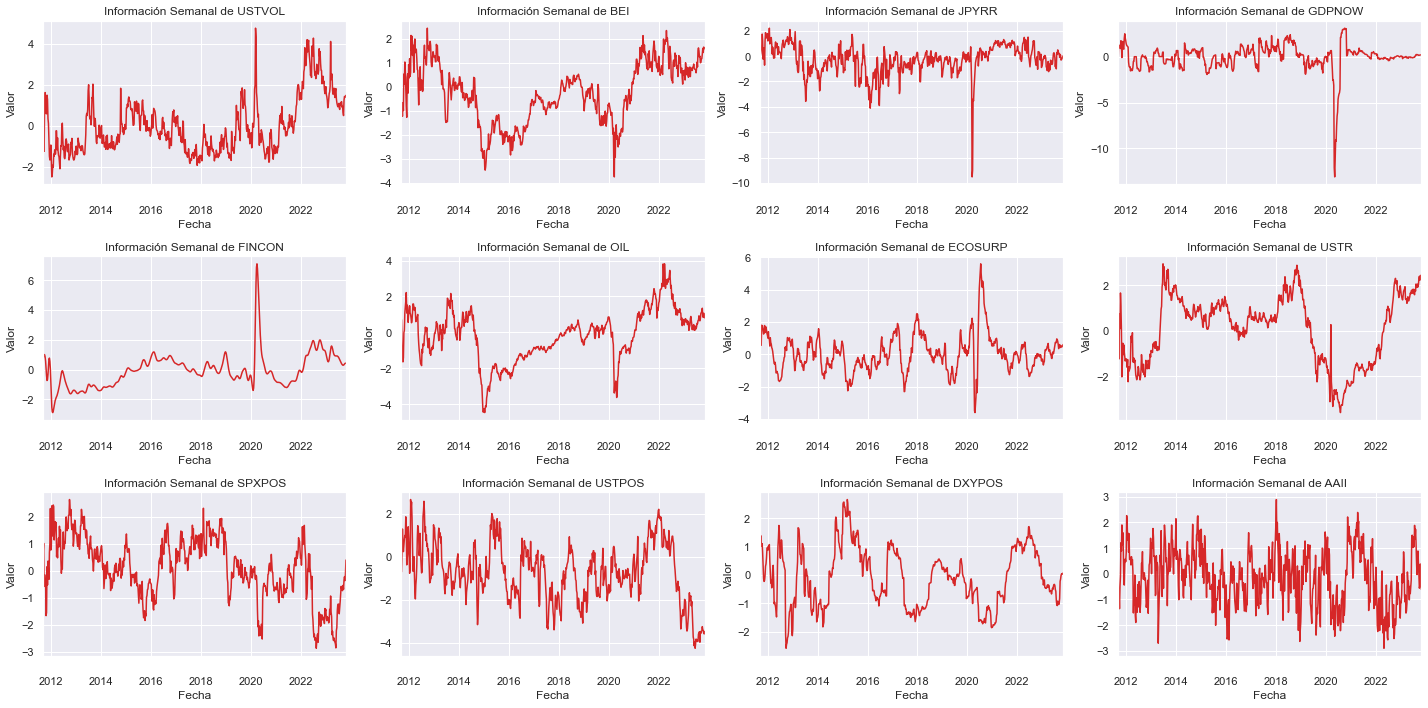

In [77]:
num_columns = min(4, len(macro.columns)) 
num_rows = math.ceil(len(macro.columns) / num_columns)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))

for i, column in enumerate(macro.columns):
    row = i // num_columns
    col = i % num_columns
    plot_df(macro, x=macro.index.values, y=macro[column], title=f'Información Semanal de {column}', ax=axes[row, col])
    axes[row, col].set_ylabel('Valor')

# [fig.delaxes(axes[row, col]) for row, col in specific_positions]
plt.tight_layout()
plt.show()

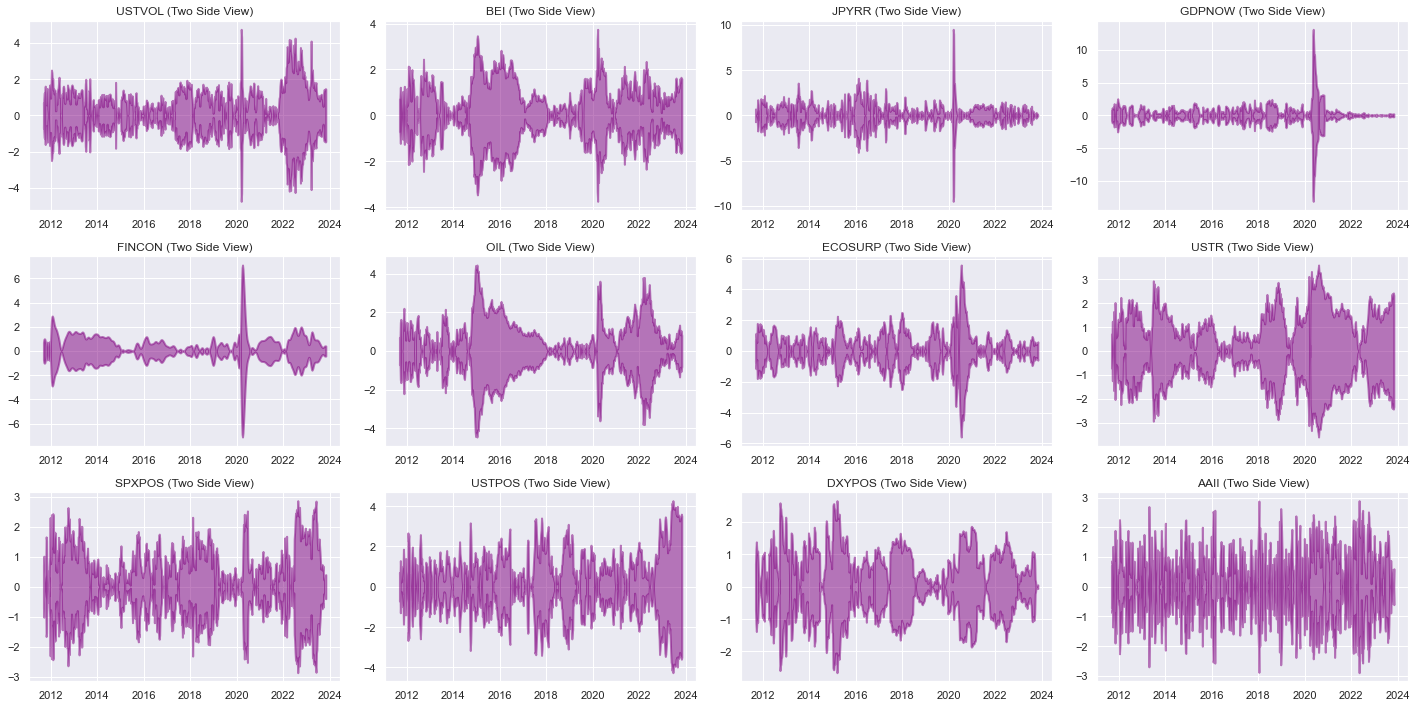

In [78]:
x = macro.index.values

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))

for i, column in enumerate(macro.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    y1 = macro[column]
    ax.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color= 'purple')
    ax.set_title(f'{column} (Two Side View)', fontsize=12)

plt.tight_layout()
plt.show()

In [79]:
# Estadística descriptiva
stats = macro.describe().round(2)
stats

USTVOL     BEI   JPYRR  GDPNOW  FINCON     OIL  ECOSURP    USTR  \
count  635.00  635.00  635.00  635.00  635.00  635.00   635.00  635.00   
mean    -0.01   -0.24   -0.27   -0.02   -0.05   -0.14     0.06    0.08   
std      1.33    1.24    1.15    1.49    1.15    1.42     1.15    1.48   
min     -2.50   -3.75   -9.52  -13.13   -2.89   -4.46    -3.61   -3.59   
25%     -1.03   -1.09   -0.83   -0.43   -0.85   -0.97    -0.62   -1.28   
50%     -0.28   -0.17   -0.17    0.05   -0.10    0.02    -0.03    0.44   
75%      0.78    0.74    0.43    0.61    0.57    0.78     0.64    1.25   
max      4.75    2.45    2.20    3.15    7.10    3.81     5.59    2.93   

       SPXPOS  USTPOS  DXYPOS    AAII  
count  635.00  635.00  635.00  635.00  
mean     0.09   -0.72   -0.08   -0.12  
std      1.12    1.35    1.02    1.07  
min     -2.87   -4.26   -2.59   -2.90  
25%     -0.58   -1.58   -0.91   -0.91  
50%      0.14   -0.68   -0.09   -0.11  
75%      0.93    0.18    0.72    0.67  
max      2.64    2.67    2.66    2.89

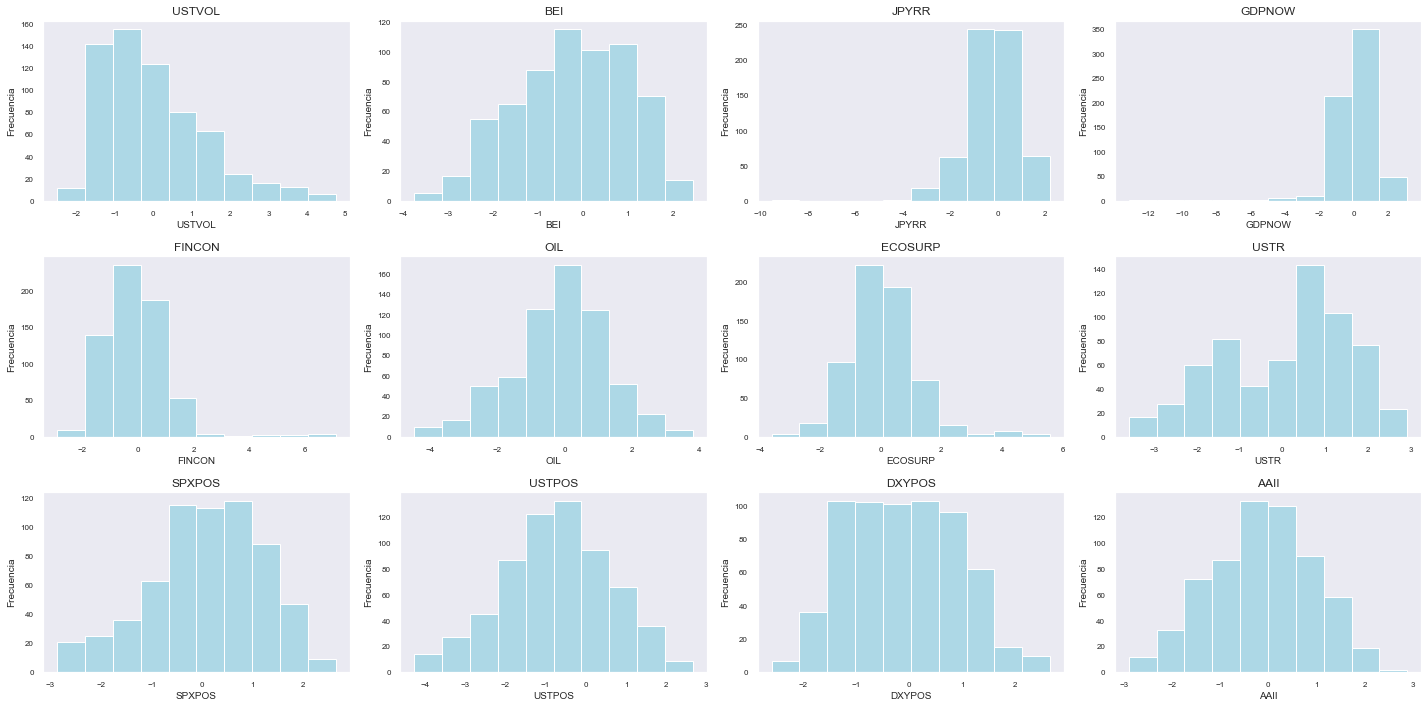

In [80]:
# Histogramas
sns.set_style("dark")
num_columns = min(4, len(macro.columns)) 
num_rows = math.ceil(len(macro.columns) / num_columns)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))

for i, column in enumerate(macro.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    ax.hist(macro[column], color = "lightblue", ec="white")
    ax.set_title(column, fontsize=12)
    ax.set_xlabel(column, fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='both', labelsize=8)


plt.tight_layout()
plt.show()

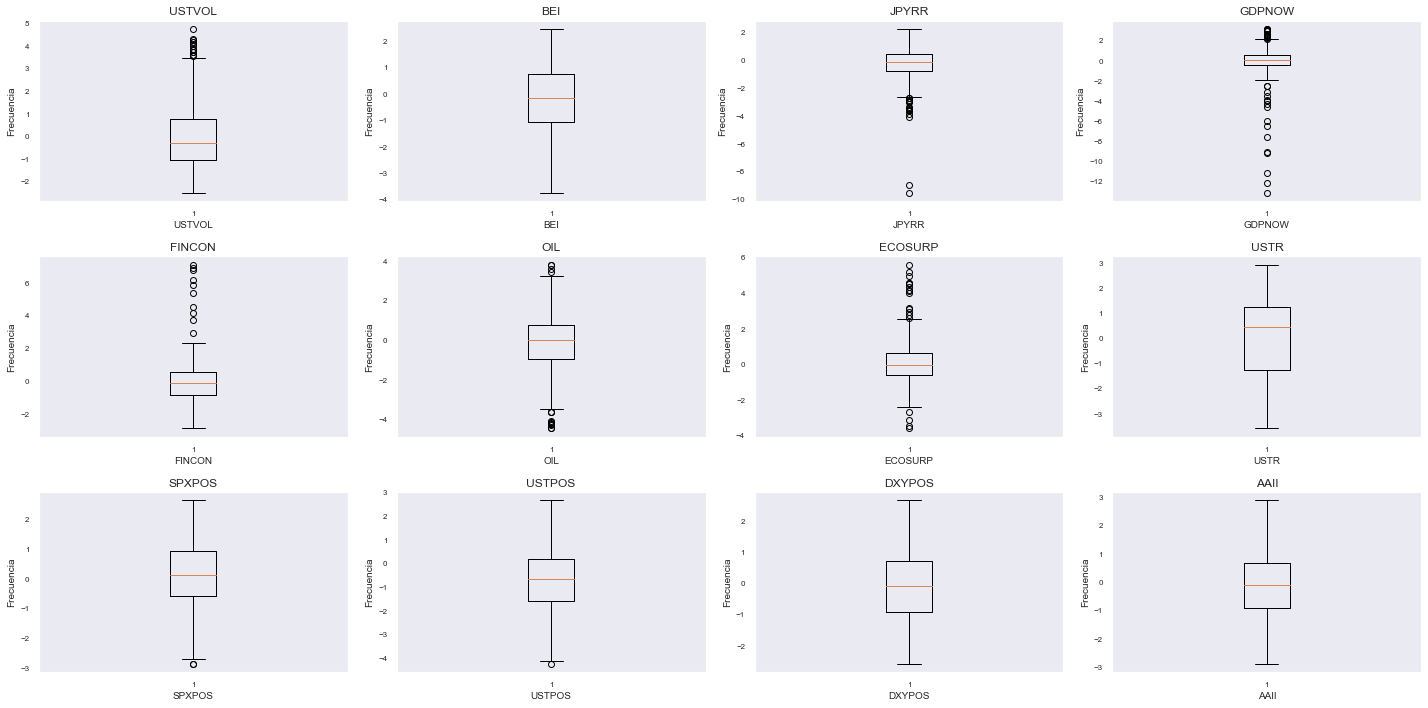

In [81]:
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))

for i, column in enumerate(macro.columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]
    ax.boxplot(macro[column])
    ax.set_title(column, fontsize=12)
    ax.set_xlabel(column, fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='both', labelsize=8)


plt.tight_layout()
plt.show()

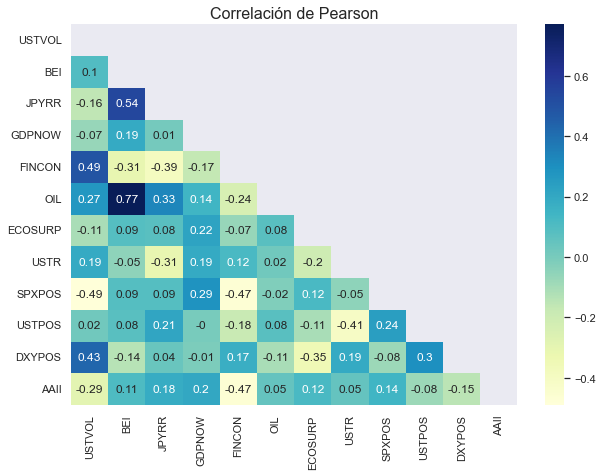

In [82]:
#Correlación de Pearson
plt.figure(figsize = (10,7))
sns.set(font_scale=1)
corr_df = macro.corr(method='pearson').round(2)
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_df,annot=True,cmap='YlGnBu',annot_kws={"size":12}, square = False, mask = mask, alpha = 1)
plt.title('Correlación de Pearson', fontsize=16)
plt.show()

## Detección de Outliers Macro

In [83]:
df_outliers = macro.apply(lambda col: zscore(col, window=100), axis=0)
for col in df_outliers.columns:
    false_p = ((1-((df_outliers[col] == True).sum() / len(df_outliers))) * 100).round(2)
    print(f'{col} tiene {false_p}% de outliers')  

USTVOL tiene 2.52% de outliers
BEI tiene 2.2% de outliers
JPYRR tiene 2.99% de outliers
GDPNOW tiene 2.52% de outliers
FINCON tiene 2.05% de outliers
OIL tiene 2.99% de outliers
ECOSURP tiene 3.15% de outliers
USTR tiene 2.05% de outliers
SPXPOS tiene 3.31% de outliers
USTPOS tiene 2.83% de outliers
DXYPOS tiene 0.47% de outliers
AAII tiene 2.52% de outliers


## Estacionariedad

c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


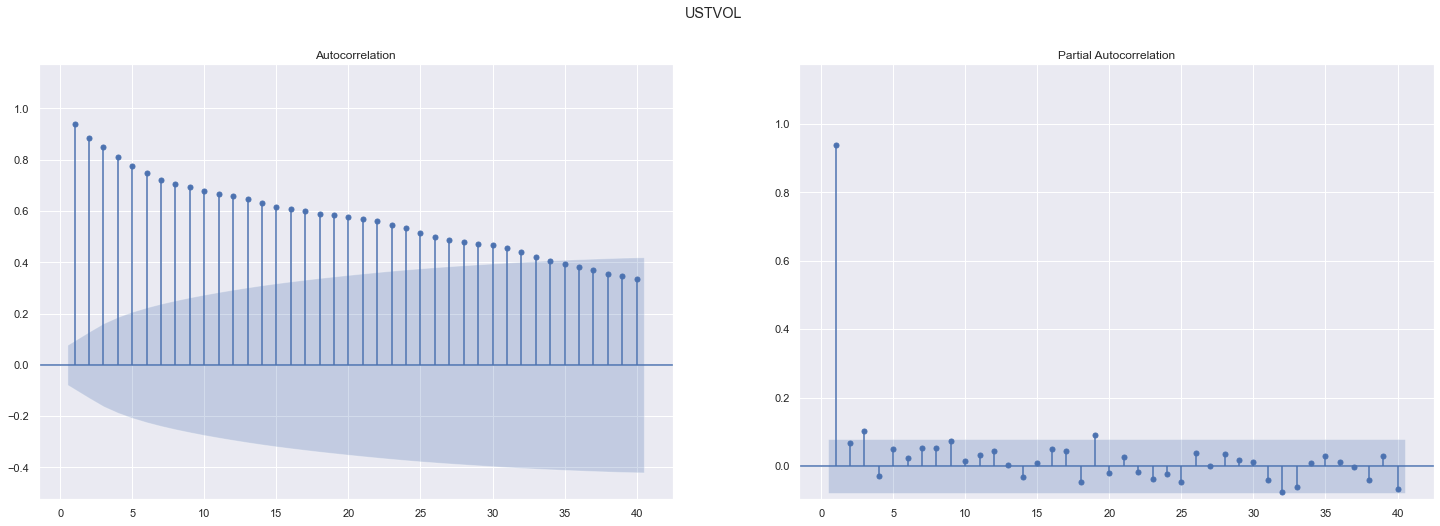

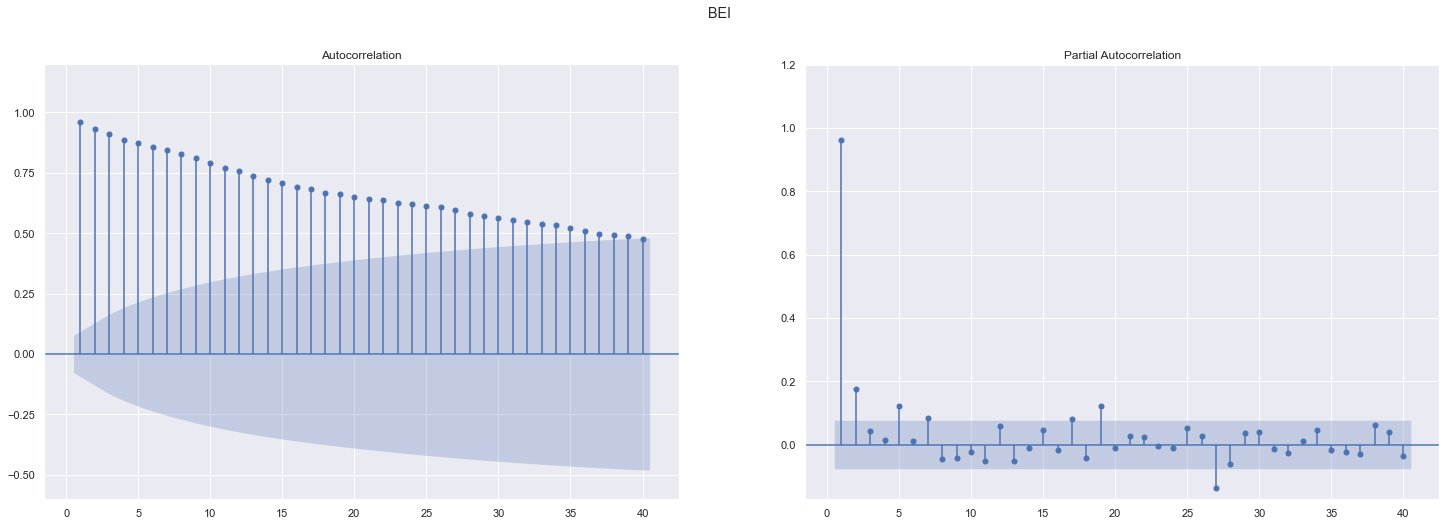

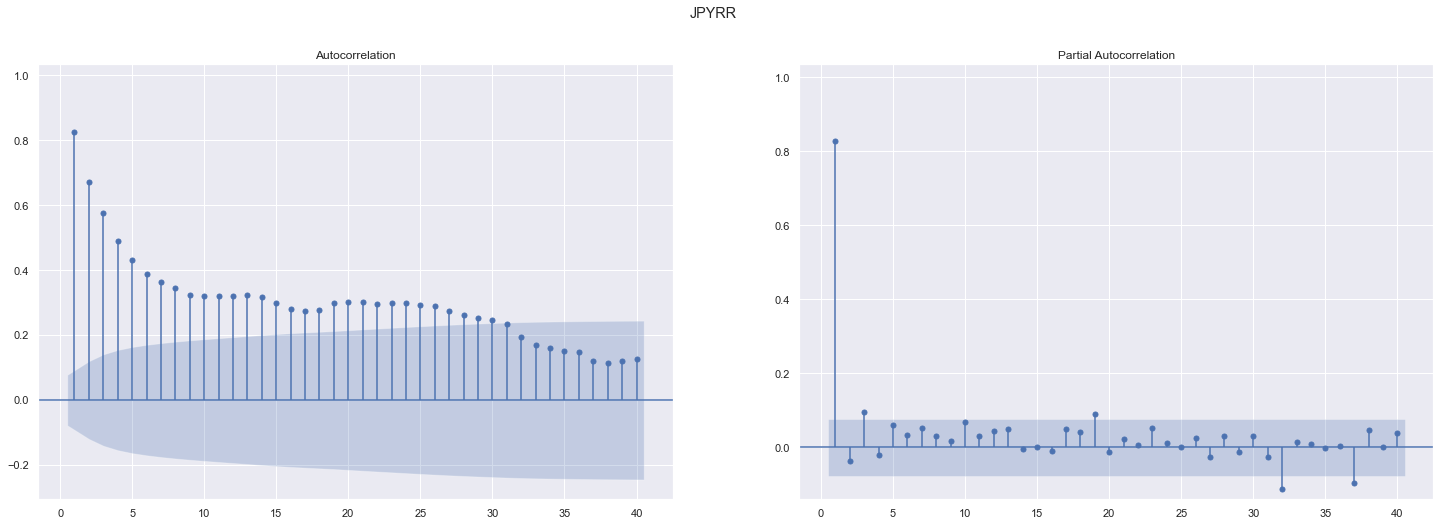

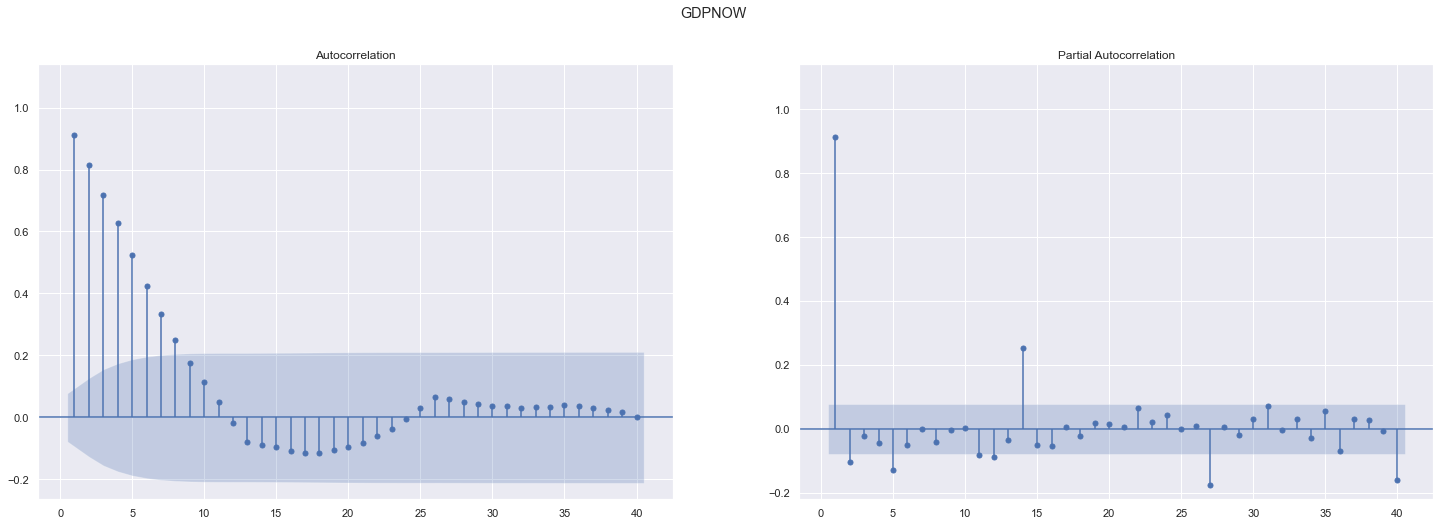

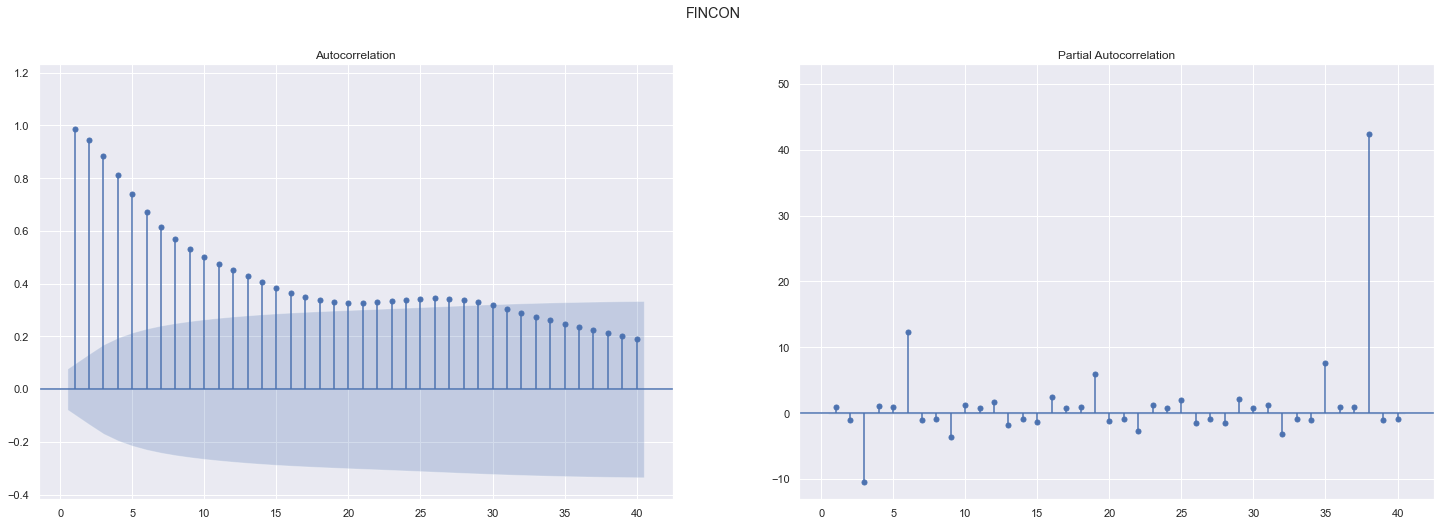

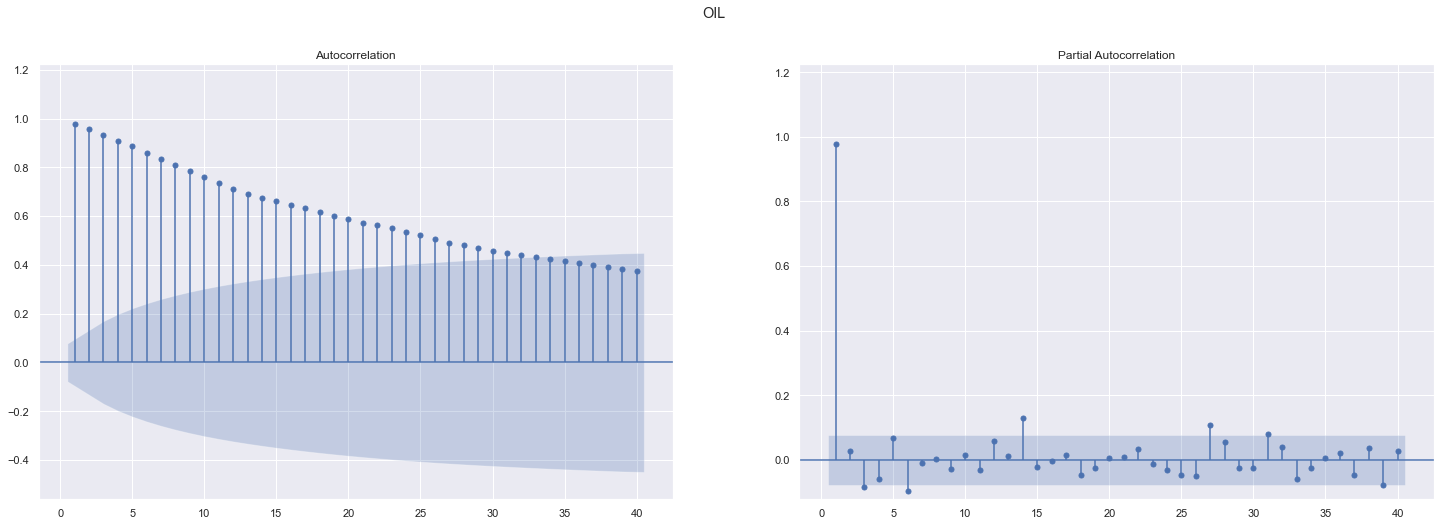

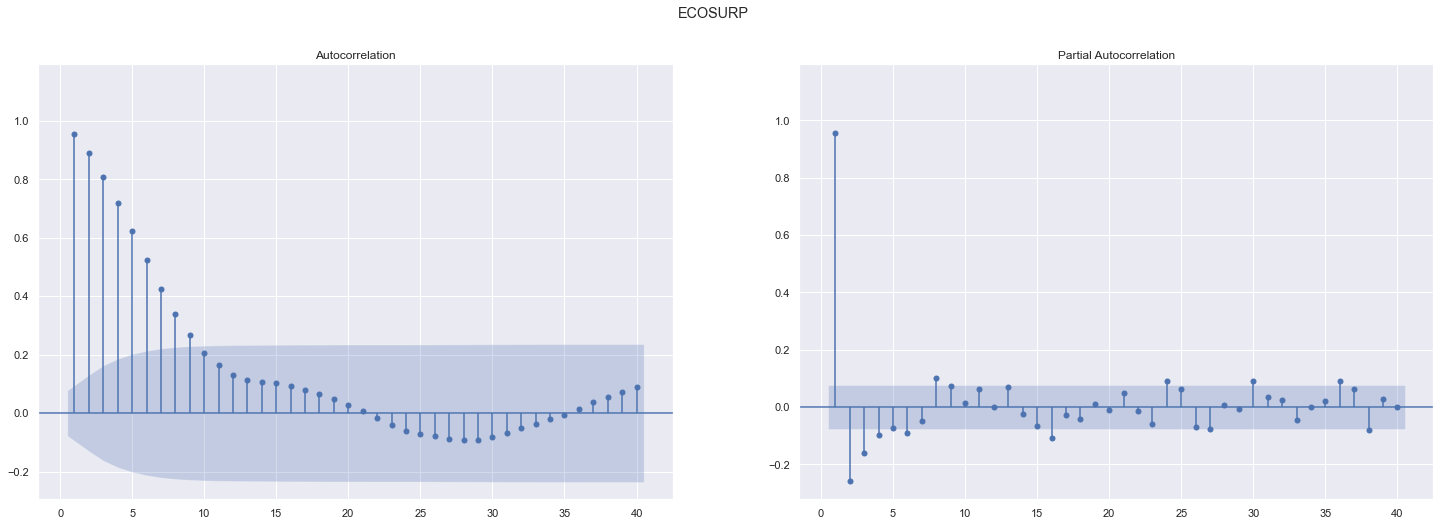

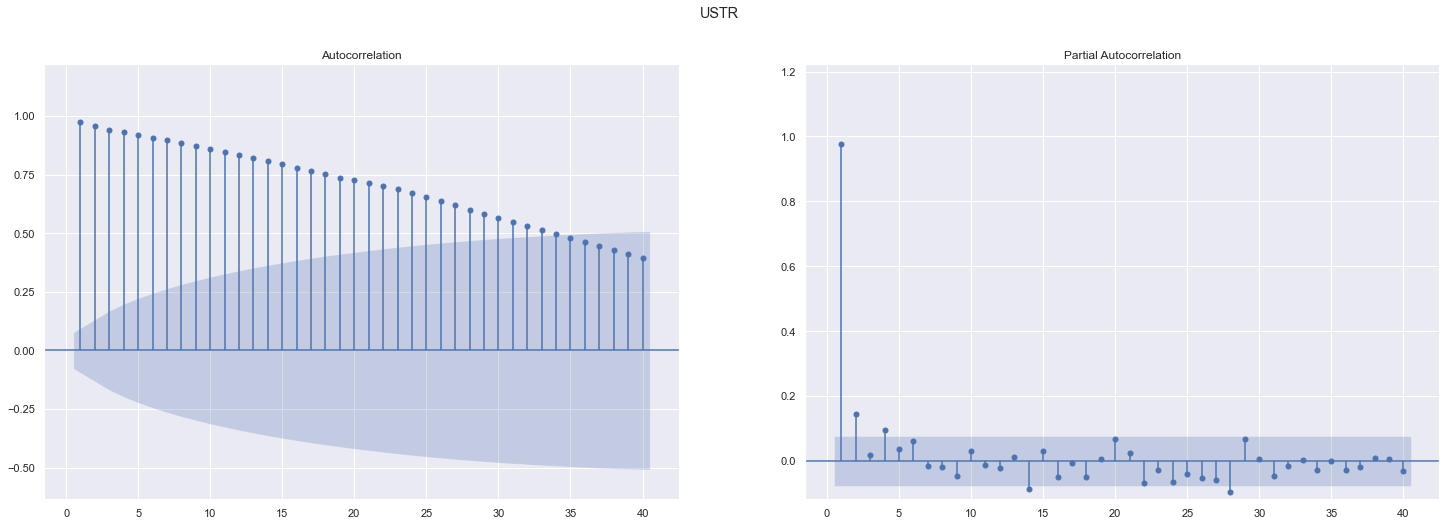

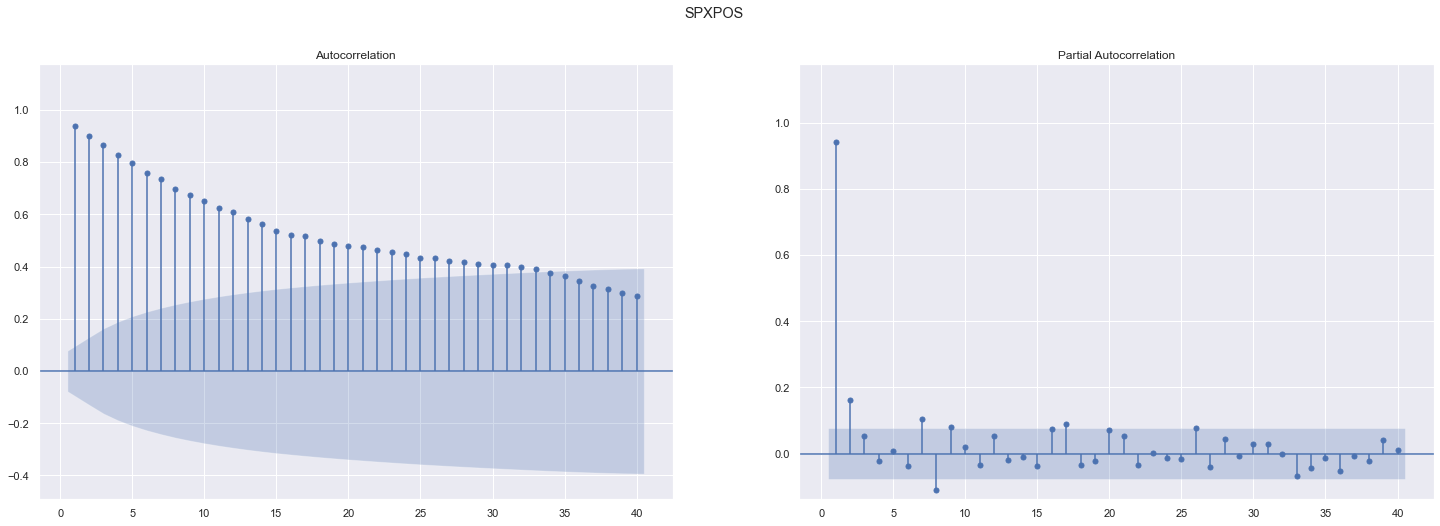

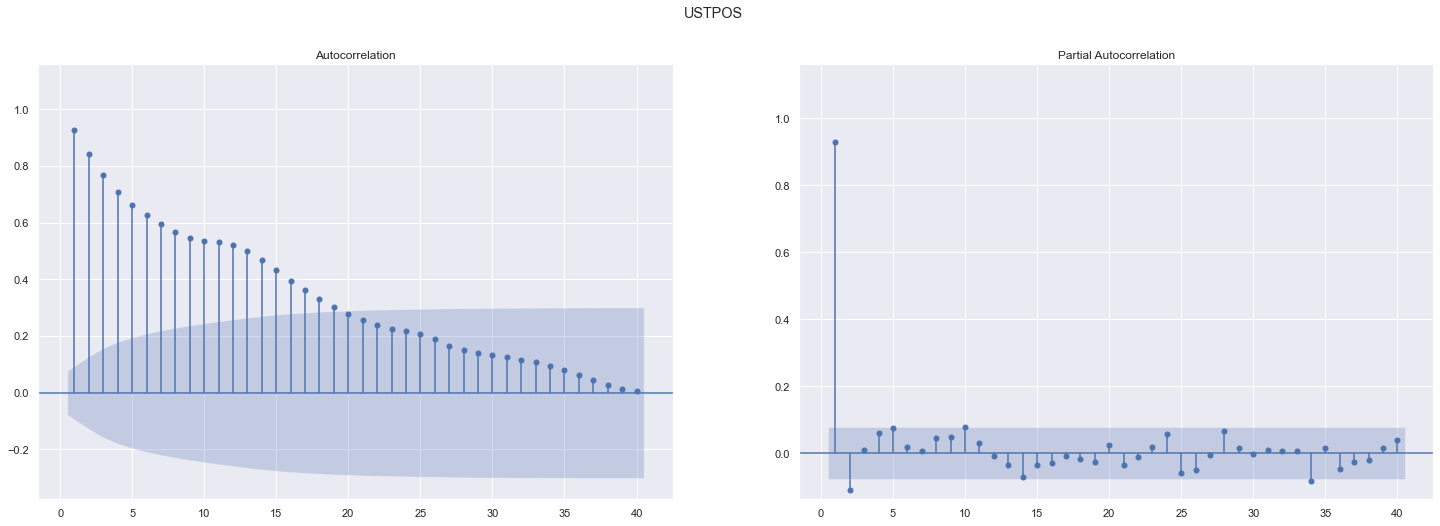

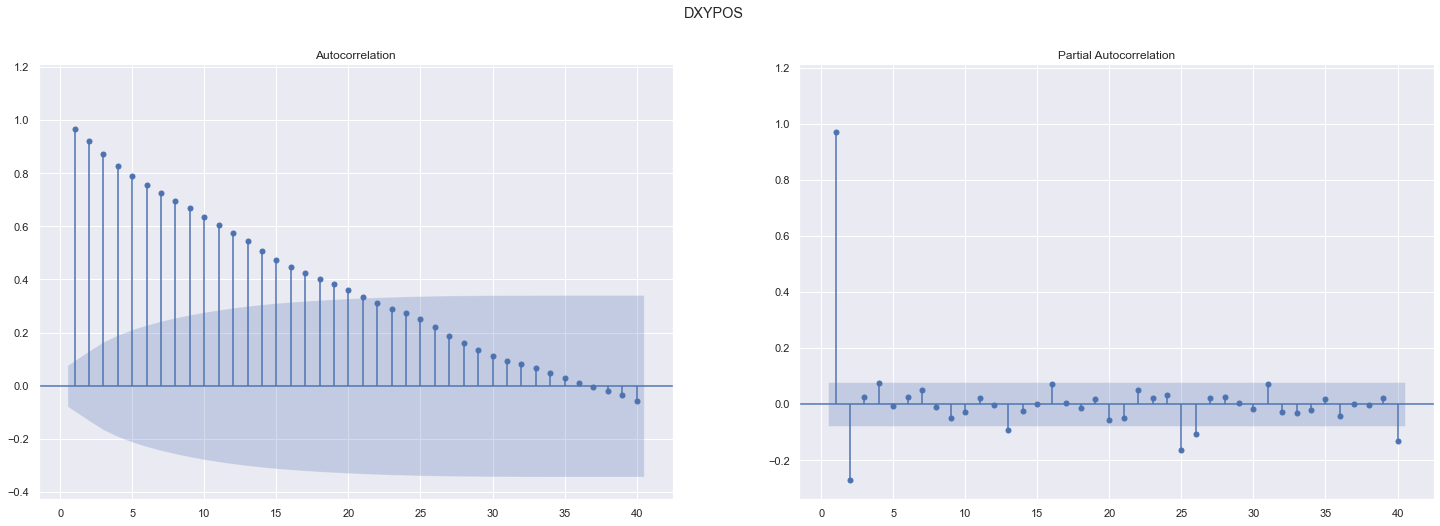

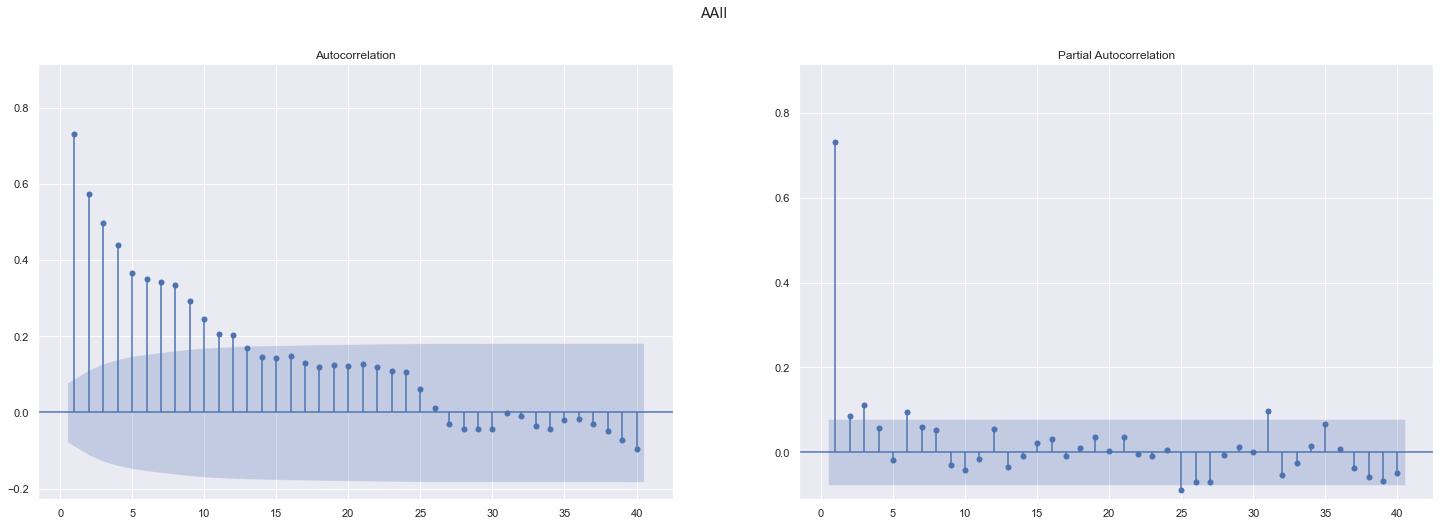

In [84]:
for col in macro.columns:
    plot_acf_pacf(macro[col], col)

In [85]:
for col in macro.columns:
    result = sm.tsa.adfuller(macro[col])
    # # Print the ADF test results in a user-friendly format
    # print("Augmented Dickey-Fuller Test Results:")
    # print(f"ADF Statistic: {result[0]}")
    # print(f"P-value: {result[1]}")
    # print("Critical Values:")
    # for key, value in result[4].items():
    #     print(f"  {key}: {value}")
    # Interpret the results
    if result[1] <= 0.05:
        print_colored(f"{col} series is likely stationary.", 'green')
    else:
        print_colored(f"{col} series is likely non-stationary.", 'red')

USTVOL series is likely non-stationary.
BEI series is likely non-stationary.
JPYRR series is likely stationary.
GDPNOW series is likely stationary.
FINCON series is likely non-stationary.
OIL series is likely non-stationary.
ECOSURP series is likely stationary.
USTR series is likely non-stationary.
SPXPOS series is likely stationary.
USTPOS series is likely stationary.
DXYPOS series is likely stationary.
AAII series is likely stationary.


In [86]:
data2 = macro

# Prepare data
data2['year'] = [d.year for d in data2.index]
data2['month'] = [d.strftime('%b') for d in data2.index]
data2['day'] = [d.strftime('%d') for d in data2.index]
years = data2['year'].unique()

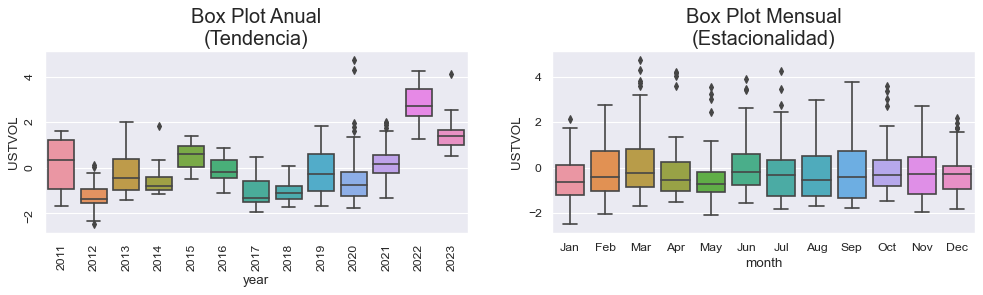

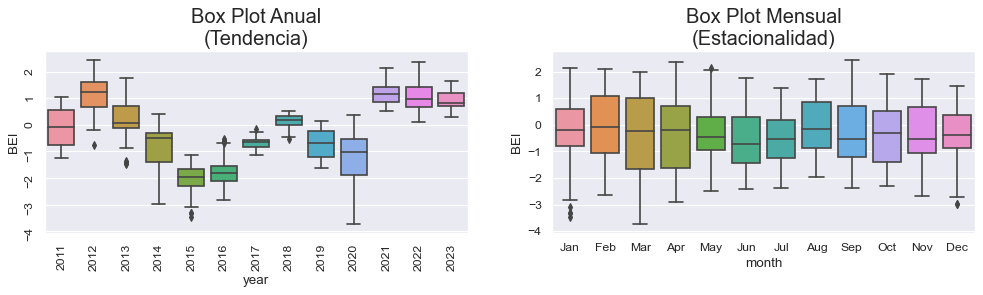

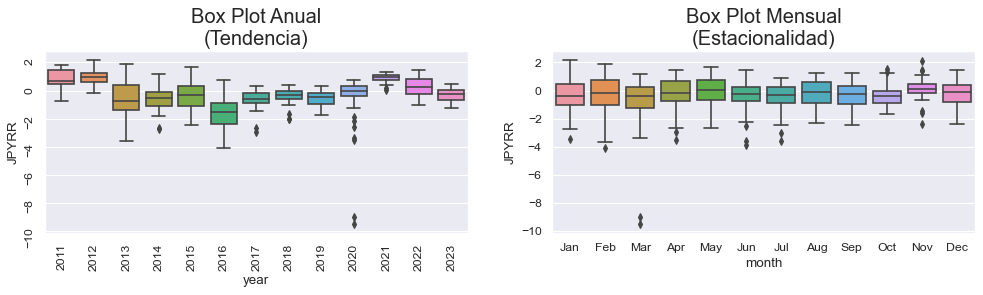

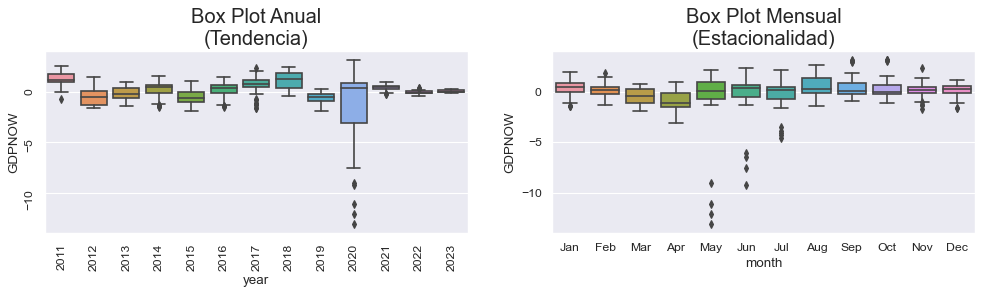

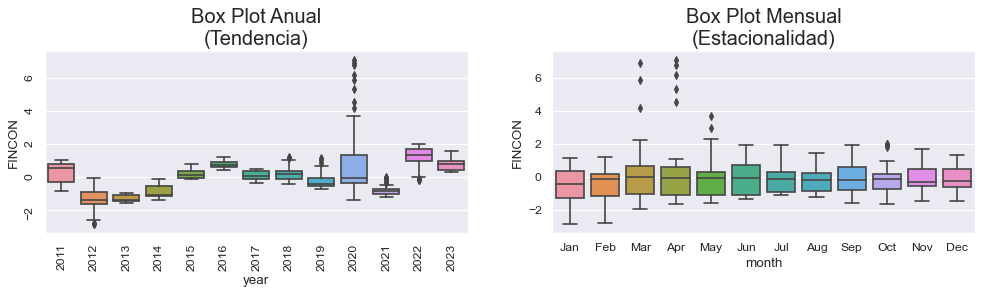

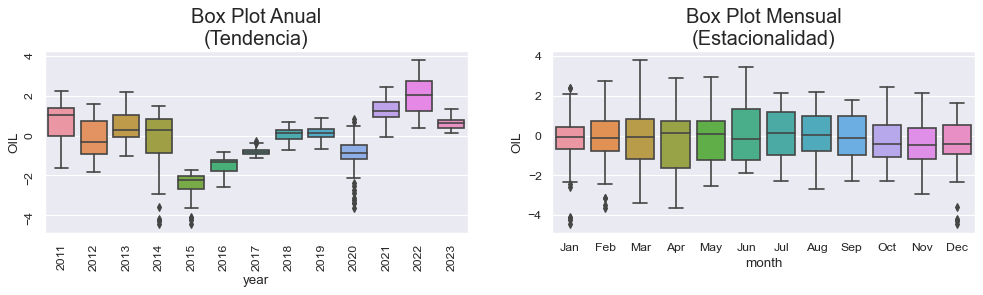

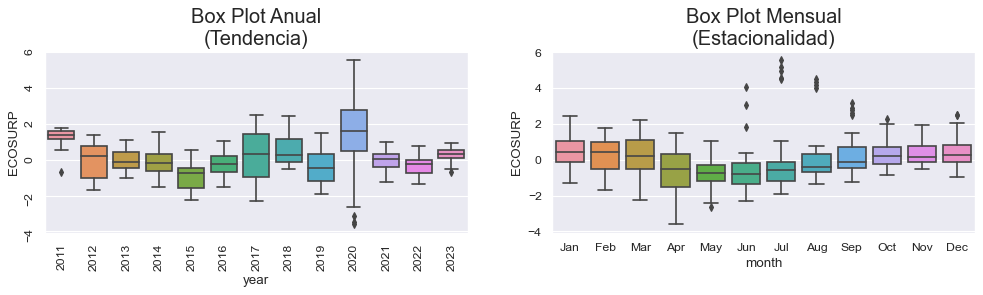

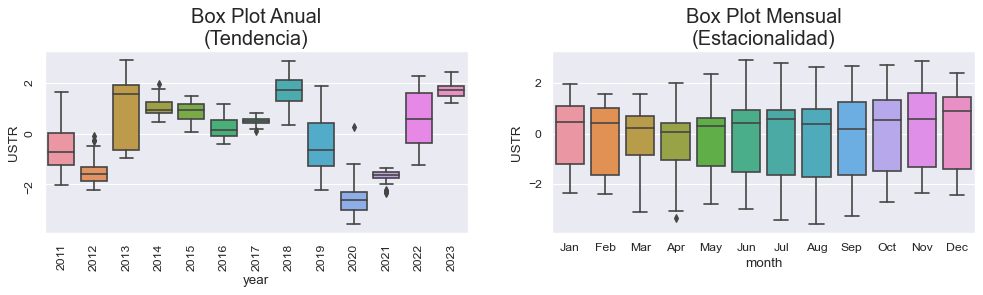

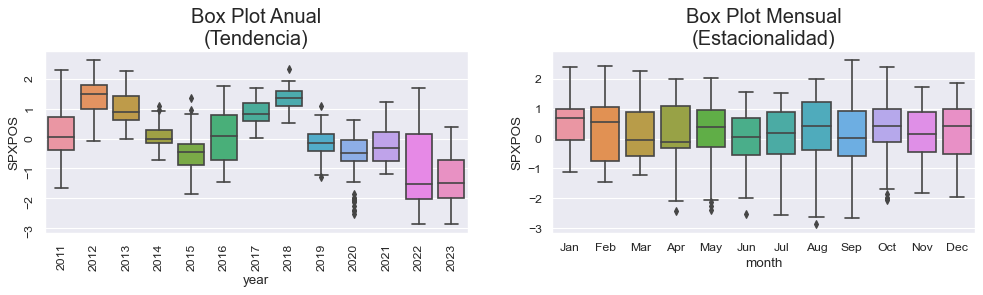

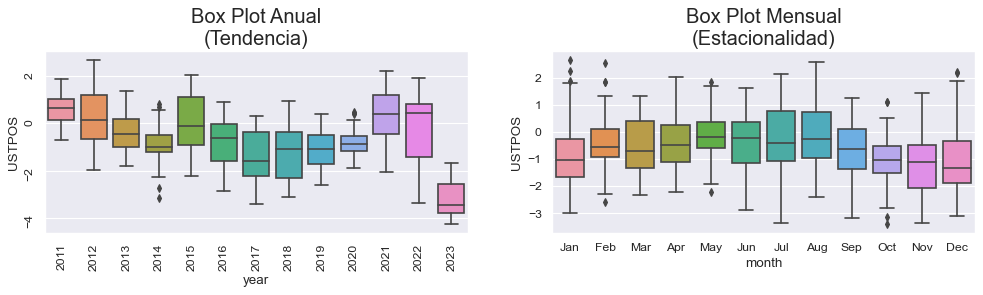

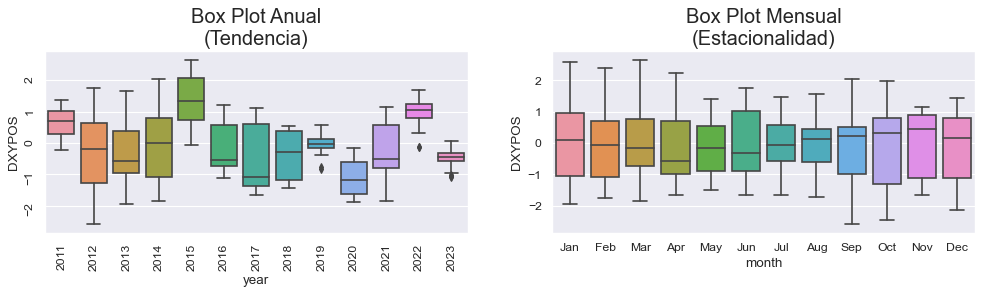

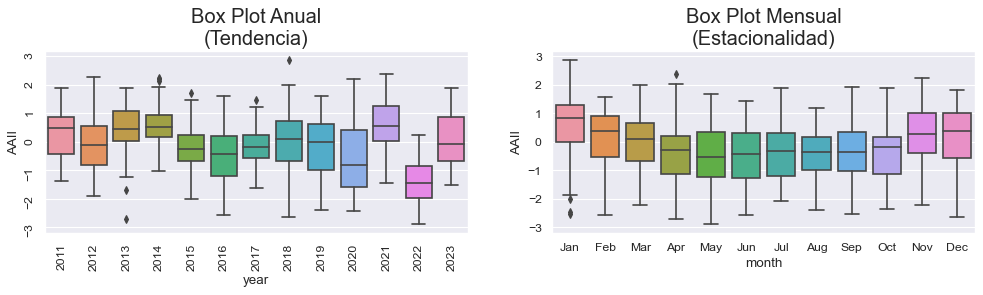

In [87]:
for col in macro.columns:
    if (col != 'day' and col != 'month' and col != 'year'):
        fig, axes = plt.subplots(1, 2, figsize=(15,3), dpi= 80)
        sns.boxplot(x='year', y= macro[col], data=macro, ax=axes[0])
        sns.boxplot(x='month', y= macro[col], data= macro.loc[~macro.year.isin([2011, 2023]), :])
        axes[0].set_title('Box Plot Anual\n(Tendencia)', fontsize=18); 
        axes[1].set_title('Box Plot Mensual\n(Estacionalidad)', fontsize=18)
        axes[0].tick_params(labelrotation=90)
        plt.show()

## Datos diferenciados

In [88]:
macro_r = pd.DataFrame()

for col in macro.columns:
    if (col != 'day' and col != 'month' and col != 'year'):
        macro_r[f'{col}'] = macro[col] - macro[col].shift(1)

In [89]:
macro_r = macro_r.dropna()

In [90]:
for col in macro_r.columns:
    result = sm.tsa.adfuller(macro_r[col])
    # # Print the ADF test results in a user-friendly format
    # print("Augmented Dickey-Fuller Test Results:")
    # print(f"ADF Statistic: {result[0]}")
    # print(f"P-value: {result[1]}")
    # print("Critical Values:")
    # for key, value in result[4].items():
    #     print(f"  {key}: {value}")
    # Interpret the results
    if result[1] <= 0.05:
        print_colored(f"{col} series is likely stationary.", 'green')
    else:
        print_colored(f"{col} series is likely non-stationary.", 'red')

USTVOL series is likely stationary.
BEI series is likely stationary.
JPYRR series is likely stationary.
GDPNOW series is likely stationary.
FINCON series is likely stationary.
OIL series is likely stationary.
ECOSURP series is likely stationary.
USTR series is likely stationary.
SPXPOS series is likely stationary.
USTPOS series is likely stationary.
DXYPOS series is likely stationary.
AAII series is likely stationary.


c:\Users\maria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


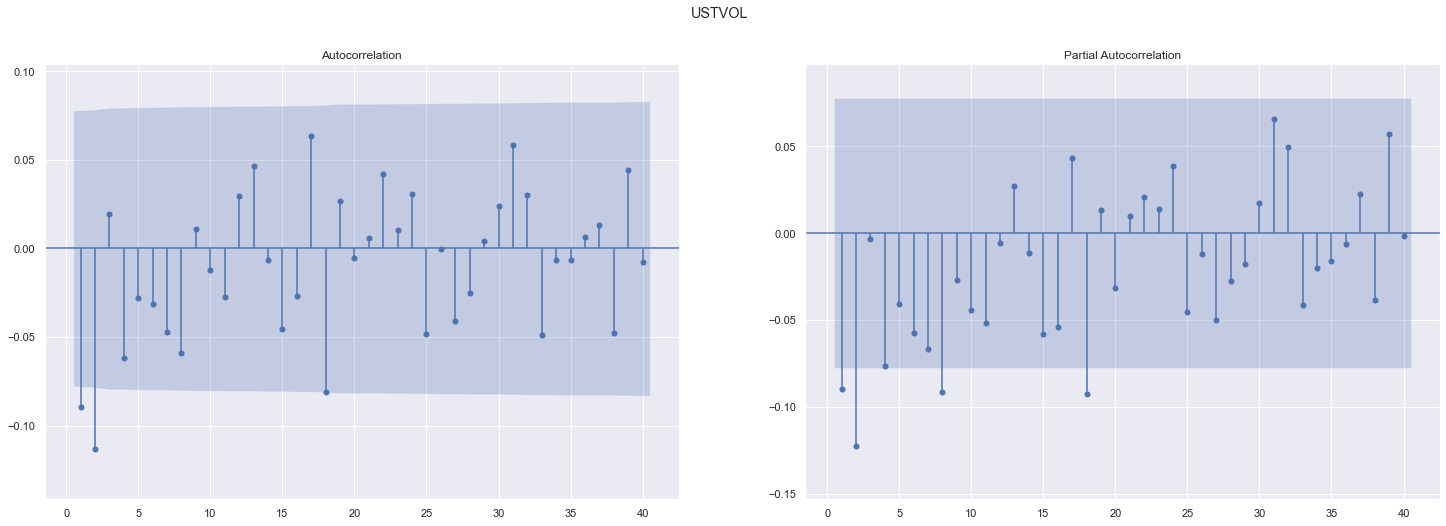

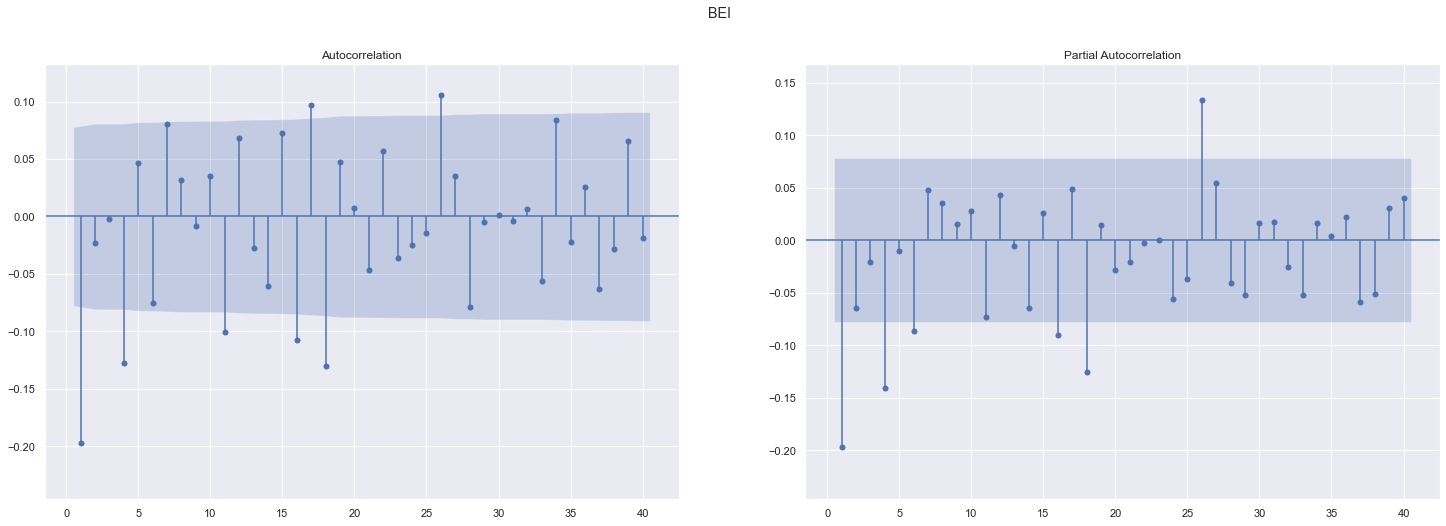

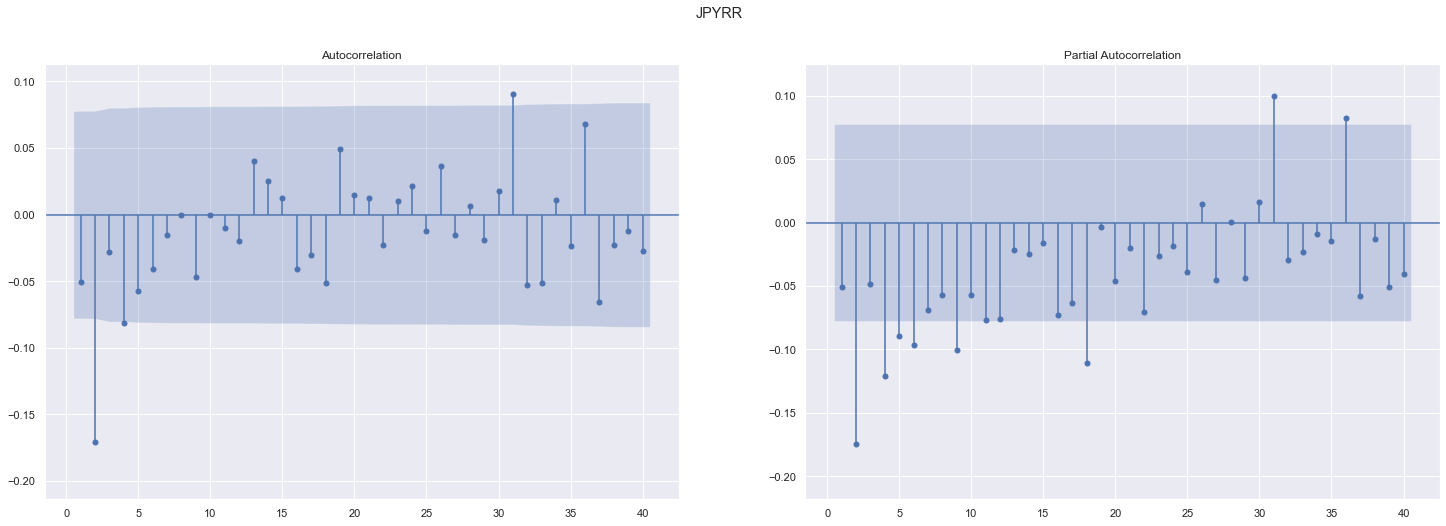

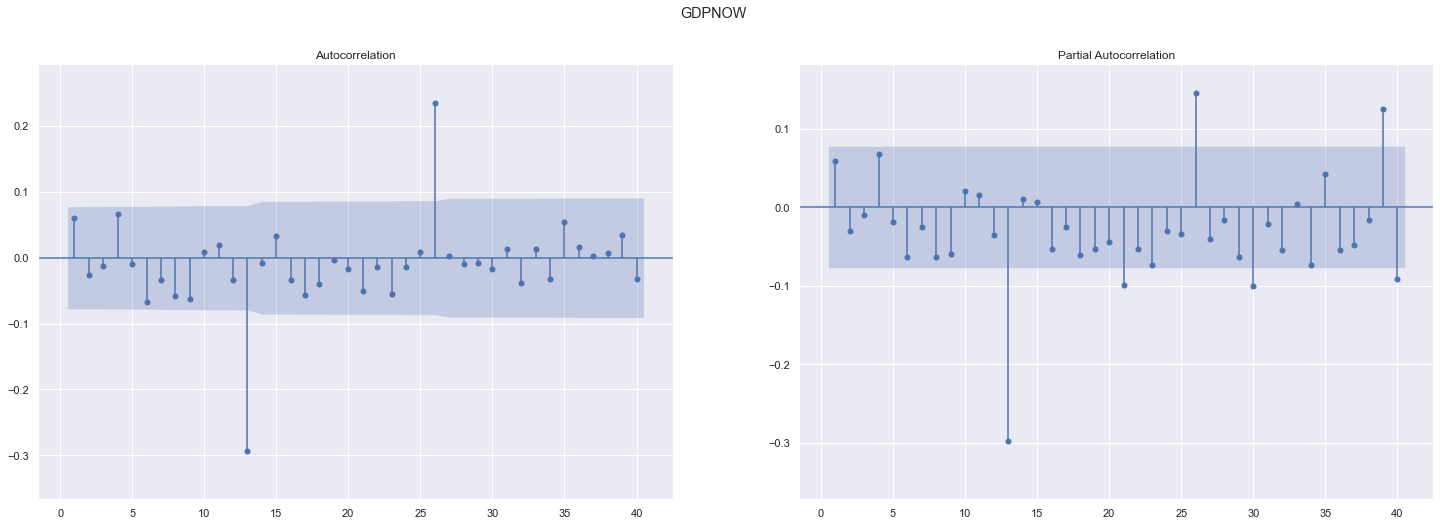

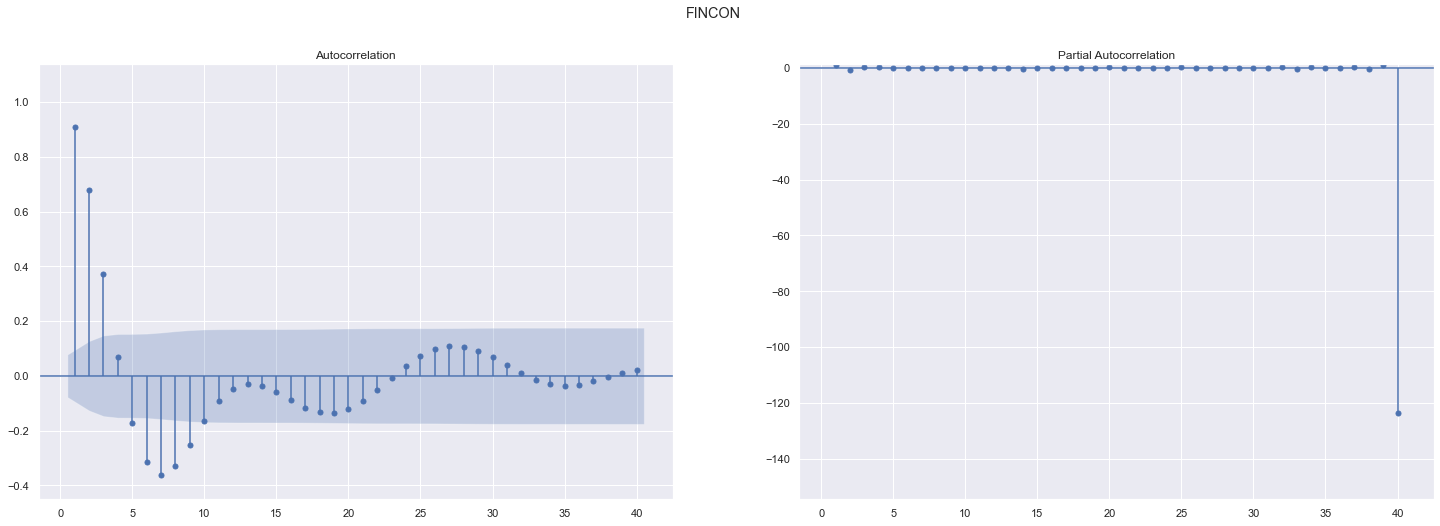

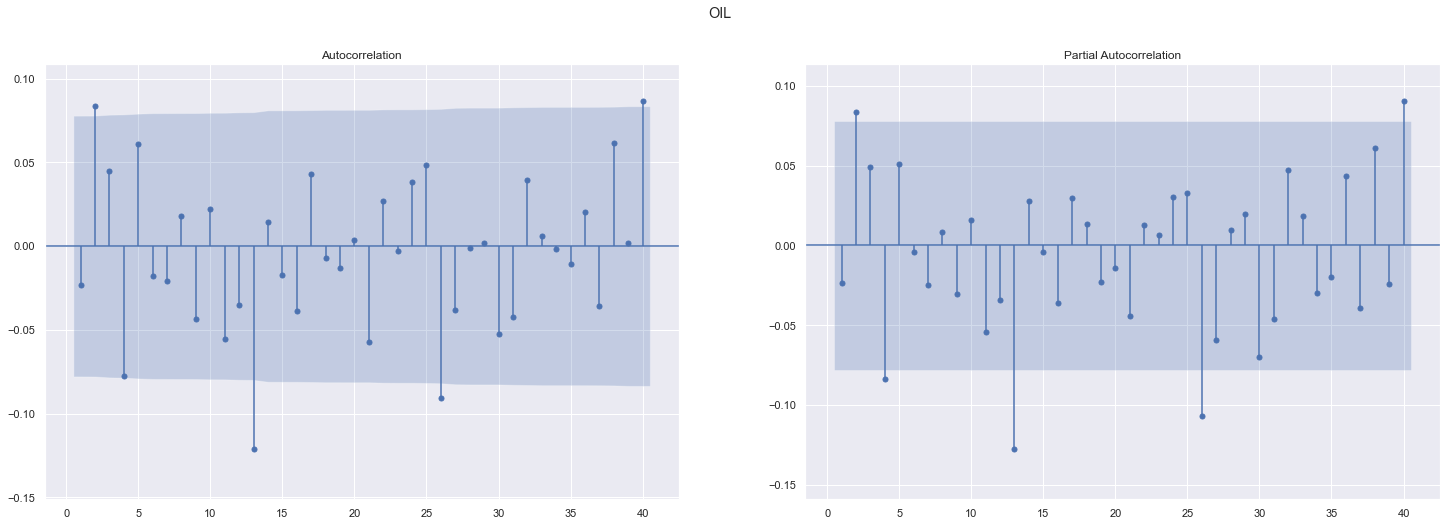

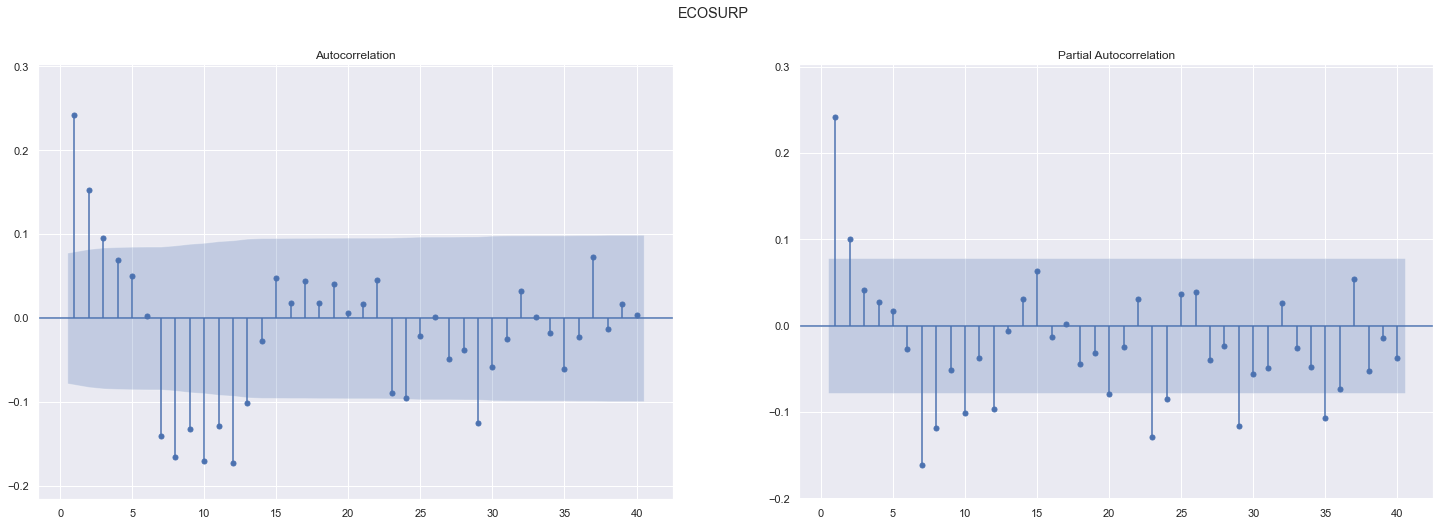

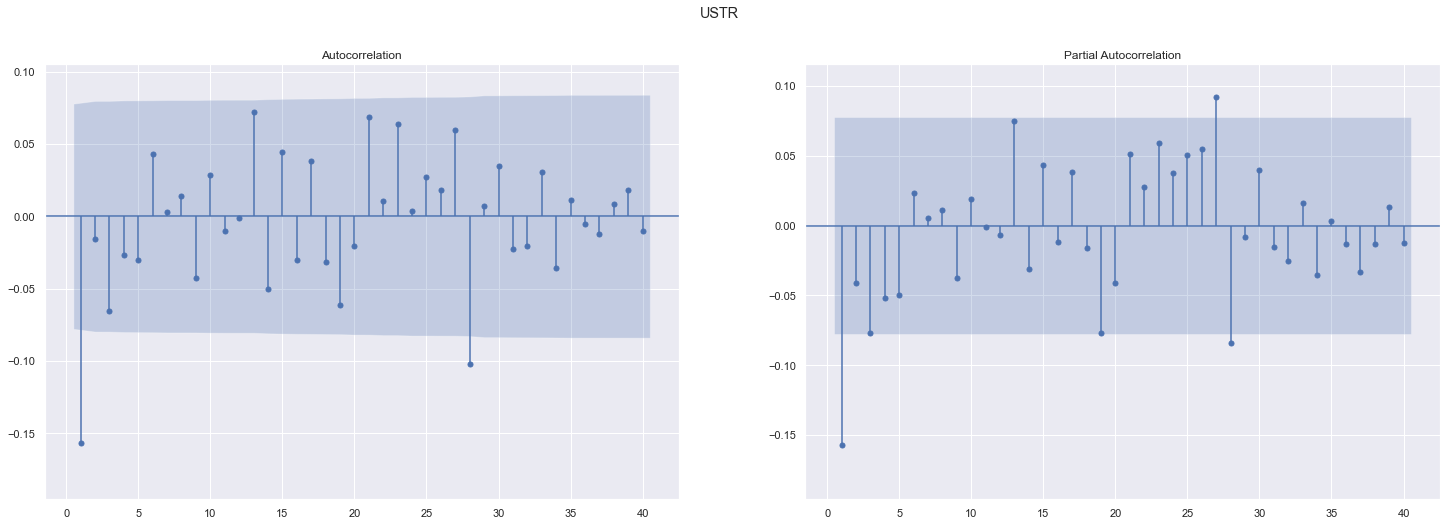

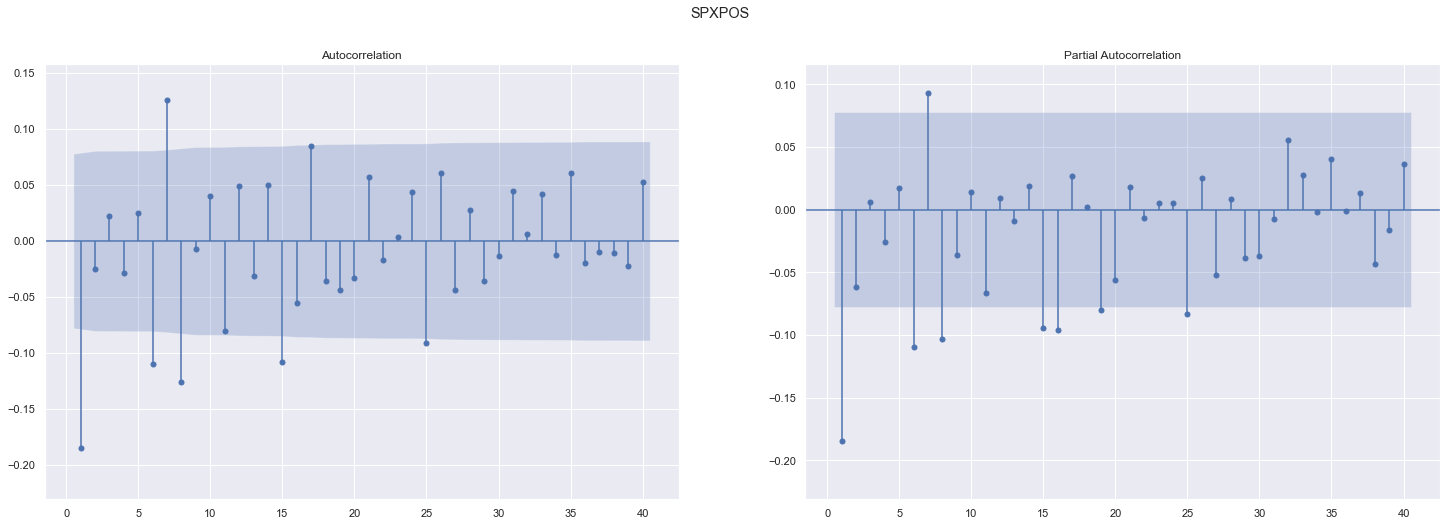

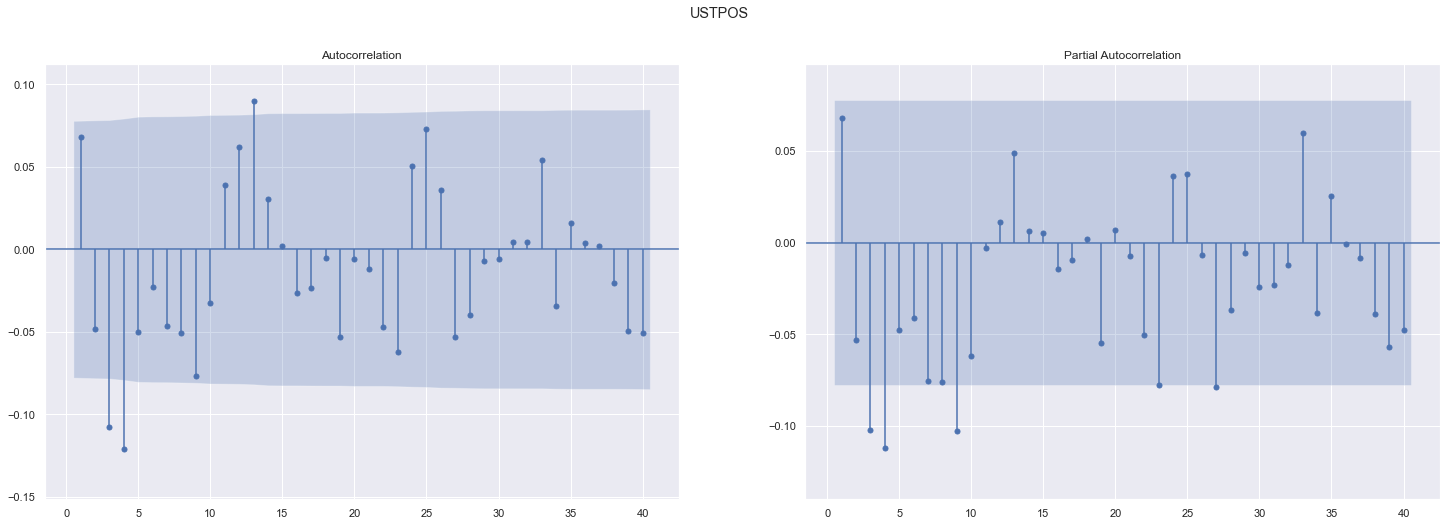

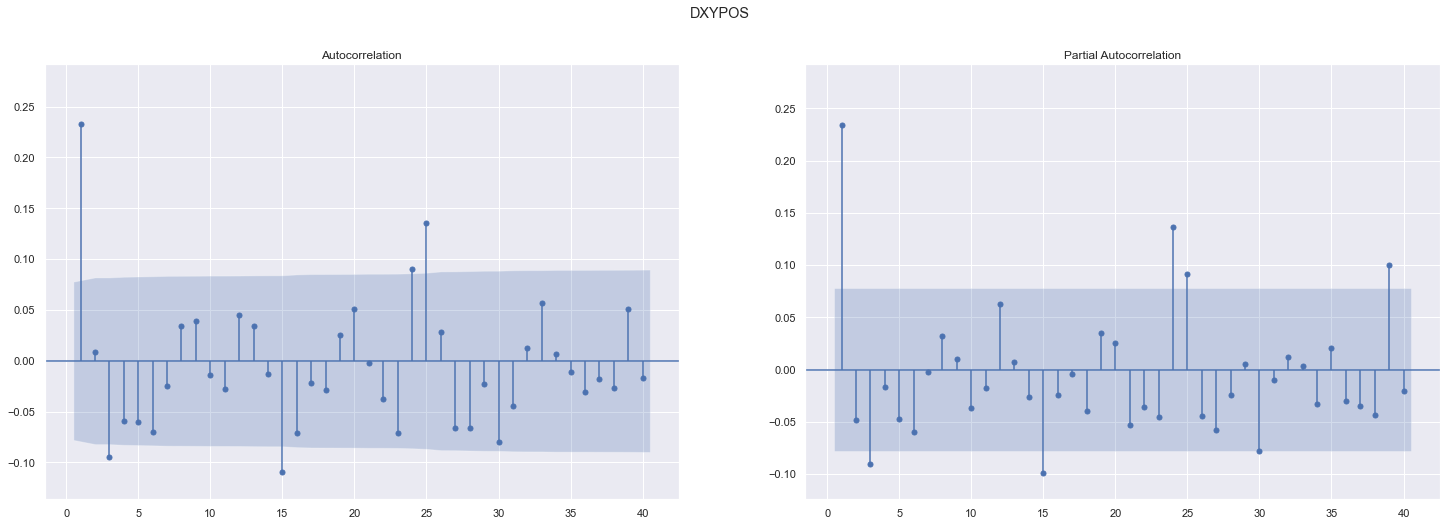

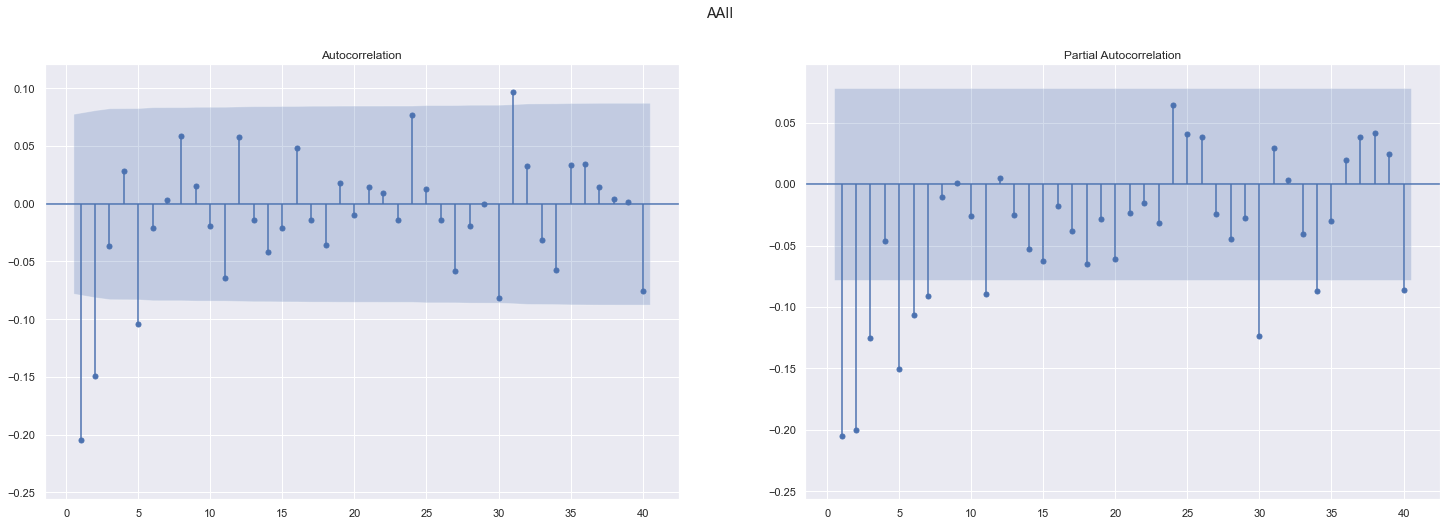

In [91]:
for col in macro_r.columns:
    plot_acf_pacf(macro_r[col], col)

In [92]:
data2 = macro_r

# Prepare data
data2['year'] = [d.year for d in data2.index]
data2['month'] = [d.strftime('%b') for d in data2.index]
data2['day'] = [d.strftime('%d') for d in data2.index]
years = data2['year'].unique()

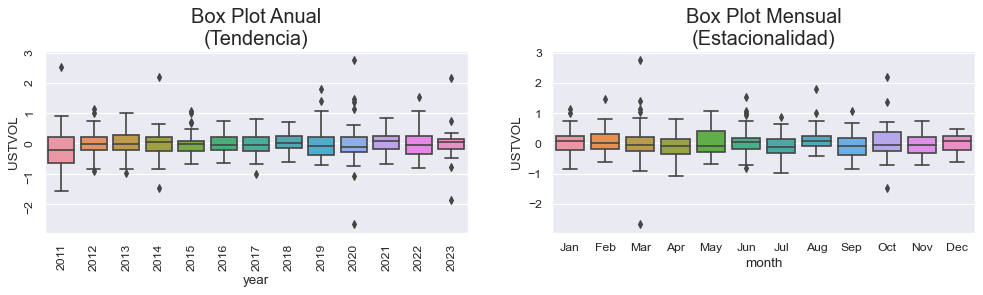

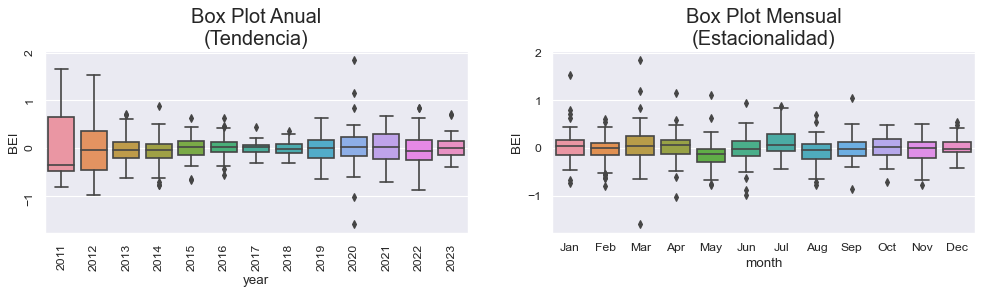

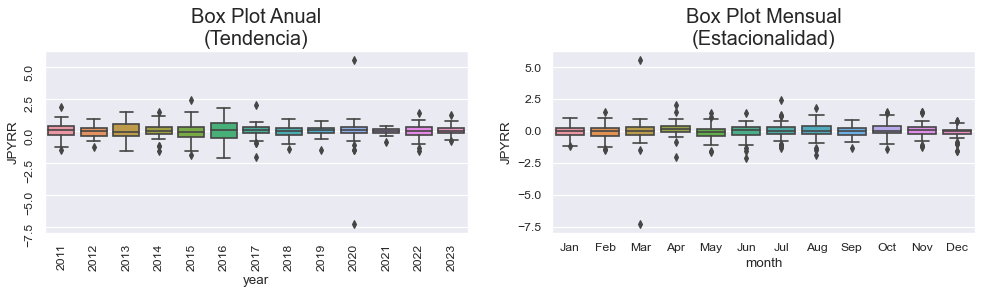

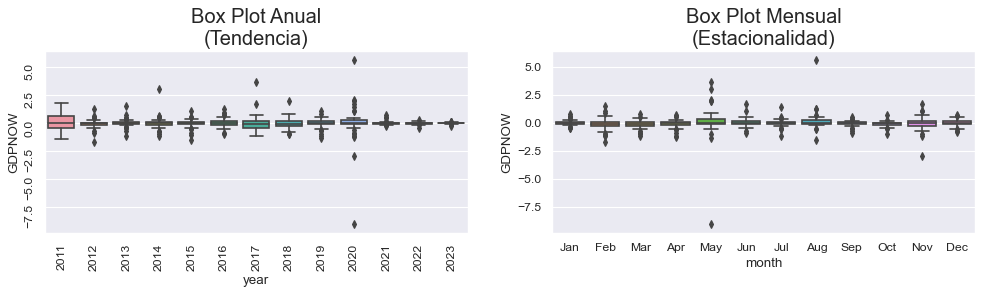

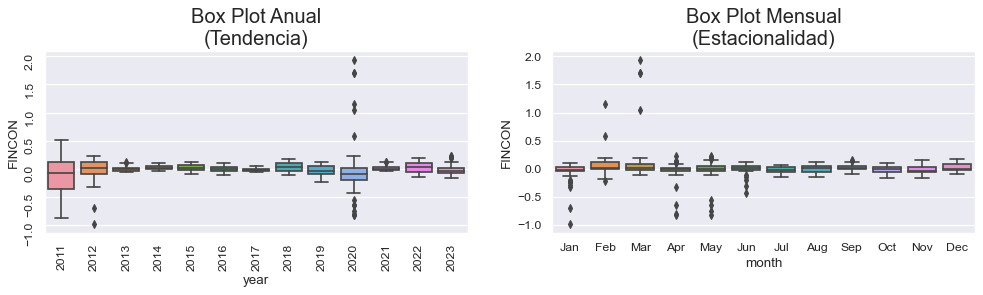

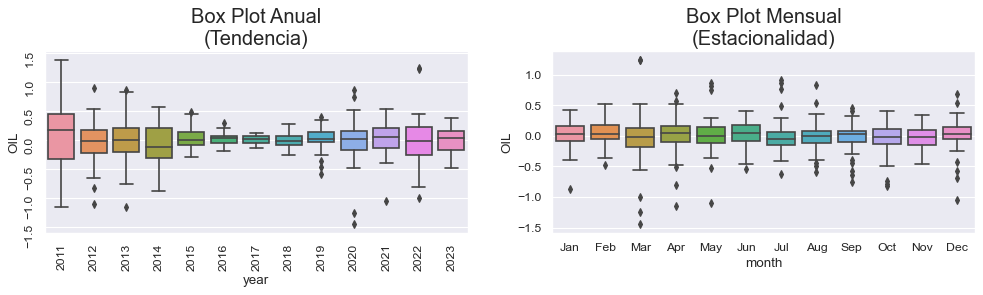

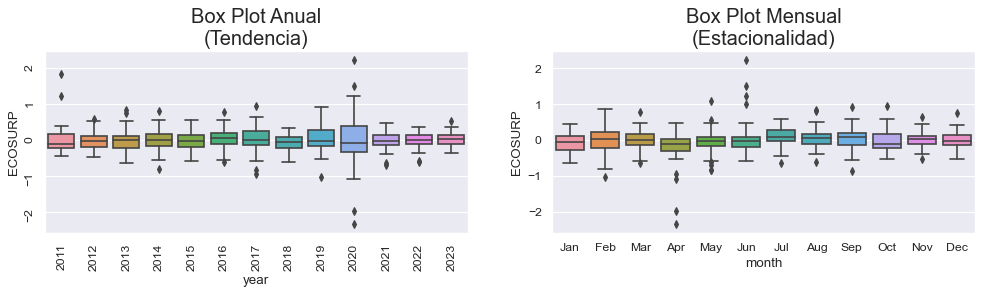

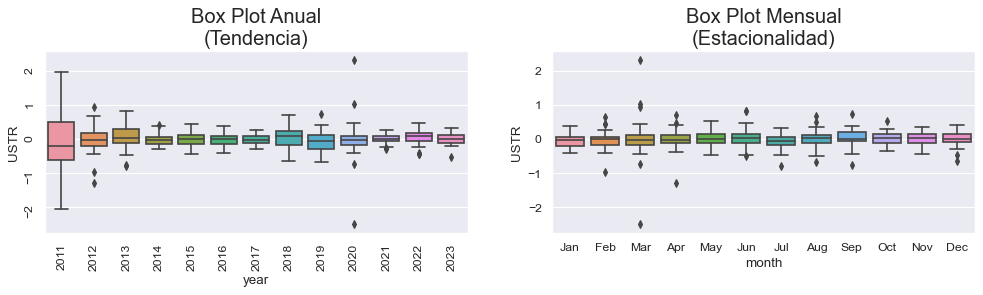

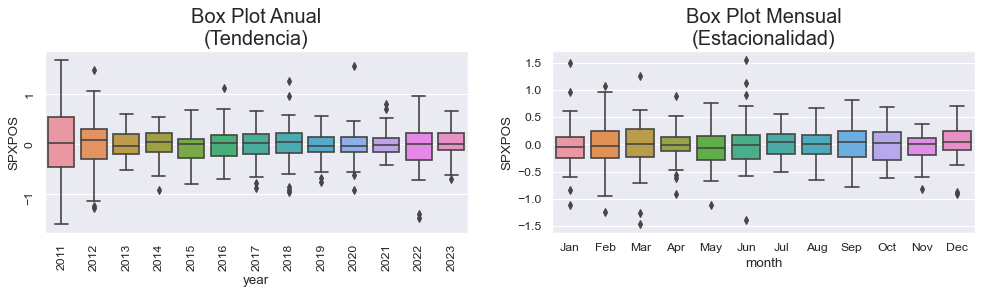

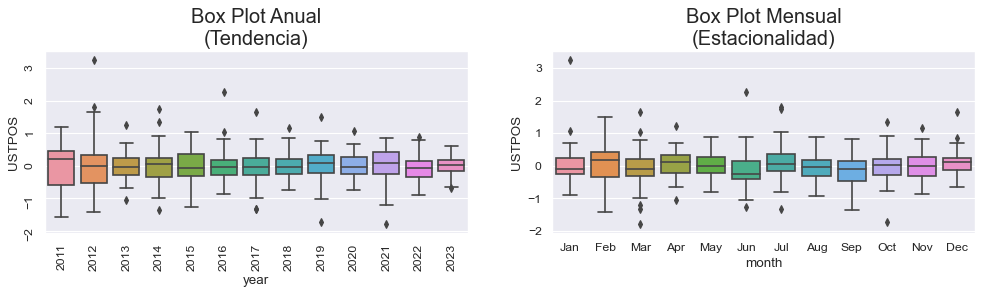

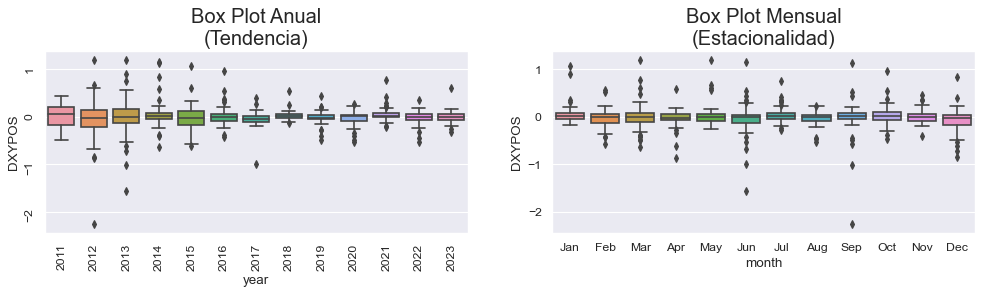

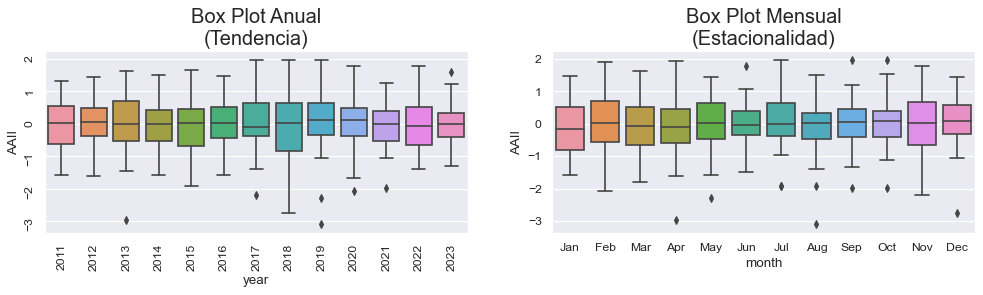

In [93]:
for col in macro_r.columns:
    if (col != 'day' and col != 'month' and col != 'year'):
        fig, axes = plt.subplots(1, 2, figsize=(15,3), dpi= 80)
        sns.boxplot(x='year', y= macro_r[col], data=macro_r, ax=axes[0])
        sns.boxplot(x='month', y= macro_r[col], data= macro_r.loc[~macro_r.year.isin([2011, 2023]), :])
        axes[0].set_title('Box Plot Anual\n(Tendencia)', fontsize=18); 
        axes[1].set_title('Box Plot Mensual\n(Estacionalidad)', fontsize=18)
        axes[0].tick_params(labelrotation=90)
        plt.show()

# Unión de datos

In [94]:
df = macro.merge(macro, how = 'left', left_index=True, right_index = True).drop(['year_x', 'month_x', 'day_x', 'year_y', 'month_y', 'day_y'], axis = 1)

In [95]:
df.head()

USTVOL_x     BEI_x   JPYRR_x  GDPNOW_x  FINCON_x     OIL_x  \
date                                                                     
2011-09-07  0.707107 -0.707107  0.707107 -0.707107  0.707107  0.707107   
2011-09-14 -0.865833 -0.762664  0.056009  1.091089  0.952217 -0.390621   
2011-09-21 -1.253277 -1.223897  0.220516  1.095445  1.008319 -1.483764   
2011-09-28  1.278523 -0.655151  0.478148  1.032796  0.990217 -1.642572   
2011-10-05  1.612667 -0.986611  0.645106  1.298972  0.843133 -1.408654   

            ECOSURP_x    USTR_x  SPXPOS_x  USTPOS_x  ...   JPYRR_y  GDPNOW_y  \
date                                                 ...                       
2011-09-07  -0.707107 -0.707107  0.707107 -0.707107  ...  0.707107 -0.707107   
2011-09-14   1.149464 -0.218218  1.018107  0.127238  ...  0.056009  1.091089   
2011-09-21   0.759720 -1.240216 -0.580486  1.293147  ...  0.220516  1.095445   
2011-09-28   0.556709  0.729149 -0.144498  0.612672  ...  0.478148  1.032796   
2011-10-05   1.796060  0.088527 -0.313697  0.238387  ...  0.645106  1.298972   

            FINCON_y     OIL_y  ECOSURP_y    USTR_y  SPXPOS_y  USTPOS_y  \
date                                                                      
2011-09-07  0.707107  0.707107  -0.707107 -0.707107  0.707107 -0.707107   
2011-09-14  0.952217 -0.390621   1.149464 -0.218218  1.018107  0.127238   
2011-09-21  1.008319 -1.483764   0.759720 -1.240216 -0.580486  1.293147   
2011-09-28  0.990217 -1.642572   0.556709  0.729149 -0.144498  0.612672   
2011-10-05  0.843133 -1.408654   1.796060  0.088527 -0.313697  0.238387   

            DXYPOS_y    AAII_y  
date                            
2011-09-07  0.707107  0.707107  
2011-09-14  1.151272 -0.878006  
2011-09-21  1.385215 -0.767110  
2011-09-28  1.150534 -1.359245  
2011-10-05  1.010535 -0.507175  

[5 rows x 24 columns]

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 635 entries, 2011-09-07 to 2023-11-01
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   USTVOL_x   635 non-null    float64
 1   BEI_x      635 non-null    float64
 2   JPYRR_x    635 non-null    float64
 3   GDPNOW_x   635 non-null    float64
 4   FINCON_x   635 non-null    float64
 5   OIL_x      635 non-null    float64
 6   ECOSURP_x  635 non-null    float64
 7   USTR_x     635 non-null    float64
 8   SPXPOS_x   635 non-null    float64
 9   USTPOS_x   635 non-null    float64
 10  DXYPOS_x   635 non-null    float64
 11  AAII_x     635 non-null    float64
 12  USTVOL_y   635 non-null    float64
 13  BEI_y      635 non-null    float64
 14  JPYRR_y    635 non-null    float64
 15  GDPNOW_y   635 non-null    float64
 16  FINCON_y   635 non-null    float64
 17  OIL_y      635 non-null    float64
 18  ECOSURP_y  635 non-null    float64
 19  USTR_y     635 non-null    floa

Los activos para modelar son: UST 10y, USDCOP, SPX, EEM y XAU.

In [97]:
df_r = macro_r.merge(macro, how = 'left', left_index=True, right_index = True).drop(['year_x', 'month_x', 'day_x', 'year_y', 'month_y', 'day_y'], axis = 1)

In [98]:
prat = pd.read_csv('price_rate.csv', index_col = 'date')
prat.index = (pd.to_datetime(prat.index, format='%Y-%m-%d'))

In [99]:

def preprocess_df(df, asset_name, col_prefix):
    df_processed = df.copy()
    df_processed.index = pd.to_datetime(df_processed.index, format='%Y-%m-%d')

    # Operaciones de cambio
    df_processed[f'R4W{asset_name}'] = (np.log(dataw[asset_name] / dataw[asset_name].shift(-4)) > 0).astype(int)
    df_processed[f'R2W{asset_name}'] = (np.log(dataw[asset_name] / dataw[asset_name].shift(-2)) > 0).astype(int)

    # Realizar todas las operaciones de merge en una sola línea
    df_processed = df_processed.merge(prat.filter(regex=f'{col_prefix}', axis=1), how='left', left_index=True, right_index=True)
    df_processed = df_processed.dropna(axis=0)

    # Eliminar las columnas 'year', 'month', 'day' después de las operaciones de merge
    df_processed = df_processed.drop(['year', 'month', 'day'], axis=1)
    
    return df_processed

In [100]:
# Lista de activos
activos = ['SPX', 'EEM', 'XAU', 'USTTEN', 'USDCOP']

# Crear y guardar un CSV para cada activo
for activo in activos:
    df_activo = preprocess_df(macro_r, activo, activo)
    print(activo)
    display(df_activo.head())
    
    # Guardar el DataFrame en un archivo CSV
    csv_filename = f"{activo}_df.csv"
    df_activo.to_csv(csv_filename)

SPX


USTVOL       BEI     JPYRR    GDPNOW    FINCON       OIL  \
date                                                                     
2011-09-14 -1.572940 -0.055558 -0.651098  1.798196  0.245111 -1.097728   
2011-09-21 -0.387444 -0.461233  0.164507  0.004356  0.056102 -1.093142   
2011-09-28  2.531801  0.568746  0.257632 -0.062650 -0.018103 -0.158808   
2011-10-05  0.334144 -0.331461  0.166958  0.266176 -0.147084  0.233917   
2011-10-12 -0.414408  1.524823  1.084317 -0.375892 -0.280339  1.392025   

             ECOSURP      USTR    SPXPOS    USTPOS    DXYPOS      AAII  \
date                                                                     
2011-09-14  1.856571  0.488889  0.311000  0.834344  0.444165 -1.585113   
2011-09-21 -0.389744 -1.021998 -1.598593  1.165909  0.233943  0.110896   
2011-09-28 -0.203011  1.969365  0.435989 -0.680475 -0.234681 -0.592135   
2011-10-05  1.239351 -0.640622 -0.169199 -0.374285 -0.139999  0.852070   
2011-10-12 -0.053101  1.563207 -0.081087  0.277890  0.087266  0.398273   

            R4WSPX  R2WSPX    SPX_4     SPX_8    SPX_16    SPX_32    SPX_64  
date                                                                         
2011-09-14       0       1  1.00000  0.776076  0.532787  0.400532  0.296116  
2011-09-21       0       1  0.00000  0.083550  0.193783  0.475712  0.202344  
2011-09-28       0       0  0.37561  0.288474  0.248699  0.288695  0.135181  
2011-10-05       0       0  1.00000  0.588313  0.383627  0.374394  0.176385  
2011-10-12       0       0  1.00000  1.000000  1.000000  0.902724  0.439481

EEM


USTVOL       BEI     JPYRR    GDPNOW    FINCON       OIL  \
date                                                                     
2011-09-14 -1.572940 -0.055558 -0.651098  1.798196  0.245111 -1.097728   
2011-09-21 -0.387444 -0.461233  0.164507  0.004356  0.056102 -1.093142   
2011-09-28  2.531801  0.568746  0.257632 -0.062650 -0.018103 -0.158808   
2011-10-05  0.334144 -0.331461  0.166958  0.266176 -0.147084  0.233917   
2011-10-12 -0.414408  1.524823  1.084317 -0.375892 -0.280339  1.392025   

             ECOSURP      USTR    SPXPOS    USTPOS    DXYPOS      AAII  \
date                                                                     
2011-09-14  1.856571  0.488889  0.311000  0.834344  0.444165 -1.585113   
2011-09-21 -0.389744 -1.021998 -1.598593  1.165909  0.233943  0.110896   
2011-09-28 -0.203011  1.969365  0.435989 -0.680475 -0.234681 -0.592135   
2011-10-05  1.239351 -0.640622 -0.169199 -0.374285 -0.139999  0.852070   
2011-10-12 -0.053101  1.563207 -0.081087  0.277890  0.087266  0.398273   

            R4WEEM  R2WEEM     EEM_4     EEM_8    EEM_16    EEM_32    EEM_64  
date                                                                          
2011-09-14       1       1  0.000000  0.000000  0.013746  0.105198  0.089947  
2011-09-21       0       1  0.000000  0.000000  0.000000  0.000000  0.000000  
2011-09-28       0       0  0.335294  0.342466  0.202703  0.192308  0.110865  
2011-10-05       0       0  1.000000  0.416149  0.217180  0.159714  0.094901  
2011-10-12       0       0  1.000000  1.000000  1.000000  0.572110  0.359551

XAU


USTVOL       BEI     JPYRR    GDPNOW    FINCON       OIL  \
date                                                                     
2011-09-14 -1.572940 -0.055558 -0.651098  1.798196  0.245111 -1.097728   
2011-09-21 -0.387444 -0.461233  0.164507  0.004356  0.056102 -1.093142   
2011-09-28  2.531801  0.568746  0.257632 -0.062650 -0.018103 -0.158808   
2011-10-05  0.334144 -0.331461  0.166958  0.266176 -0.147084  0.233917   
2011-10-12 -0.414408  1.524823  1.084317 -0.375892 -0.280339  1.392025   

             ECOSURP      USTR    SPXPOS    USTPOS    DXYPOS      AAII  \
date                                                                     
2011-09-14  1.856571  0.488889  0.311000  0.834344  0.444165 -1.585113   
2011-09-21 -0.389744 -1.021998 -1.598593  1.165909  0.233943  0.110896   
2011-09-28 -0.203011  1.969365  0.435989 -0.680475 -0.234681 -0.592135   
2011-10-05  1.239351 -0.640622 -0.169199 -0.374285 -0.139999  0.852070   
2011-10-12 -0.053101  1.563207 -0.081087  0.277890  0.087266  0.398273   

            R4WXAU  R2WXAU     XAU_4     XAU_8    XAU_16    XAU_32    XAU_64  
date                                                                          
2011-09-14       1       1  0.112847  0.067198  0.489946  0.720728  0.810599  
2011-09-21       1       1  0.106056  0.062933  0.033138  0.506831  0.719143  
2011-09-28       0       0  0.000000  0.000000  0.000000  0.000000  0.296881  
2011-10-05       0       1  0.494349  0.644892  0.150446  0.109920  0.327824  
2011-10-12       0       0  1.000000  1.000000  0.345140  0.245215  0.357056

USTTEN


USTVOL       BEI     JPYRR    GDPNOW    FINCON       OIL  \
date                                                                     
2011-09-14 -1.572940 -0.055558 -0.651098  1.798196  0.245111 -1.097728   
2011-09-21 -0.387444 -0.461233  0.164507  0.004356  0.056102 -1.093142   
2011-09-28  2.531801  0.568746  0.257632 -0.062650 -0.018103 -0.158808   
2011-10-05  0.334144 -0.331461  0.166958  0.266176 -0.147084  0.233917   
2011-10-12 -0.414408  1.524823  1.084317 -0.375892 -0.280339  1.392025   

             ECOSURP      USTR    SPXPOS    USTPOS    DXYPOS      AAII  \
date                                                                     
2011-09-14  1.856571  0.488889  0.311000  0.834344  0.444165 -1.585113   
2011-09-21 -0.389744 -1.021998 -1.598593  1.165909  0.233943  0.110896   
2011-09-28 -0.203011  1.969365  0.435989 -0.680475 -0.234681 -0.592135   
2011-10-05  1.239351 -0.640622 -0.169199 -0.374285 -0.139999  0.852070   
2011-10-12 -0.053101  1.563207 -0.081087  0.277890  0.087266  0.398273   

            R4WUSTTEN  R2WUSTTEN  USTTEN_4  USTTEN_8  USTTEN_16  USTTEN_32  \
date                                                                         
2011-09-14          1          0  0.904564  0.524880   0.171609   0.074504   
2011-09-21          1          1  0.000000  0.000000   0.000000   0.000000   
2011-09-28          1          1  1.000000  1.000000   0.718956   0.450120   
2011-10-05          1          1  0.826223  0.548293   0.466209   0.291882   
2011-10-12          0          0  1.000000  1.000000   1.000000   0.914514   

            USTTEN_64  
date                   
2011-09-14   0.051741  
2011-09-21   0.000000  
2011-09-28   0.178720  
2011-10-05   0.119532  
2011-10-12   0.379824

USDCOP


USTVOL       BEI     JPYRR    GDPNOW    FINCON       OIL  \
date                                                                     
2011-09-14 -1.572940 -0.055558 -0.651098  1.798196  0.245111 -1.097728   
2011-09-21 -0.387444 -0.461233  0.164507  0.004356  0.056102 -1.093142   
2011-09-28  2.531801  0.568746  0.257632 -0.062650 -0.018103 -0.158808   
2011-10-05  0.334144 -0.331461  0.166958  0.266176 -0.147084  0.233917   
2011-10-12 -0.414408  1.524823  1.084317 -0.375892 -0.280339  1.392025   

             ECOSURP      USTR    SPXPOS    USTPOS    DXYPOS      AAII  \
date                                                                     
2011-09-14  1.856571  0.488889  0.311000  0.834344  0.444165 -1.585113   
2011-09-21 -0.389744 -1.021998 -1.598593  1.165909  0.233943  0.110896   
2011-09-28 -0.203011  1.969365  0.435989 -0.680475 -0.234681 -0.592135   
2011-10-05  1.239351 -0.640622 -0.169199 -0.374285 -0.139999  0.852070   
2011-10-12 -0.053101  1.563207 -0.081087  0.277890  0.087266  0.398273   

            R4WUSDCOP  R2WUSDCOP  USDCOP_4  USDCOP_8  USDCOP_16  USDCOP_32  \
date                                                                         
2011-09-14          0          0  1.000000  1.000000   1.000000   1.000000   
2011-09-21          0          0  1.000000  1.000000   1.000000   1.000000   
2011-09-28          1          1  1.000000  1.000000   1.000000   1.000000   
2011-10-05          1          1  0.577819  0.760697   0.861510   0.889861   
2011-10-12          0          1  0.000000  0.000000   0.288266   0.573790   

            USDCOP_64  
date                   
2011-09-14   1.000000  
2011-09-21   1.000000  
2011-09-28   1.000000  
2011-10-05   0.904025  
2011-10-12   0.628602

# Calculo retorno mensual USDCOP

In [101]:
carry_m = data_r[['RUSCASH','RCOCASH']].rolling(30).sum().dropna()
datam_ri = dataw.drop(['day', 'month', 'year', 'COCASH', 'USCASH'], axis = 1).apply(lambda col: np.log(col / col.shift(4)))
datam_ri.columns = [f'R{col}' for col in datam_ri.columns]
datam_r= pd.merge(datam_ri, carry_m, how='left', left_index=True, right_index=True)
datam_r['RUSDCOP'] = datam_r['RUSDCOP'] + (datam_r['RUSCASH'] - datam_r['RCOCASH'])
datam_r.drop(['RUSCASH', 'RCOCASH'], axis=1, inplace=True)
datam_r.tail()

RSPX      REEM      RXAU   RUSTTEN   RUSDCOP
date                                                        
2023-10-04 -0.046228 -0.050903 -0.050948 -0.034962  0.044684
2023-10-11 -0.020463 -0.015236 -0.017851 -0.023250  0.062400
2023-10-18 -0.020100 -0.032307  0.008897 -0.039609  0.077437
2023-10-25 -0.020740 -0.028972  0.054283 -0.026419  0.009596
2023-11-01 -0.030123 -0.016009  0.085889 -0.007528       NaN

In [102]:
datam_r['R4WUSDCOP'] = (datam_r['RUSDCOP'].shift(-4) > 0).astype(int)
datam_r.dropna(inplace=True)

In [103]:
df_activo.drop(['R4WUSDCOP', 'R2WUSDCOP'], axis = 1, inplace = True)
USDCOP_df = df_activo.merge(datam_r['R4WUSDCOP'], how='left', left_index=True, right_index=True)
USDCOP_df.to_csv('USDCOP_df.csv')

In [104]:
USDCOP_df.head()

USTVOL       BEI     JPYRR    GDPNOW    FINCON       OIL  \
date                                                                     
2011-09-14 -1.572940 -0.055558 -0.651098  1.798196  0.245111 -1.097728   
2011-09-21 -0.387444 -0.461233  0.164507  0.004356  0.056102 -1.093142   
2011-09-28  2.531801  0.568746  0.257632 -0.062650 -0.018103 -0.158808   
2011-10-05  0.334144 -0.331461  0.166958  0.266176 -0.147084  0.233917   
2011-10-12 -0.414408  1.524823  1.084317 -0.375892 -0.280339  1.392025   

             ECOSURP      USTR    SPXPOS    USTPOS    DXYPOS      AAII  \
date                                                                     
2011-09-14  1.856571  0.488889  0.311000  0.834344  0.444165 -1.585113   
2011-09-21 -0.389744 -1.021998 -1.598593  1.165909  0.233943  0.110896   
2011-09-28 -0.203011  1.969365  0.435989 -0.680475 -0.234681 -0.592135   
2011-10-05  1.239351 -0.640622 -0.169199 -0.374285 -0.139999  0.852070   
2011-10-12 -0.053101  1.563207 -0.081087  0.277890  0.087266  0.398273   

            USDCOP_4  USDCOP_8  USDCOP_16  USDCOP_32  USDCOP_64  R4WUSDCOP  
date                                                                        
2011-09-14  1.000000  1.000000   1.000000   1.000000   1.000000          1  
2011-09-21  1.000000  1.000000   1.000000   1.000000   1.000000          1  
2011-09-28  1.000000  1.000000   1.000000   1.000000   1.000000          0  
2011-10-05  0.577819  0.760697   0.861510   0.889861   0.904025          0  
2011-10-12  0.000000  0.000000   0.288266   0.573790   0.628602          1

# Retornos Mensuales

In [166]:
datae =  data.drop(['year', 'month', 'day', 'USCASH', 'COCASH'], axis = 1)
m_returns = np.log(datae / datae.shift(30)).dropna()
m_returns['USDCOP'] += (carry_m['RUSCASH'] - carry_m['RCOCASH'])

m_returns.head(10)

SPX       EEM       XAU    USTTEN    USDCOP
date                                                        
2011-02-14  0.046434 -0.057770 -0.038196 -0.021115  0.007020
2011-02-15  0.044507 -0.060353 -0.004829 -0.020181  0.011852
2011-02-16  0.045751 -0.049548 -0.002805 -0.010126  0.019702
2011-02-17  0.050947 -0.035324  0.009087 -0.012194  0.015859
2011-02-18  0.054716 -0.020095  0.014822 -0.018477  0.006955
2011-02-21  0.056093 -0.009670  0.022099 -0.022400  0.006942
2011-02-22  0.031641 -0.052681  0.012630 -0.006824  0.021506
2011-02-23  0.016535 -0.071775  0.016960 -0.007322  0.022802
2011-02-24  0.017252 -0.060598  0.020935 -0.009825  0.021685
2011-02-25  0.020390 -0.051590  0.035207 -0.004814  0.022621

In [167]:
m_returns.to_csv('m_returns.csv')